In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from tqdm import tqdm
import copy

from sklearn.preprocessing import PolynomialFeatures

sns.set(style="darkgrid", font_scale=1.4)
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/AEG'

/content/drive/My Drive/AEG


# Preprocess data

In [4]:
def create_dataloaders(n_samples):
  X, y = make_moons(n_samples=n_samples, random_state=42, noise=0.07)
  y[y==0]=-1
  X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)
  scalar = preprocessing.StandardScaler().fit(X_train)
  X_train = scalar.transform(X_train)
  scalar2 = preprocessing.StandardScaler().fit(X_val)
  X_val = scalar2.transform(X_val)
  X_train_t = torch.from_numpy(X_train).to(torch.float32)
  y_train_t = torch.from_numpy(y_train).to(torch.float32)
  X_val_t = torch.from_numpy(X_val).to(torch.float32)
  y_val_t = torch.from_numpy(y_val).to(torch.float32)

  return X_train_t, y_train_t, X_val_t, y_val_t

# Plotting codes

In [5]:
from pylab import MaxNLocator

def plot(train_ent, eval_ent):
  plt.plot(np.arange(len(train_ent)), train_ent)
  plt.xlabel('epochs')
  plt.ylabel('train F entropy')
  plt.show()
  plt.plot(np.arange(len(eval_ent)), eval_ent)
  plt.xlabel('epochs')
  plt.ylabel('eval F entropy')
  plt.show()


def plot_entropies(list1, list2, list3, norm):
  plt.plot(np.arange(len(list1)), list1, label = 'Linear')
  plt.plot(np.arange(len(list2)), list2, label = 'Poly3')
  plt.plot(np.arange(len(list3)), list3, label = 'Poly5')
  plt.xlabel('Iterations')
  plt.ylabel('F-entropy')
  plt.legend()
  path = './images/F-entropies'+norm+'.jpg'
  plt.savefig(path, bbox_inches='tight')
  plt.show()

def plot_dis(distances, arr):
  plt.plot(arr, distances)
  plt.ylabel('distance to optimal weights')
  plt.show()

In [26]:
def plot_data(critic, X, y, X_adv, txt, name, norm):
  X = X.detach().numpy()
  y = y.detach().numpy()
  X_adv = X_adv.detach().numpy()
  print('in plot_data')

  x0_list = np.linspace(X[:, 0].min()-0.3, X[:, 0].max()+0.3, 400)
  x1_list = np.linspace(X[:, 1].min()-0.3, X[:, 1].max()+0.3, 400)
  x0_v, x1_v = np.meshgrid(x0_list, x1_list, sparse=False, indexing='ij')
  Z = pointwise_eval(critic, x0_v, x1_v)
  fig, ax = plt.subplots(figsize=(12,8))
  CS = ax.contourf(x0_v, x1_v, Z, cmap='RdBu', alpha=0.35)
  ax.clabel(CS, inline=True, fontsize=10)

  indices = torch.randint(X.shape[0], (150,))
  X = X[indices]
  y = y[indices]
  X_adv = X_adv[indices]

  if np.array_equal(X,X_adv):
    ax.scatter(X[y==-1, 0], X[y==-1, 1], marker=">", c='r');
    ax.scatter(X[y==1, 0], X[y==1, 1], marker=">", c='b');
    ax.set_ylabel('Clean Dataset', fontsize=35)

  else: 
    ax.scatter(X_adv[y==-1, 0], X_adv[y==-1, 1], marker="o", c='g');
    ax.scatter(X_adv[y==1, 0], X_adv[y==1, 1], marker="o", c='y');
    ax.scatter(X[y==-1, 0], X[y==-1, 1], marker=">", c='r', alpha=0.5);
    ax.scatter(X[y==1, 0], X[y==1, 1], marker=">", c='b', alpha=0.5);
  ax.set_xticks([])
  ax.set_yticks([])

  fig.text(.5, .05, txt, ha='center', fontsize='large')
  path = './images/' + str(name)+ norm + '.jpg'
  plt.savefig(path, bbox_inches='tight')
  plt.show()

def plot_data_fin(critic, X,y, X_adv, name, norm):
  X = X.detach().numpy()
  y = y.detach().numpy()
  X_adv = X_adv.detach().numpy()
  print('in plot_data_fin')

  x0_list = np.linspace(X[:, 0].min()-0.3, X[:, 0].max()+0.3, 400)
  x1_list = np.linspace(X[:, 1].min()-0.3, X[:, 1].max()+0.3, 400)
  x0_v, x1_v = np.meshgrid(x0_list, x1_list, sparse=False, indexing='ij')
  Z = pointwise_eval(critic, x0_v, x1_v)
  fig, ax = plt.subplots(figsize=(12,8))
  CS = ax.contourf(x0_v, x1_v, Z, cmap='RdBu', alpha=0.35)
  ax.clabel(CS, inline=True, fontsize=10)

  indices = torch.randint(X.shape[0], (150,))
  X = X[indices]
  y = y[indices]
  X_adv = X_adv[indices]

  ax.scatter(X_adv[y==-1, 0], X_adv[y==-1, 1], marker="o", c='g');
  ax.scatter(X_adv[y==1, 0], X_adv[y==1, 1], marker="o", c='y');
  ax.scatter(X[y==-1, 0], X[y==-1, 1], marker=">", c='r', alpha=0.5);
  ax.scatter(X[y==1, 0], X[y==1, 1], marker=">", c='b', alpha=0.5); 
  ax.set_title('')
  ax.set_xlabel(name, fontsize = 35)
  ax.set_ylabel('Adversarial Dataset', fontsize=35)
  ax.set_xticks([])
  ax.set_yticks([])  
  for i in range(X.shape[0]):
    x_values = [X[i,0], X_adv[i,0]]
    y_values = [X[i,1], X_adv[i,1]]
    ax.plot(x_values, y_values, color='blue', linestyle="dashed", alpha=0.5)
  path = './images/final_plot_'+name+ norm +'.jpg'
  plt.savefig(path, bbox_inches='tight')
  plt.show()

# Models and training

In [7]:
def poly_features(X, degree):
  X = X.numpy()
  poly = PolynomialFeatures(degree=degree)
  return torch.from_numpy(poly.fit_transform(X)).to(torch.float32)

In [21]:
class Critic_Linear(nn.Module):
  def __init__(self, input_dim):
    super(Critic_Linear, self).__init__()
    self.fc = nn.Linear(input_dim,1)

  def forward(self, x):
    return self.fc(x)


class Critic_Poly(nn.Module):
  def __init__(self, input_dim, poly_degree):
    super(Critic_Poly, self).__init__()
    temp_tensor = torch.zeros((1, input_dim))
    poly_tensor = poly_features(temp_tensor, poly_degree)
    features_num = poly_tensor.shape[1]
    self.poly_degree = poly_degree
    self.linear = nn.Linear(features_num,1, bias=False)

  def forward(self, x):
    x = poly_features(x, self.poly_degree)
    return self.linear(x)


def loss_single(pred, target):
  return torch.log(1+torch.exp(-pred * target))

def generator(eps, n_samples, x, y, critic, norm='L2'):
  output = torch.zeros_like(x)
  for i in range(x.shape[0]):

    # source: https://stackoverflow.com/questions/61401747/random-function-in-python-to-generate-random-pair-inside-a-circle

    if norm == 'L_inf':
      points = torch.from_numpy(np.random.uniform(-eps, eps, size=(n_samples,2))).to(torch.float32) + x[i]
    else: 
      t = np.random.uniform(0, 1, size=n_samples)
      u = np.random.uniform(0, 1, size=n_samples)
      ee = eps*np.sqrt(t) * np.cos(2*np.pi*u)
      ww = eps*np.sqrt(t) * np.sin(2*np.pi*u)
      circle_points = torch.from_numpy(np.concatenate((ee[:,np.newaxis], ww[:, np.newaxis]), axis=1)).to(torch.float32)
      points = circle_points + x[i]

    preds = critic(points)
    targets = torch.tile(torch.unsqueeze(y[i],0), (n_samples, 1))
    loss = torch.squeeze(loss_single(preds, targets),1)
    max = torch.argmax(loss)
    output[i] = points[max]
  return output 


def generator_prop2(eps, inputs, targets, weights):
  x_adv = inputs - torch.unsqueeze(targets,1) * eps * torch.tile(torch.sign(weights), (len(targets), 1))
  return x_adv

In [22]:
def pointwise_eval(critic, matrix_d1, matrix_d2):
    n, m = matrix_d1.shape
    z = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
          array = np.array([matrix_d1[i, j], matrix_d2[i,j]])
          tensor = torch.unsqueeze(torch.from_numpy(array).to(torch.float32),0)
          z[i, j] = critic(tensor).detach().numpy()[0]
    return z

In [23]:
def loss_fn(adv_pred, target):
  adv_pred = torch.squeeze(adv_pred, 1)
  return torch.mean(torch.log(1+torch.exp(-adv_pred * target)))

def loss_fn_reg(adv_pred, target, eps, critic):
  adv_pred = torch.squeeze(adv_pred, 1)
  norm = 0
  for w in critic.parameters():
    norm += eps * torch.sum(torch.abs(w.data))
  return torch.mean(torch.log(1+torch.exp(-adv_pred * target + norm)))

def adv_ex(inputs, targets, eps, weights):
  x_adv = inputs - torch.unsqueeze(targets,1) * eps * torch.tile(torch.sign(weights), (len(targets), 1))
  return x_adv

def F_entropy(critic, x_adv, y):
    adv_pred = critic(x_adv).detach()
    entropy = loss_fn(adv_pred, y)
    return entropy

def train(critic, X_train, y_train, X_eval, y_eval, args, exp_name):
  opt = optim.SGD(critic.parameters(), lr=args['lr'])

  losses = []
  train_entropies = []
  eval_entropies = []
  distances = []

  x_adv = X_train
  x_adv_eval = X_eval
  for outer_epoch in range(args['outer_epochs']):

    prev_loss = -100
    epoch=0

    while(True):
      epoch+=1
      opt.zero_grad()
      pred = critic(x_adv)
      loss = loss_fn(pred, y_train)
      loss.backward()
      if epoch%1000==0:
        print(f'epoch:{epoch} train_loss:{loss.item()}')
      losses.append(loss.item())
      opt.step()
      if np.abs(loss.item() - prev_loss)<args['stop_treshold'] : 
        break
      prev_loss = loss.item()

    if outer_epoch == 0:
      txt = args['name'] + ' - iteration ' + str(outer_epoch+1) + '- Red: Clean with y=-1, Blue: Clean with y=1'
    else: 
      txt = args['name'] + ' - iteration ' + str(outer_epoch+1) + ' - Red: Clean with y=-1, Blue: Clean with y=1, Green: Adversarial with y=-1, Yellow: Adversarial with y=1'

    if outer_epoch==args['outer_epochs']-1:
      plot_data_fin(critic, X_train, y_train, x_adv, args['name'], args['norm'])
    else:
      name = args['name'] + 'iteration' + str(outer_epoch)
      plot_data(critic, X_train, y_train, x_adv, txt, name, args['norm'])

    train_F_ent = F_entropy(critic, x_adv, y_train).detach()
    eval_F_ent = F_entropy(critic, x_adv_eval, y_eval).detach()

    if exp_name == 'prop3':
      x_adv = generator(args['eps'], args['n_samples'], X_train, y_train, critic, norm=args['norm']).detach()
      x_adv_eval = generator(args['eps'], args['n_samples'], X_eval, y_eval, critic, norm=args['norm']).detach()
    else:
      weights = []
      critic_copy = copy.deepcopy(critic)
      with torch.no_grad():
        for w in critic_copy.parameters():
          t = torch.empty_like(w.data).copy_(w.data).detach()
          weights.append(t)
      x_adv = generator_prop2(args['eps'], X_train, y_train, weights[0])
      x_adv_eval = generator_prop2(args['eps'], X_eval, y_eval, weights[0])
     
      opt_weights = args['opt_w']
      distances.append(torch.linalg.norm(weights[0]-opt_weights[0]))


    train_entropies.append(train_F_ent.item())
    eval_entropies.append(eval_F_ent.item())
  
  plot(train_entropies, eval_entropies)
  if exp_name == 'prop2':
    plot_dis(distances, np.arange(len(distances)))
    plot_dis(distances[1:], np.arange(len(distances)-1)+1)
  
  return train_entropies, eval_entropies

# Test with $L_{\infty}$

In the following cell, the $\epsilon$-neighborhood around each point is calculated with respect to the $L_{\infty}$ norm.

epoch:1000 train_loss:0.2967544198036194
epoch:2000 train_loss:0.2665540874004364
in plot_data


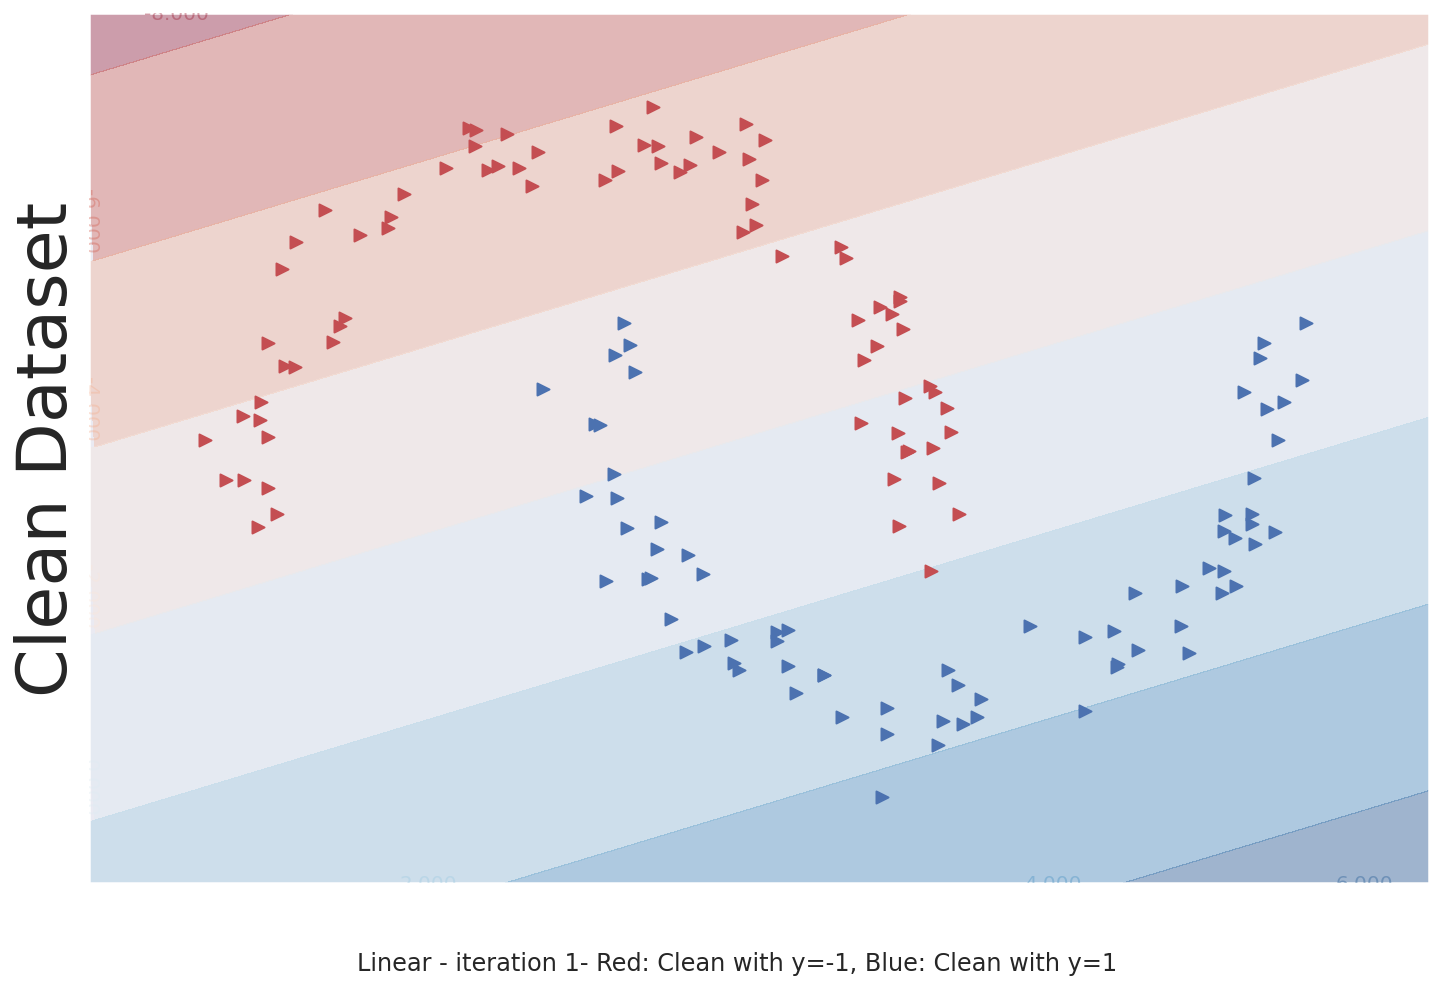

in plot_data


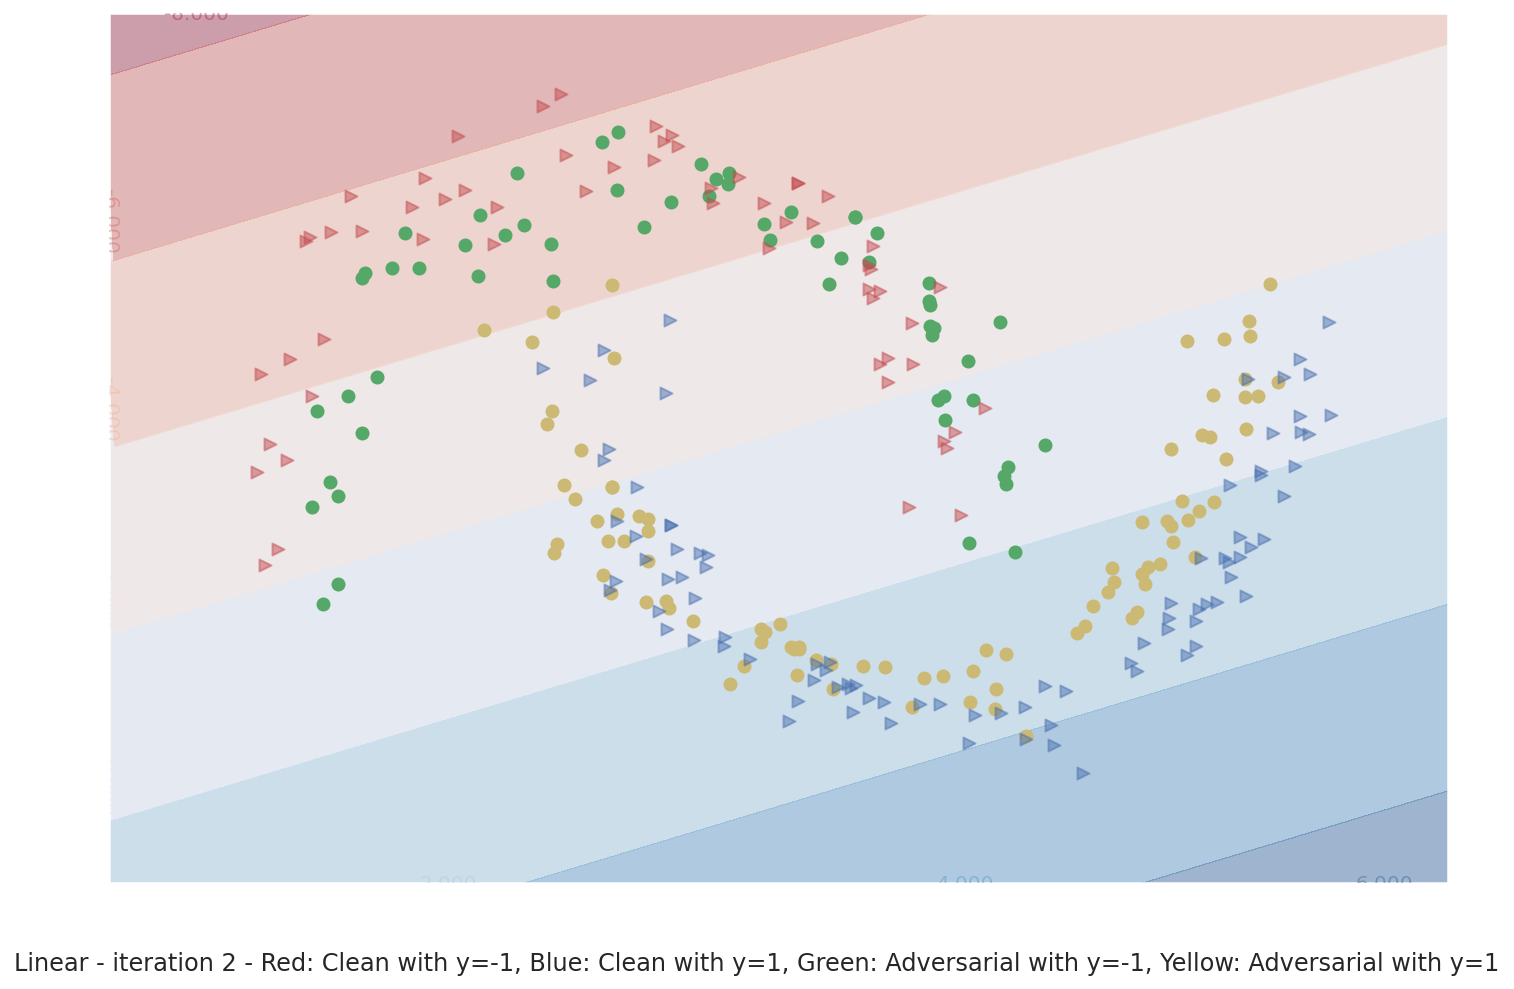

in plot_data


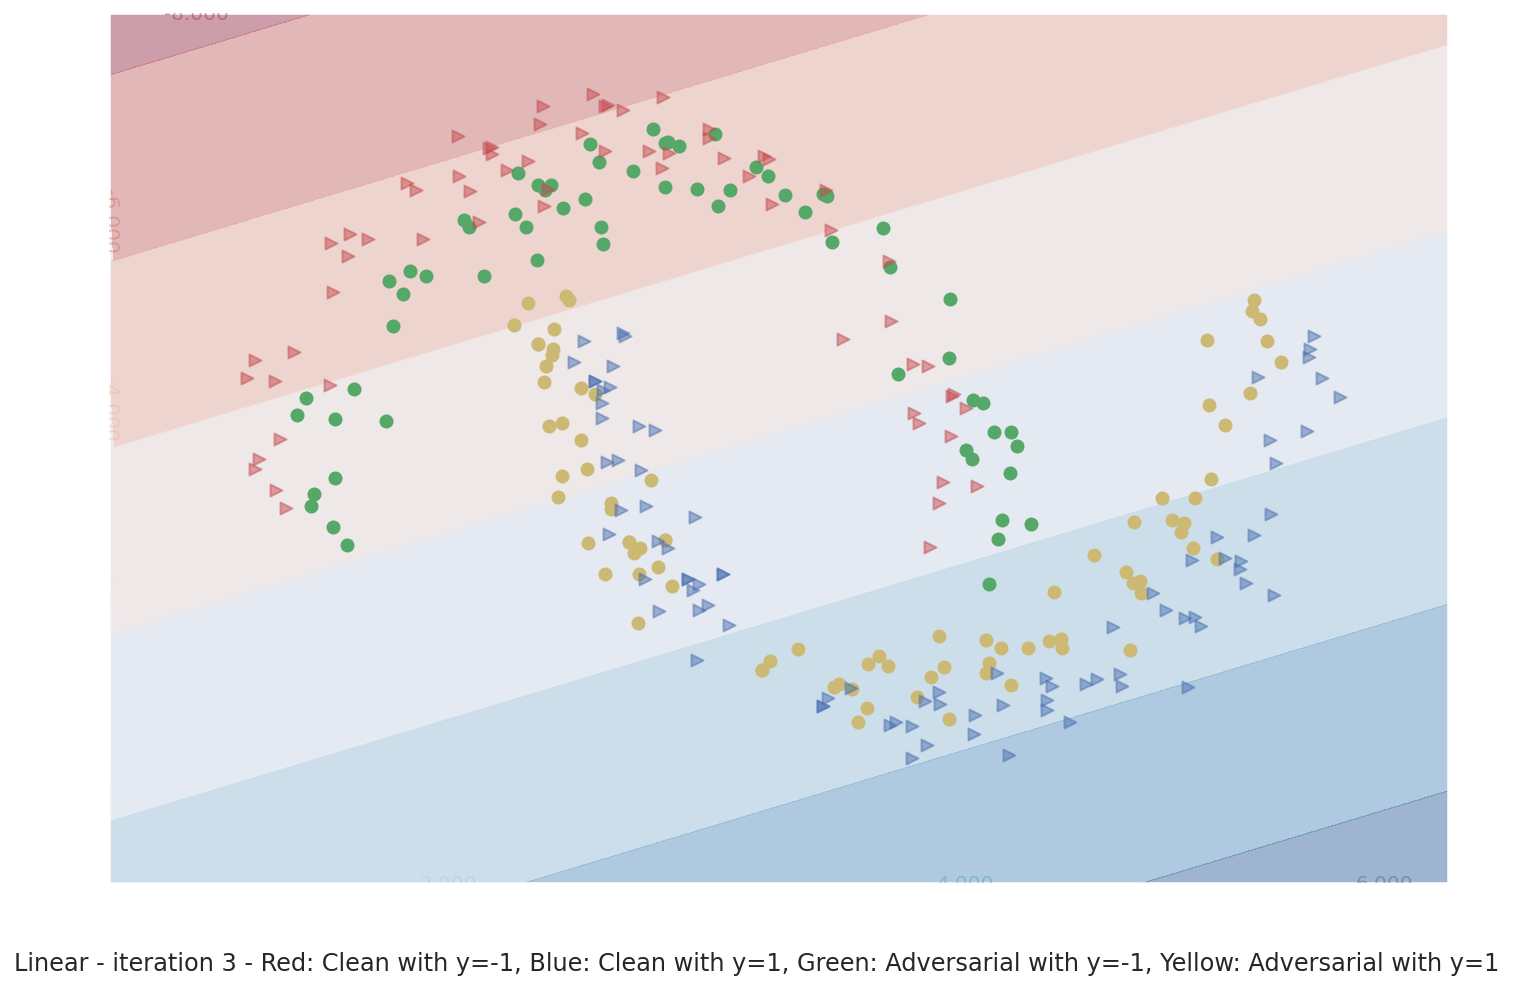

in plot_data


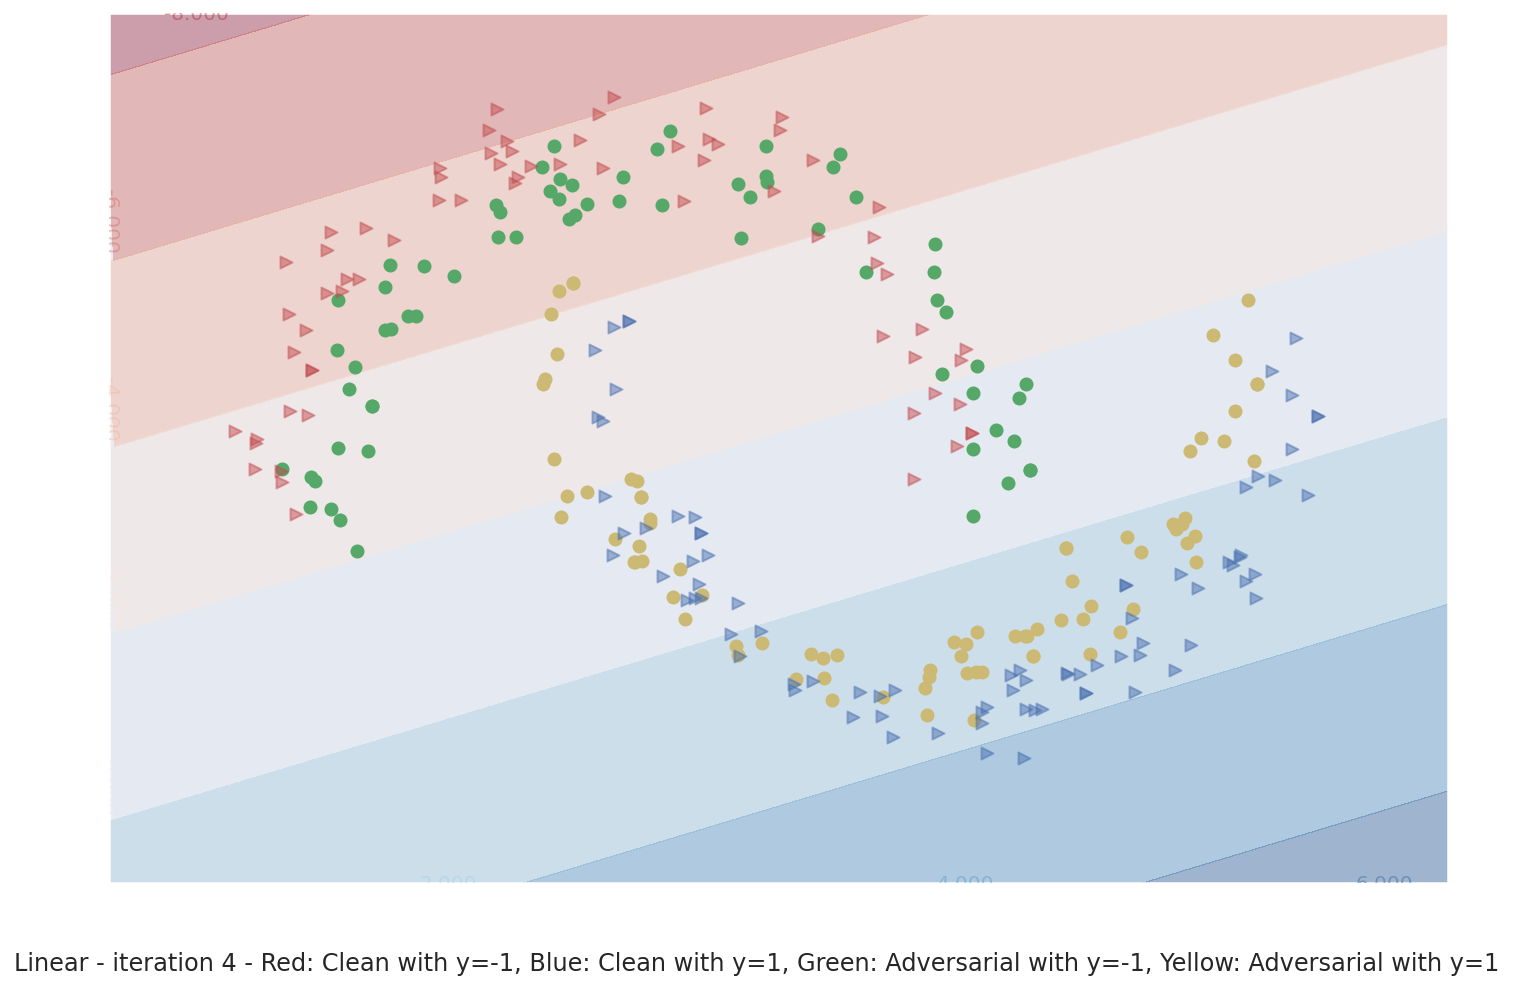

in plot_data


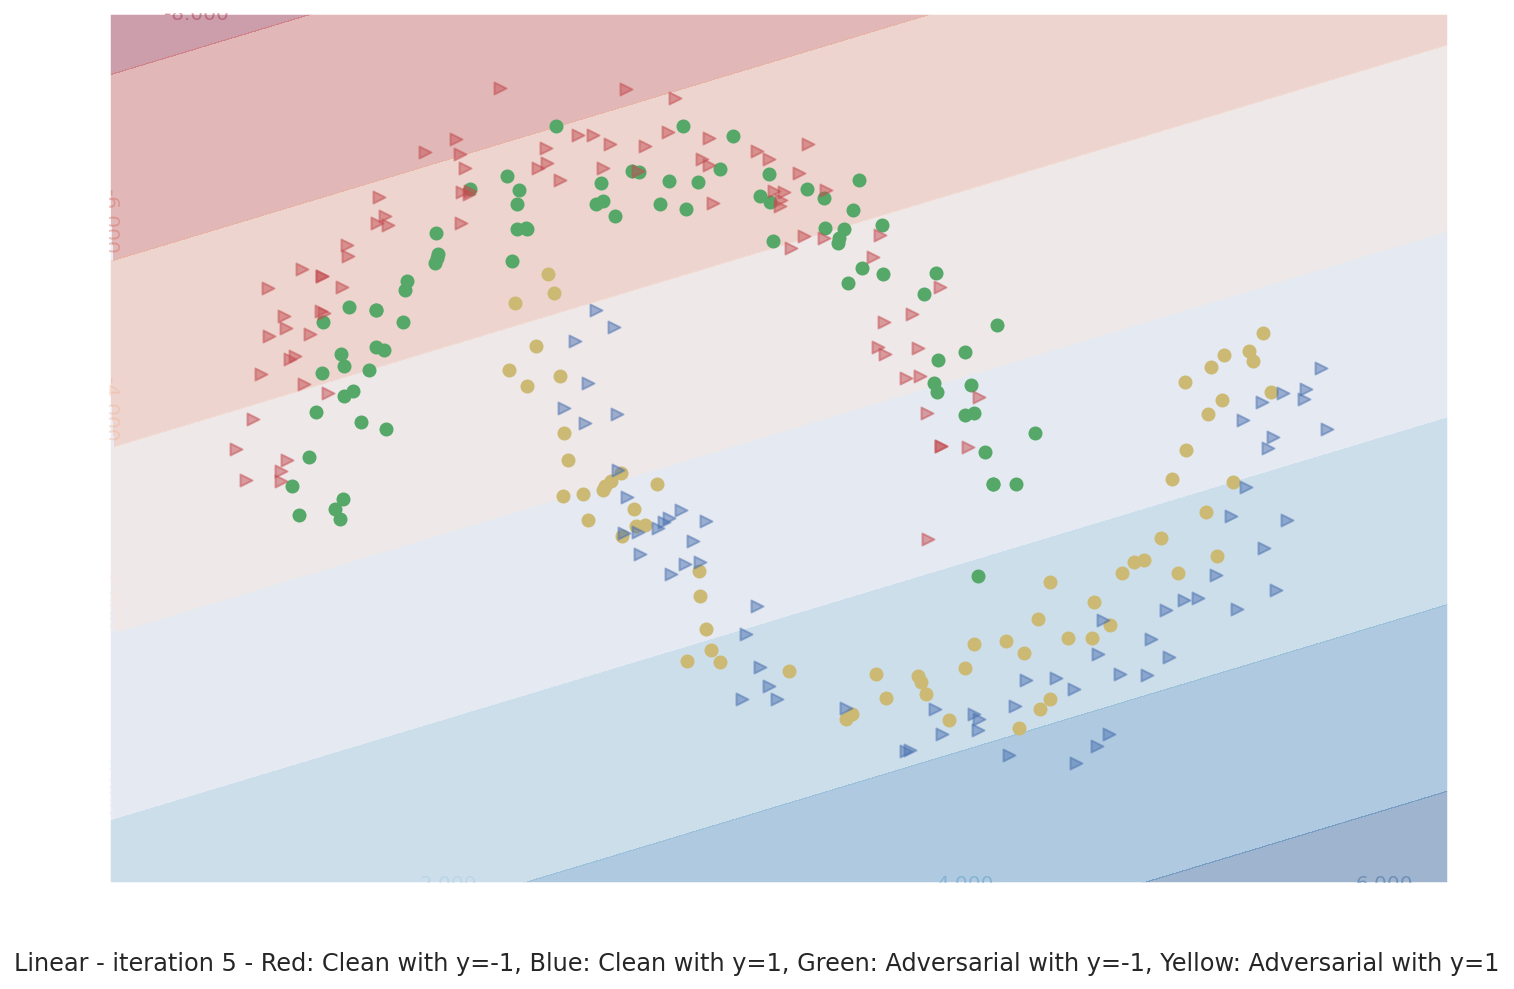

in plot_data_fin


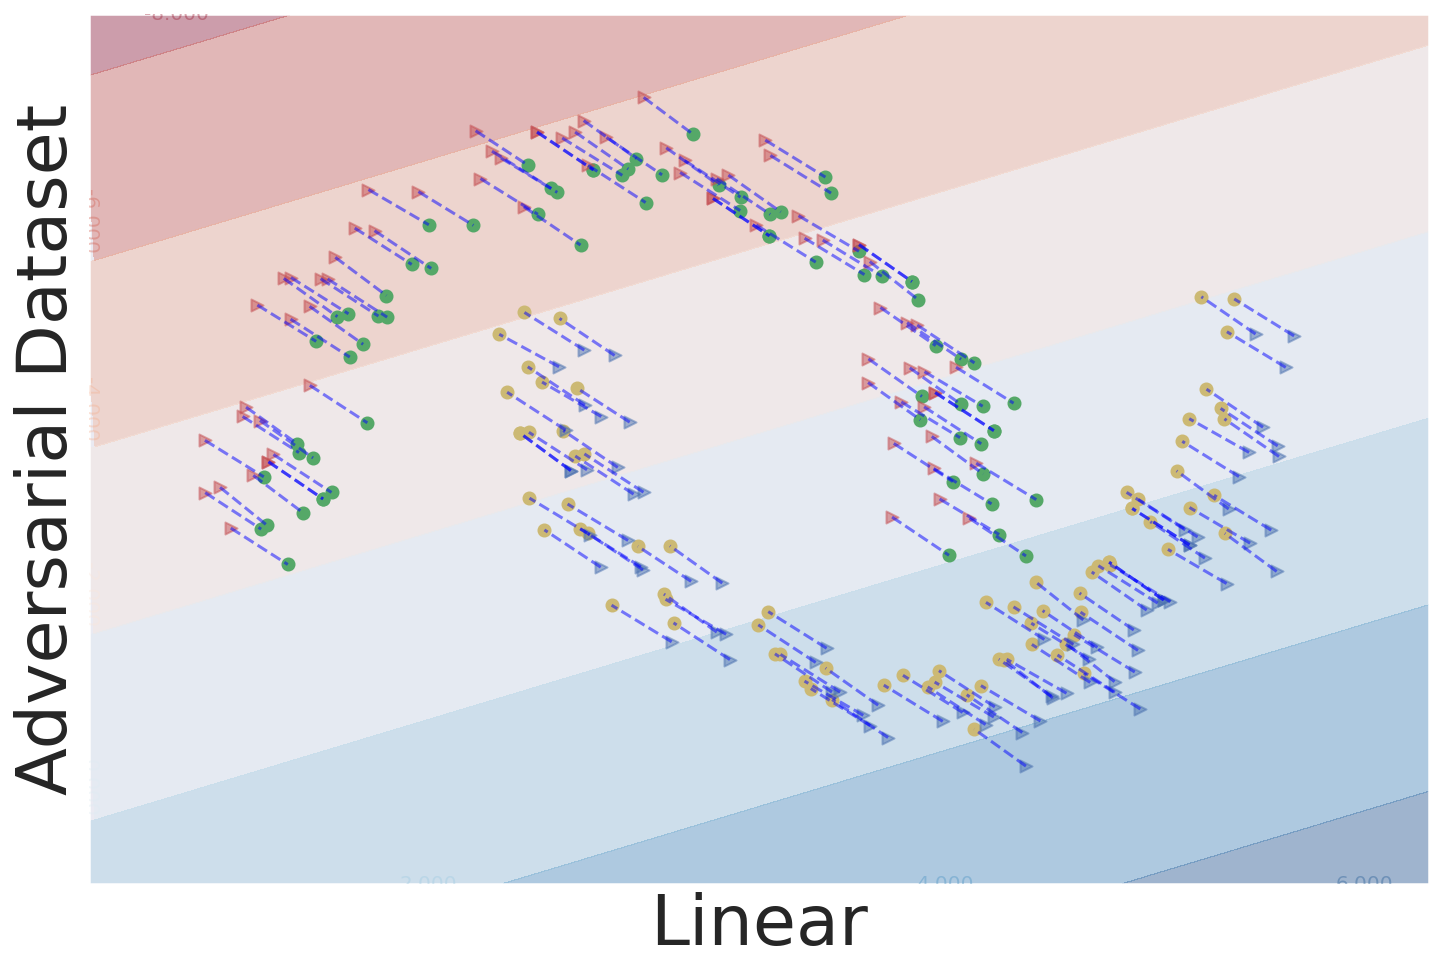

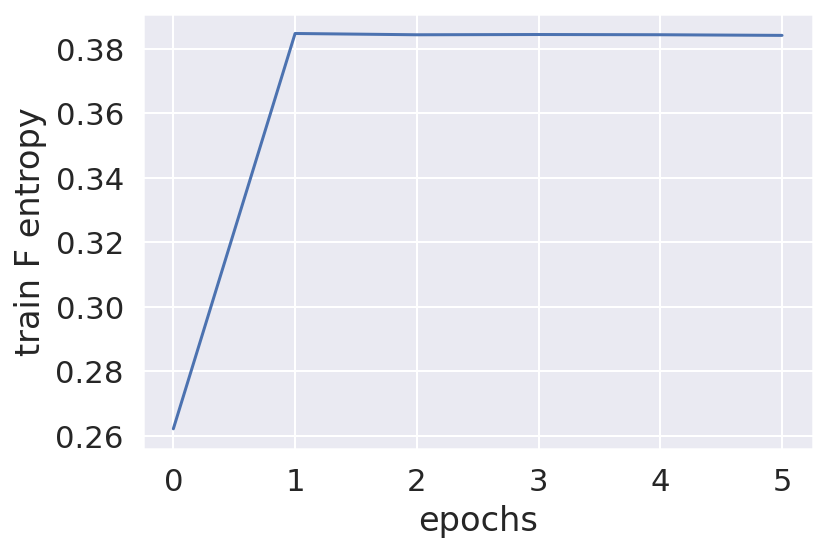

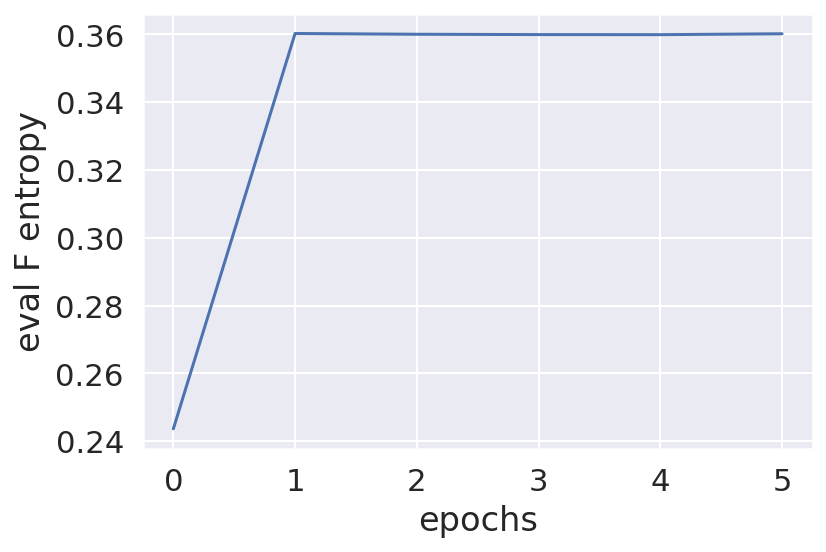

epoch:1000 train_loss:0.19328927993774414
epoch:2000 train_loss:0.16051220893859863
epoch:3000 train_loss:0.13948163390159607
epoch:4000 train_loss:0.12370192259550095
epoch:5000 train_loss:0.11113826185464859
in plot_data


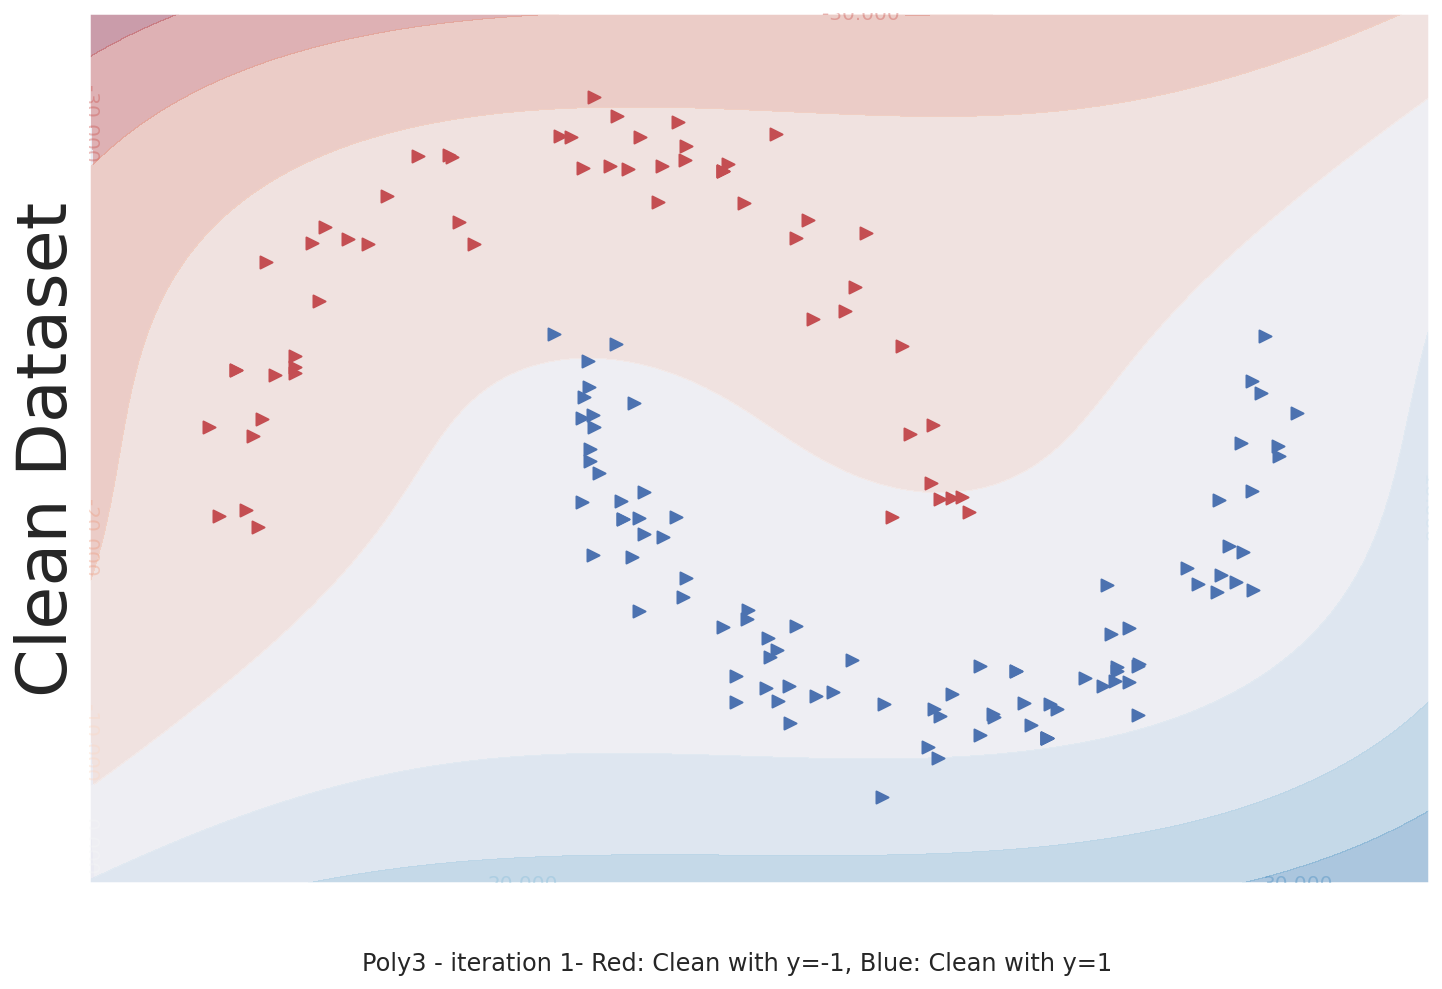

in plot_data


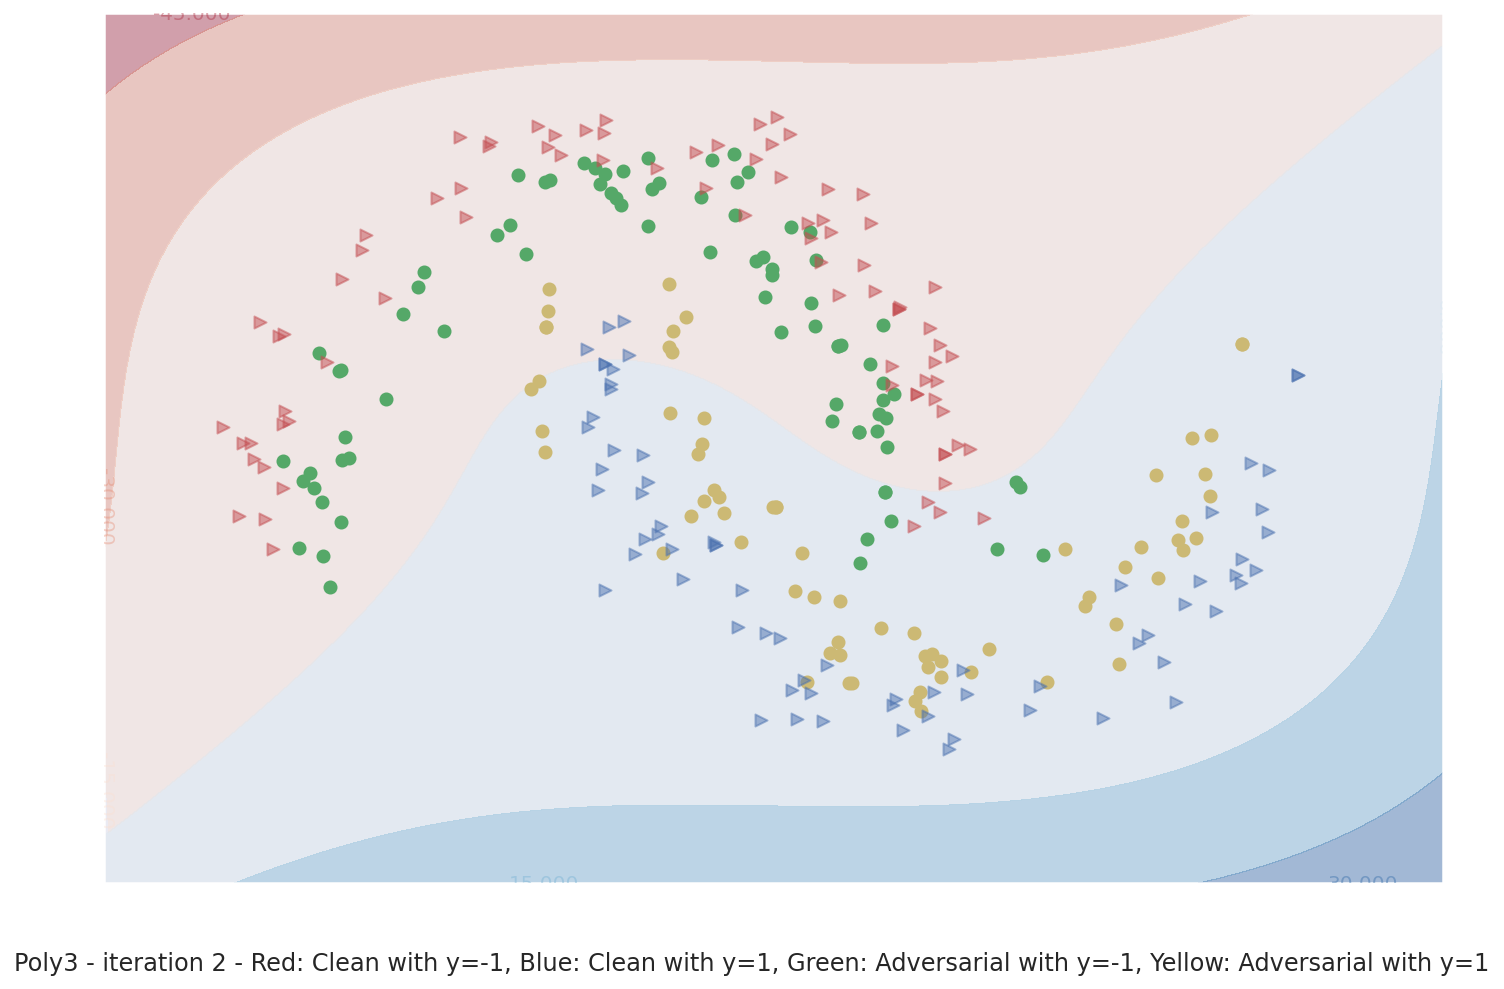

in plot_data


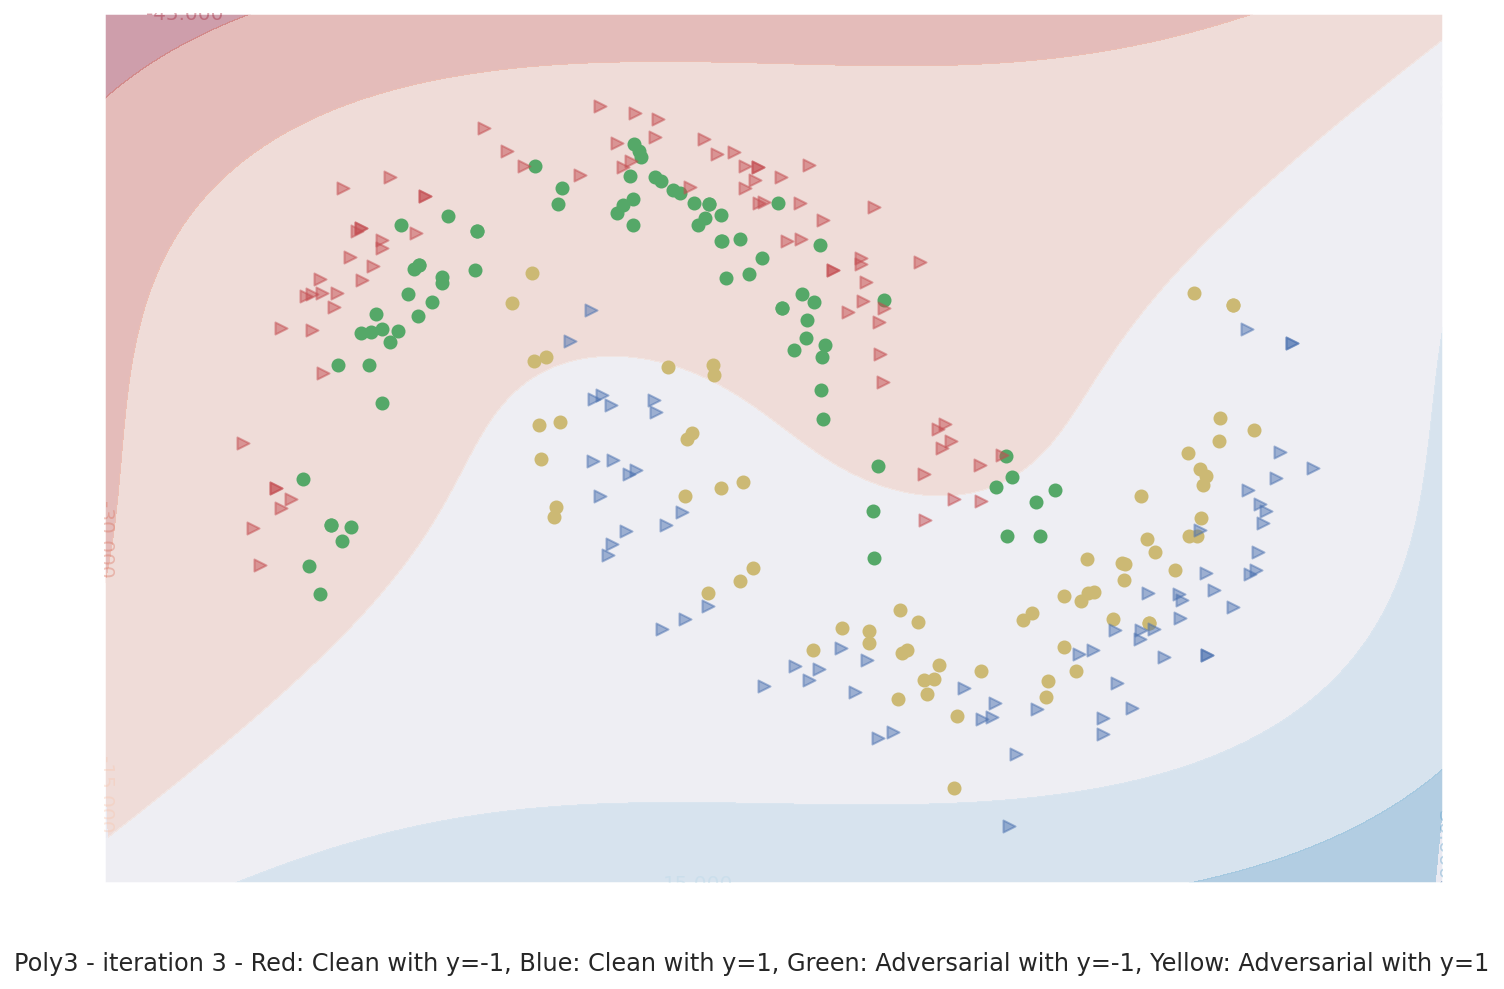

in plot_data


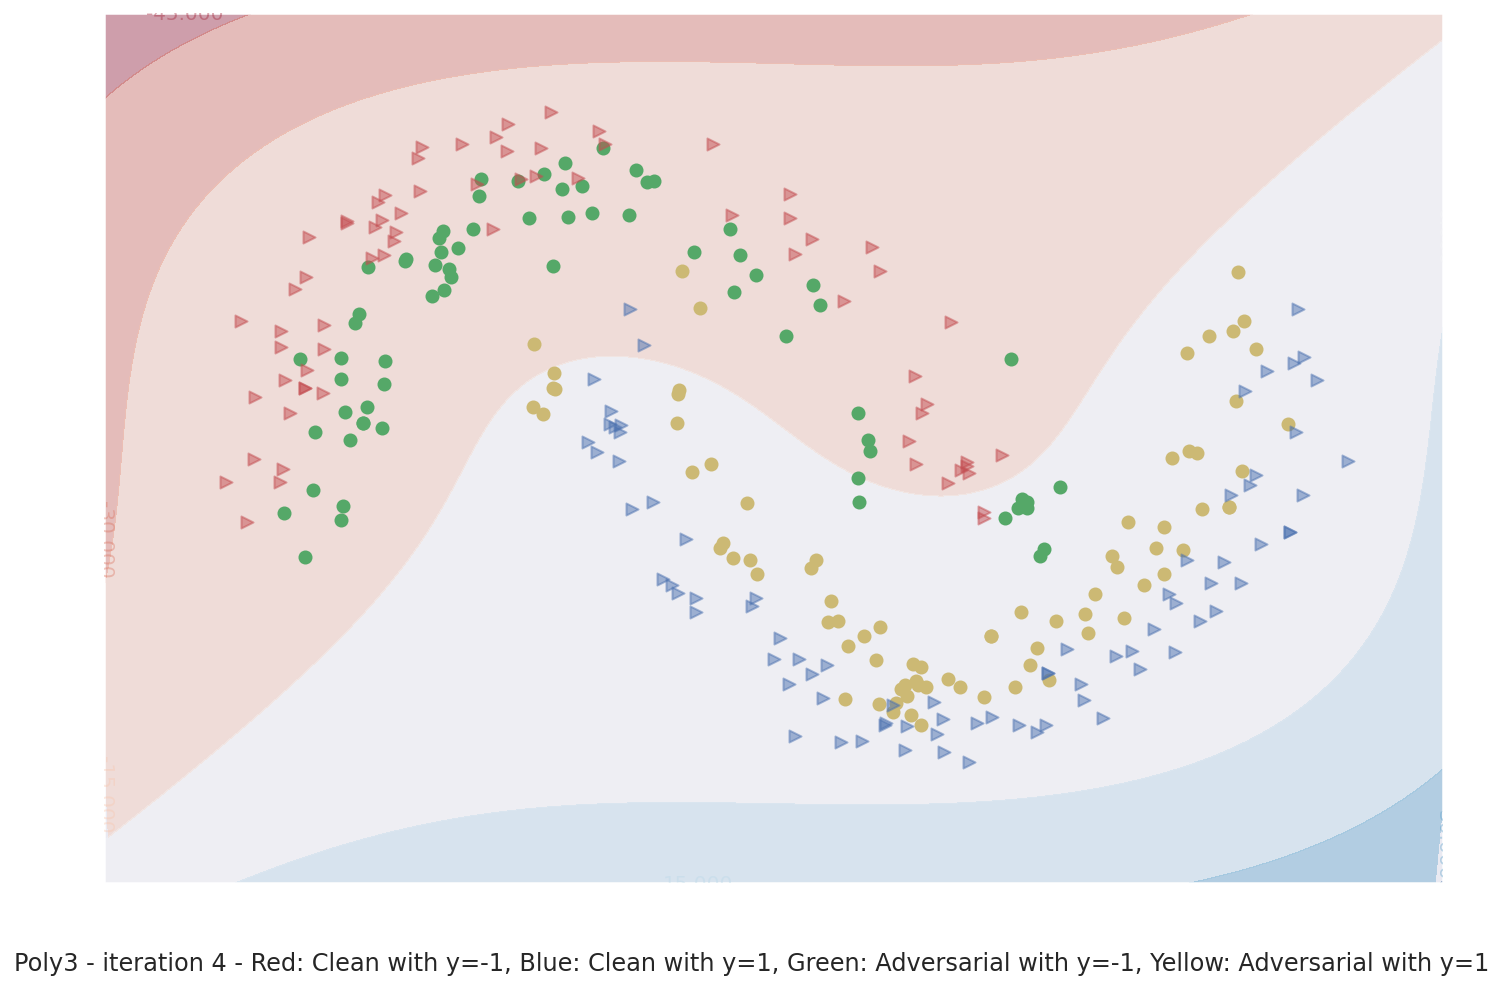

in plot_data


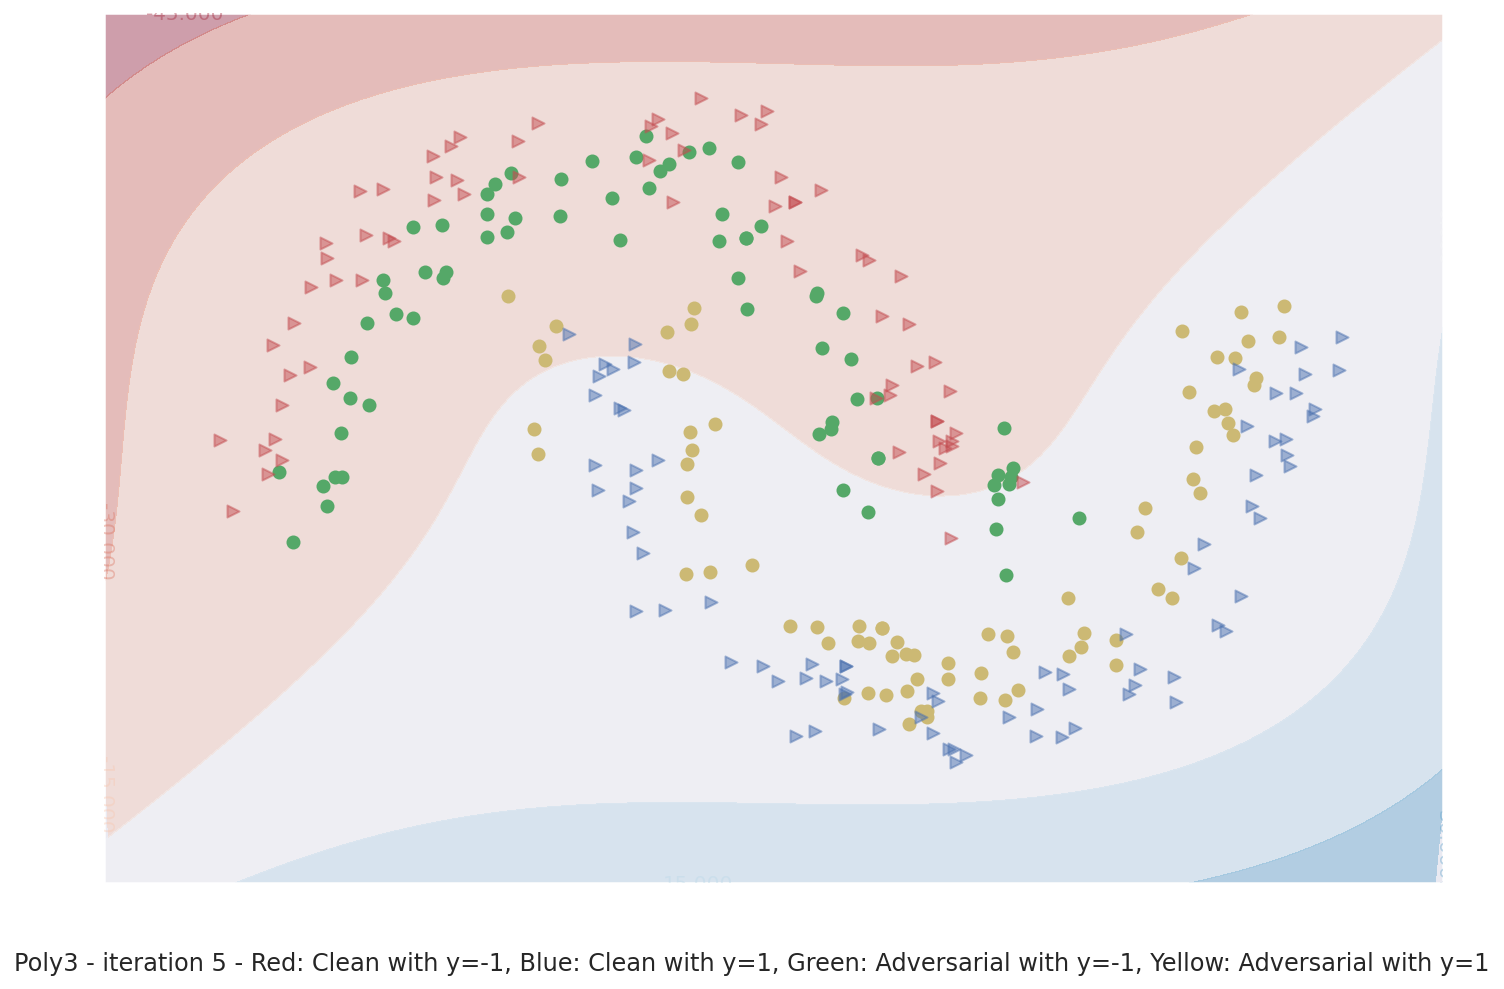

in plot_data_fin


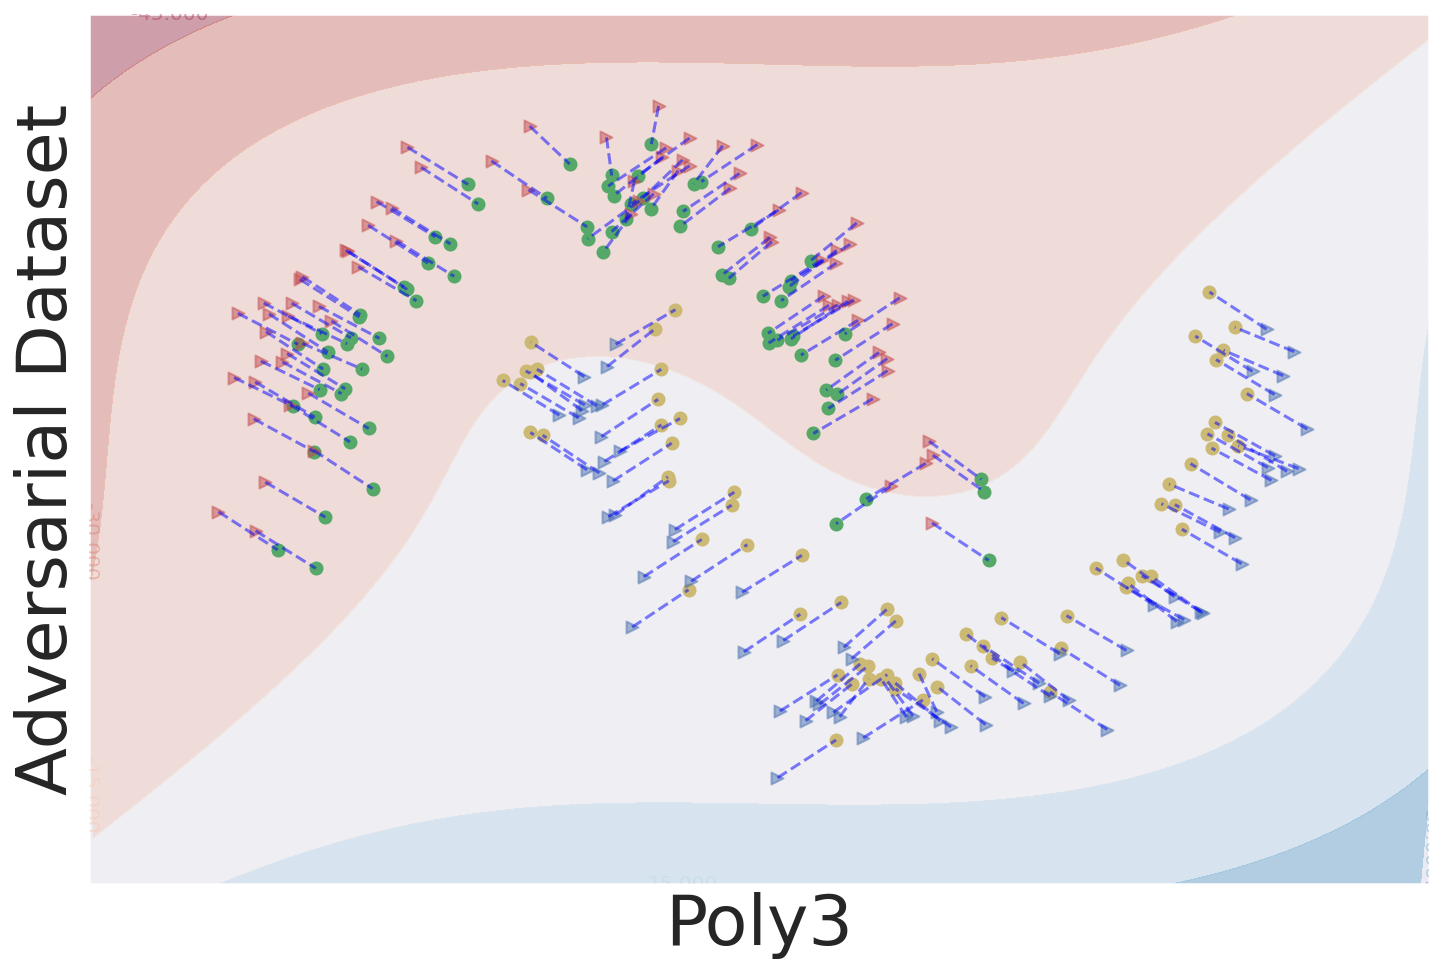

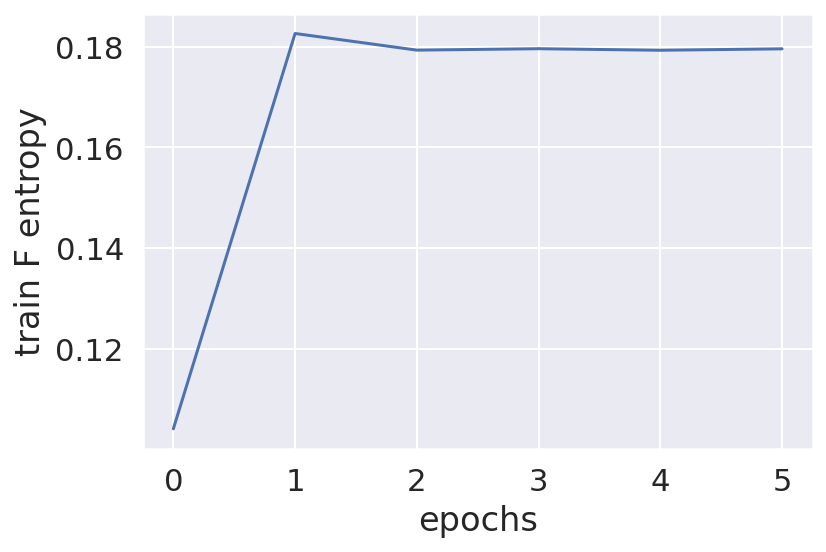

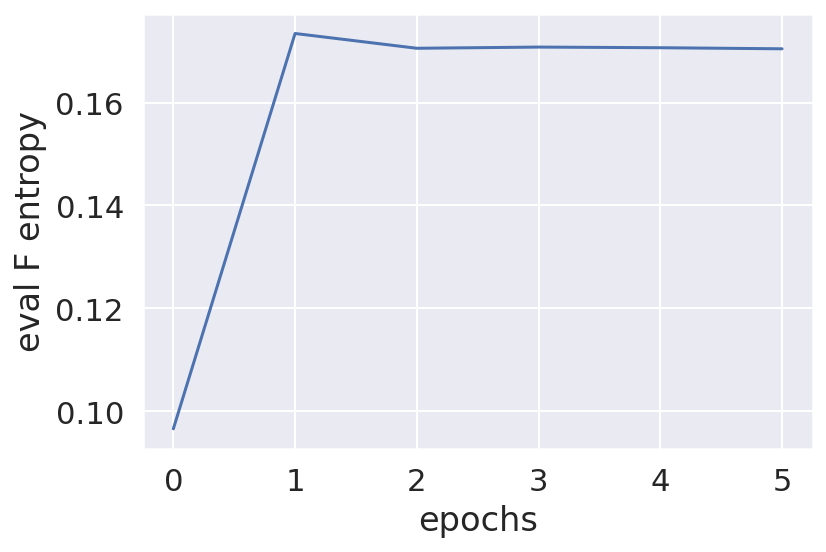

epoch:1000 train_loss:0.1531481295824051
epoch:2000 train_loss:0.12231593579053879
epoch:3000 train_loss:0.10264352709054947
epoch:4000 train_loss:0.08850418031215668
in plot_data


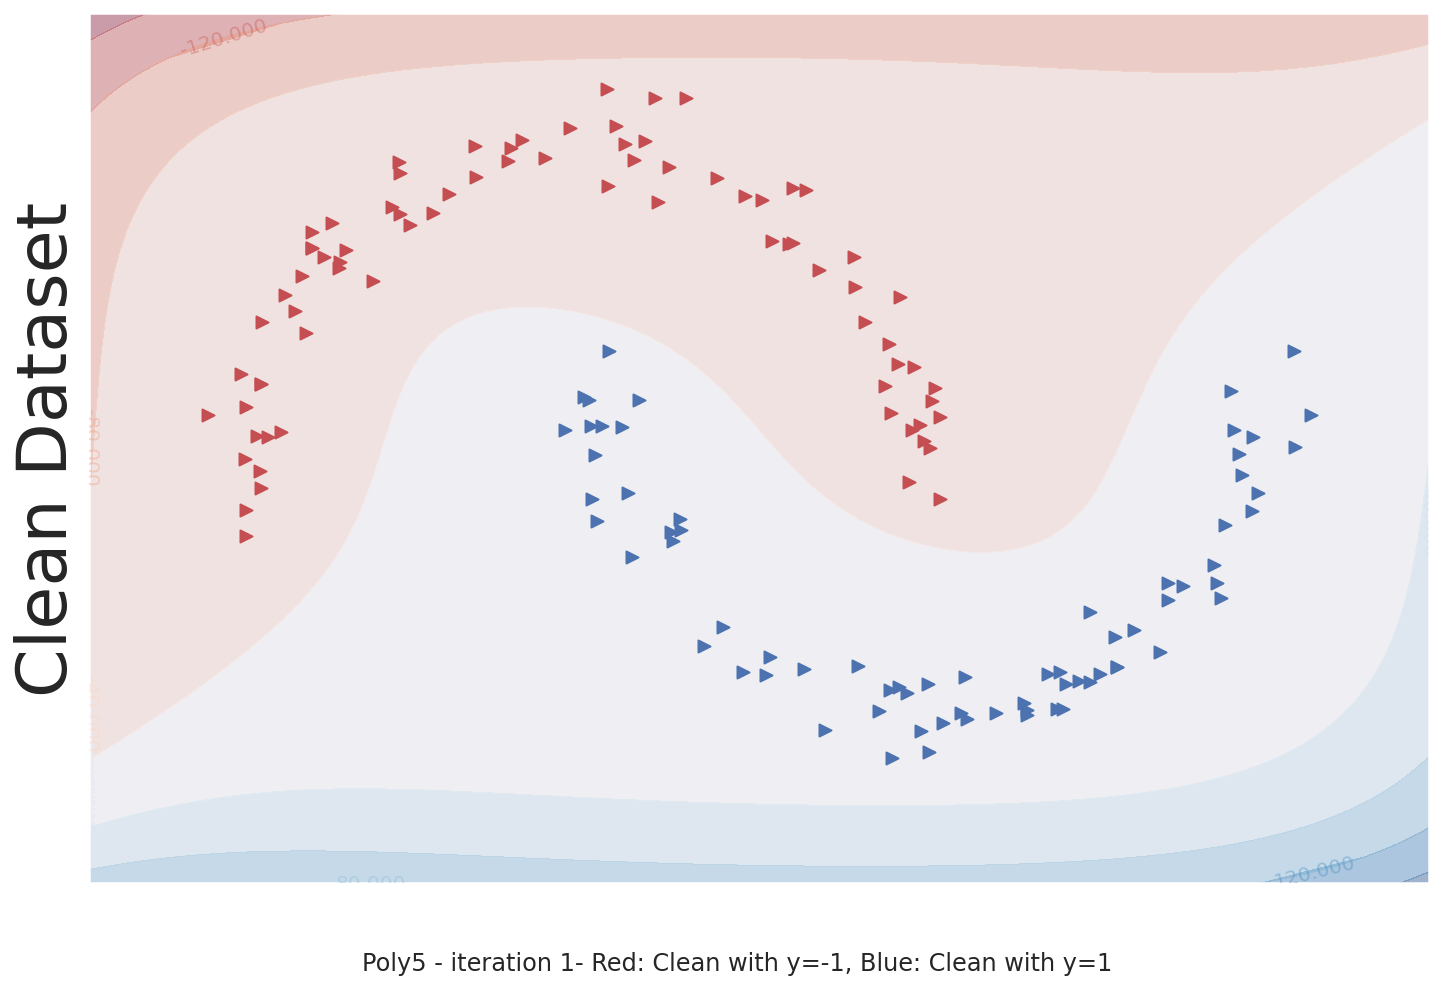

in plot_data


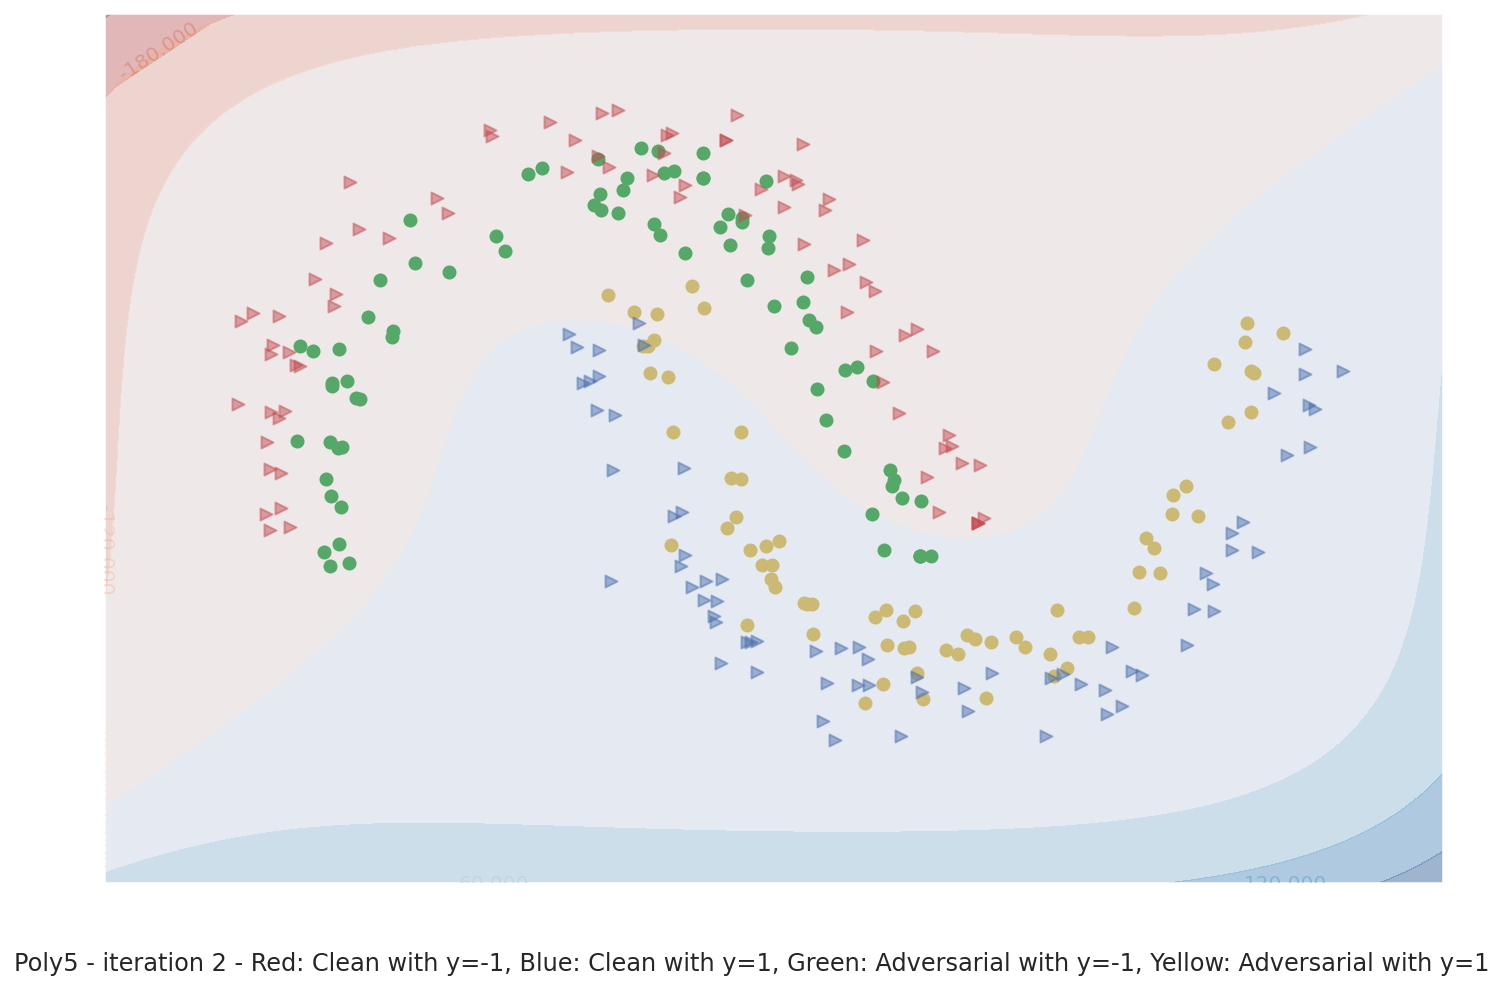

in plot_data


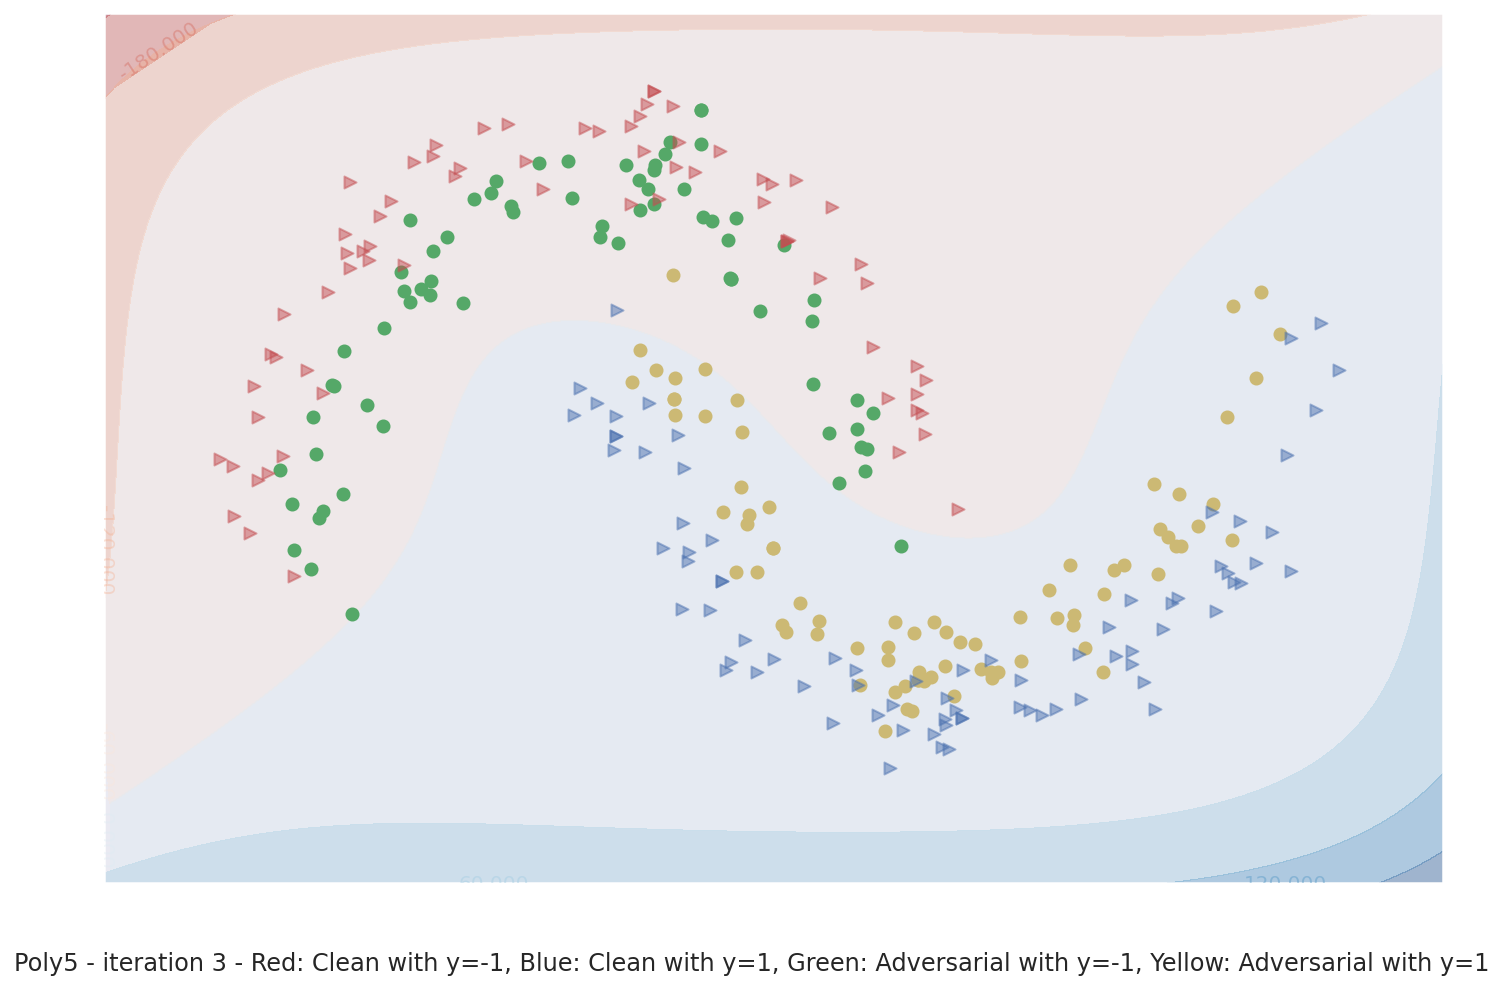

in plot_data


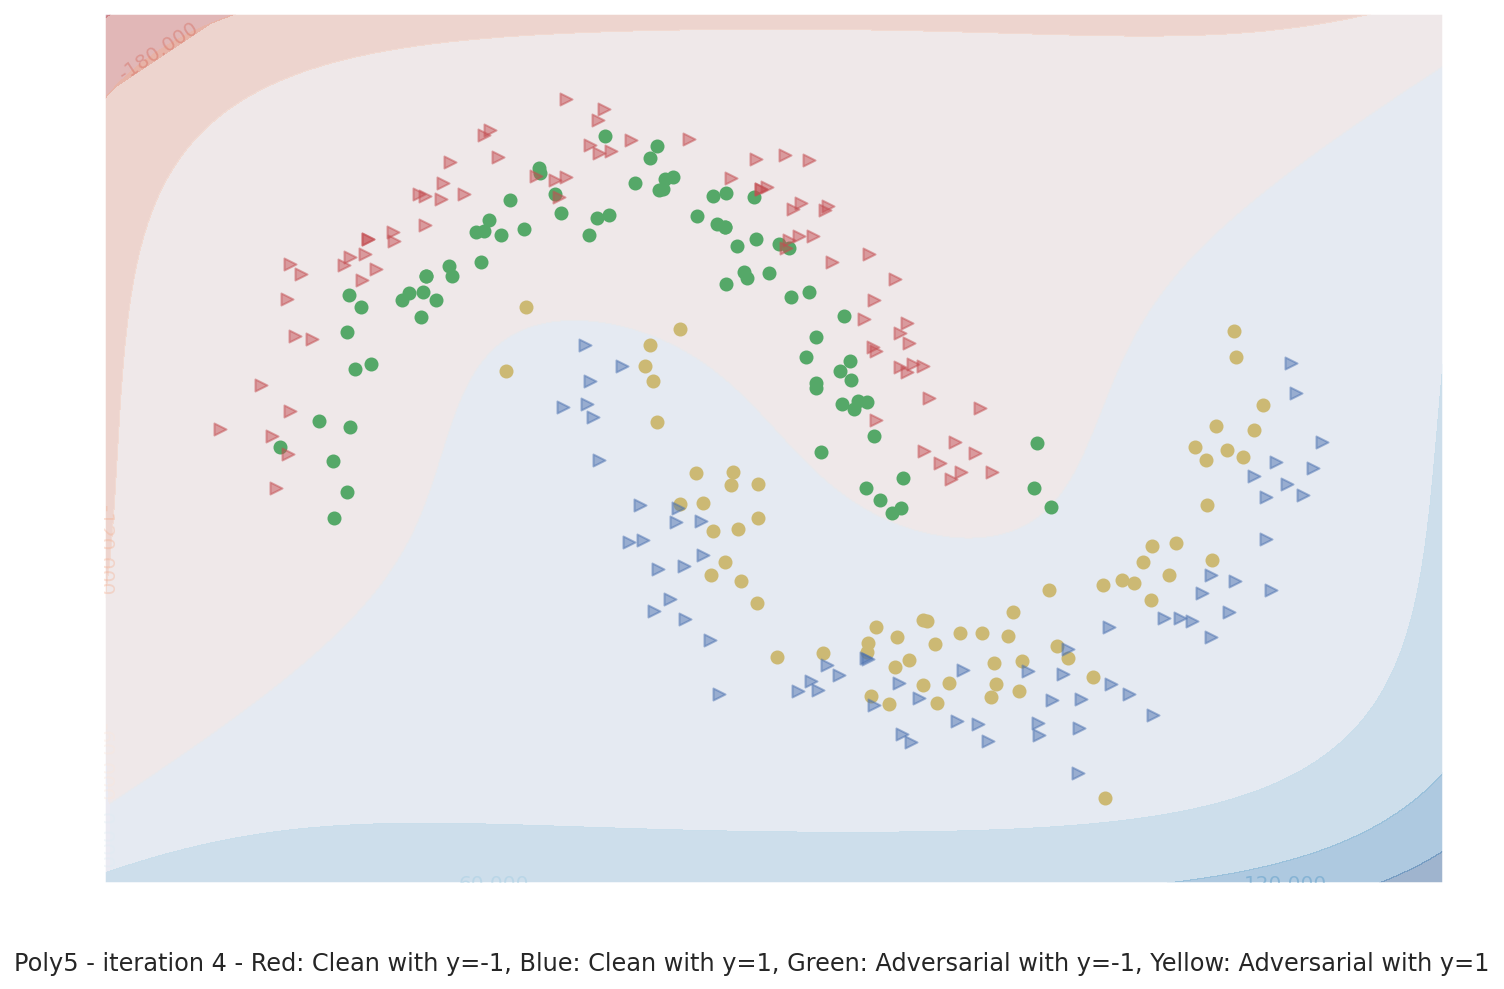

in plot_data


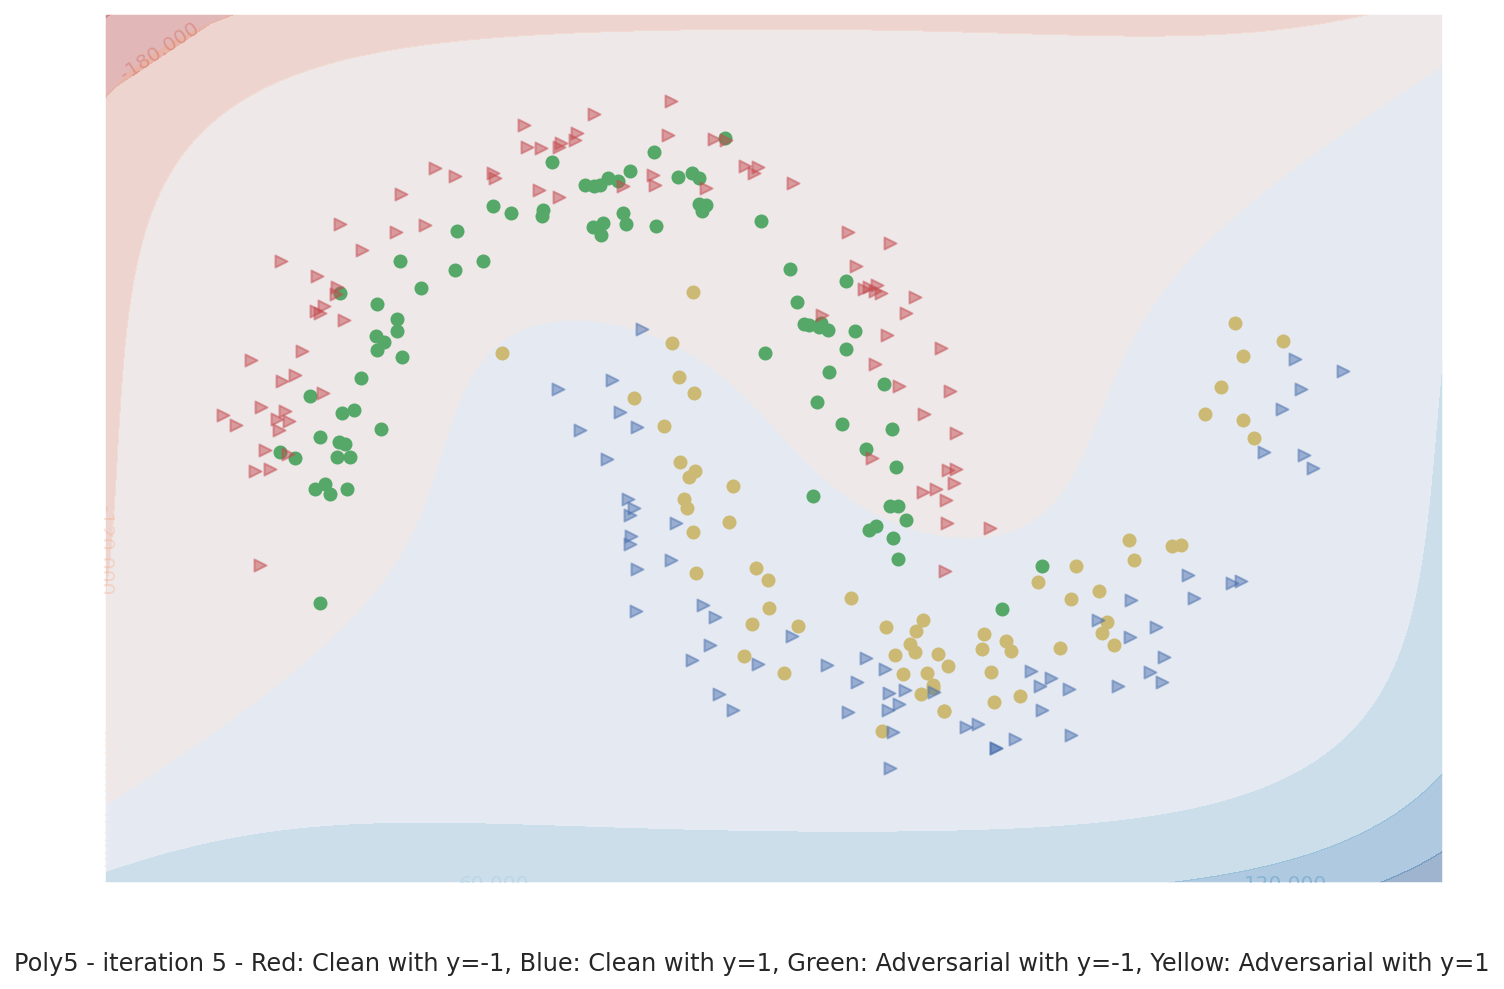

in plot_data_fin


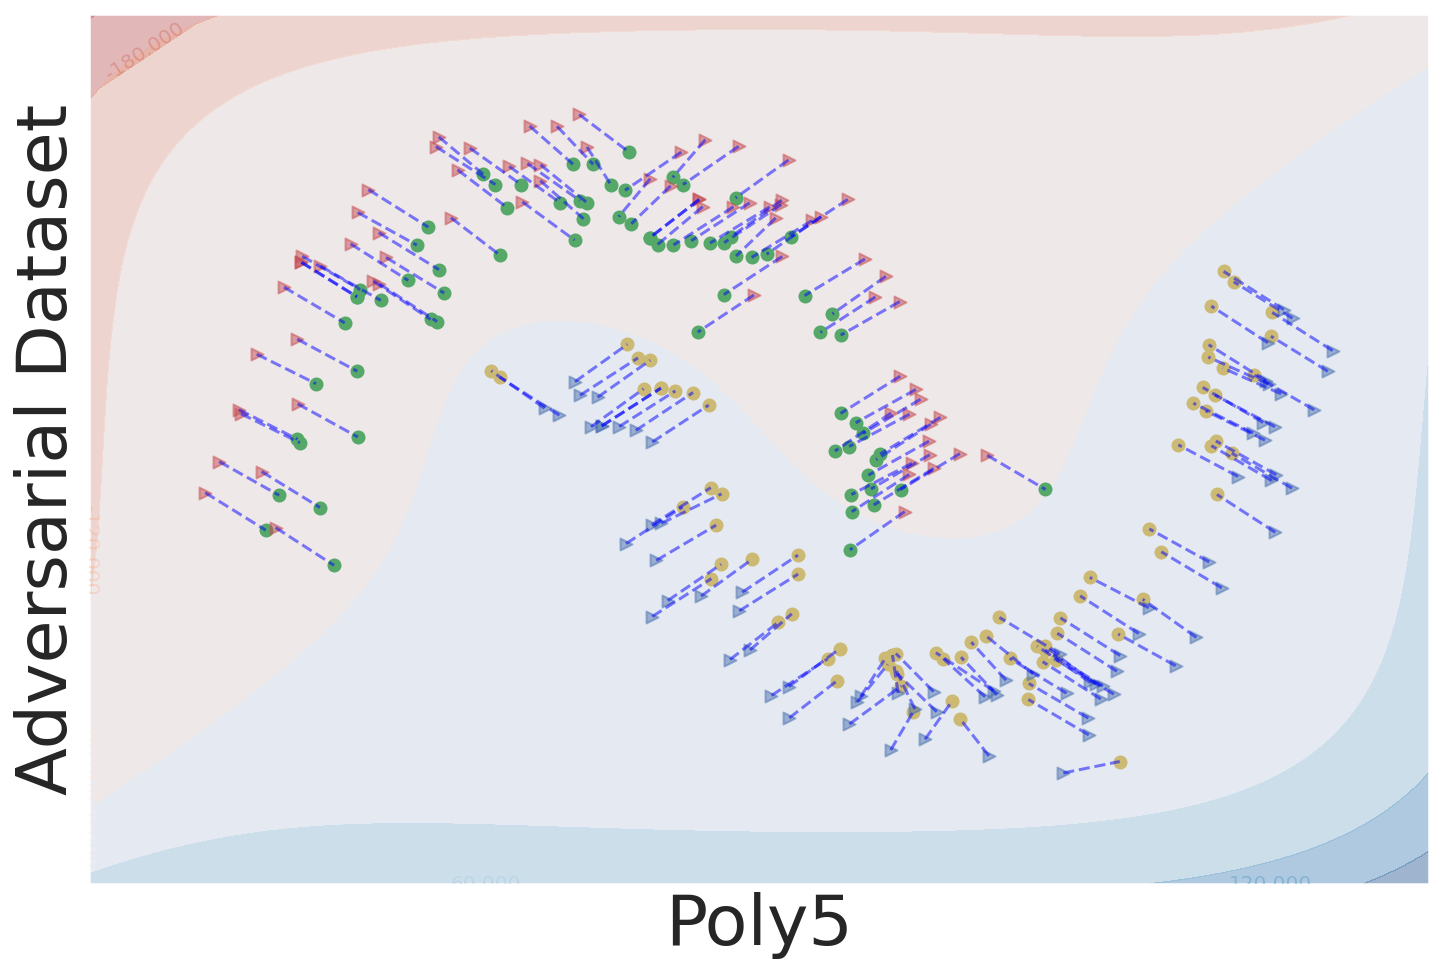

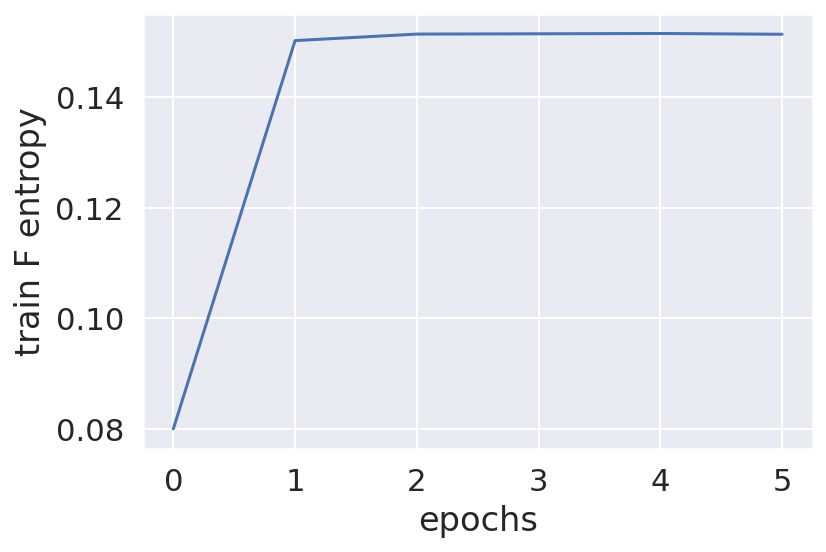

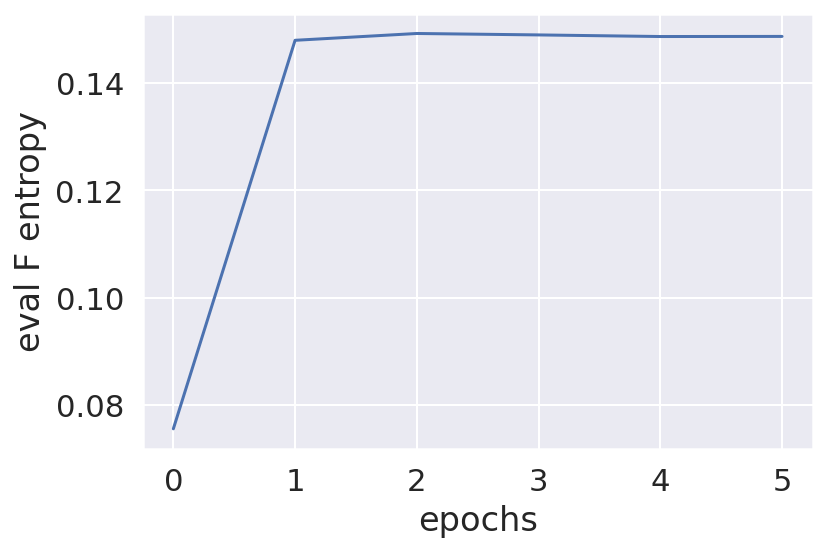

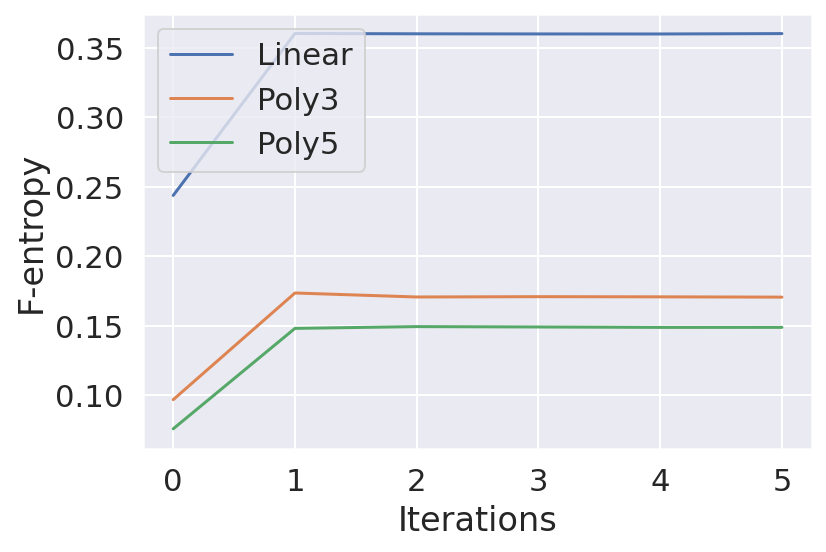

In [11]:
def main():

  np.random.seed(0)
  torch.manual_seed(0)

  ### -------- LINEAR --------------- ###
  args={}
  args['outer_epochs'] = 6
  args['eps'] = 0.2
  args['lr'] = 1e-2
  args['n_samples'] = 500
  args['stop_treshold'] = 1e-5
  args['norm'] = 'L_inf'
  args['name'] = 'Linear'


  X_train, y_train, X_eval, y_eval = create_dataloaders(4000)
  critic = Critic_Linear(2)
  train_entropies_linear, eval_entropies_linear = train(critic, X_train, y_train, X_eval, y_eval, args, 'prop3')

  ### -------- POLY3 --------------- ###
  args={}
  args['outer_epochs'] = 6
  args['eps'] = 0.2
  args['lr'] = 1e-2
  args['n_samples'] = 500
  args['stop_treshold'] = 1e-5
  args['degree'] = 3
  args['norm'] = 'L_inf'
  args['name'] = 'Poly3'
  
  X_train, y_train, X_eval, y_eval = create_dataloaders(4000)
  critic = Critic_Poly(2, args['degree'])
  train_entropies_poly3, eval_entropies_poly3 = train(critic, X_train, y_train, X_eval, y_eval, args, 'prop3')


  ### -------- POLY5 --------------- ###
  args={}
  args['outer_epochs'] = 6
  args['eps'] = 0.2
  args['lr'] = 1e-2
  args['n_samples'] = 500
  args['stop_treshold'] = 1e-5
  args['degree'] = 5
  args['norm'] = 'L_inf'
  args['name'] = 'Poly5'
  
  X_train, y_train, X_eval, y_eval = create_dataloaders(4000)
  critic = Critic_Poly(2, args['degree'])
  train_entropies_poly5, eval_entropies_poly5 = train(critic, X_train, y_train, X_eval, y_eval, args, 'prop3')
  
  plot_entropies(eval_entropies_linear, eval_entropies_poly3, eval_entropies_poly5, args['norm'])
if __name__ == '__main__':
  main()


# Test with $L_2$

In the following cell, the $\epsilon$-neighborhood around each point is calculated with respect to the $L_2$ norm.

epoch:1000 train_loss:0.2967544198036194
epoch:2000 train_loss:0.2665540874004364
in plot_data


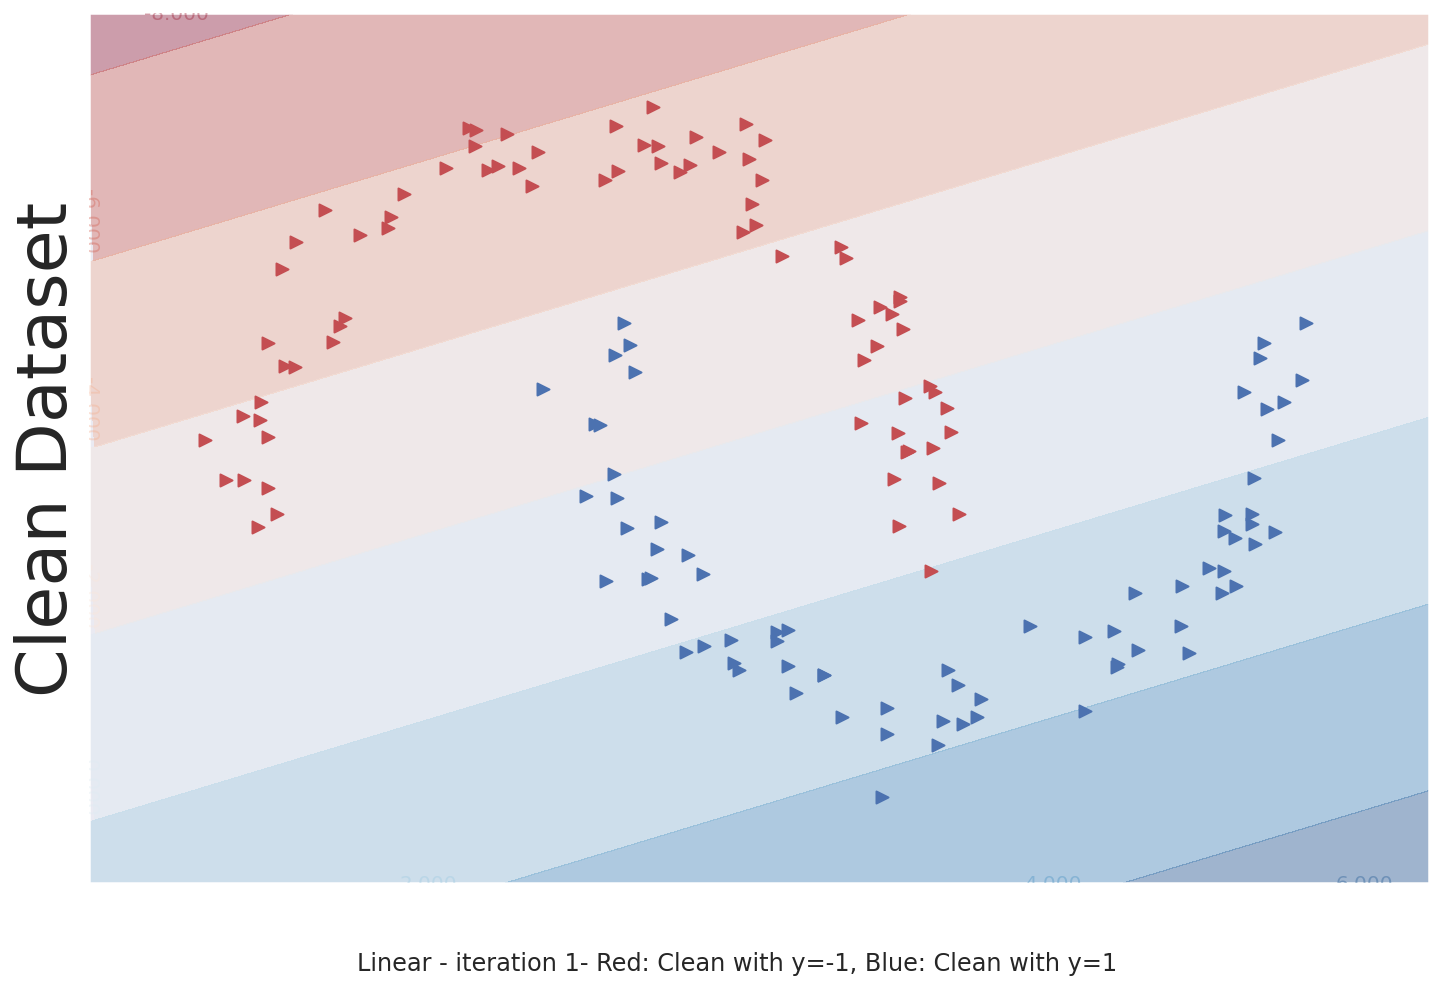

in plot_data


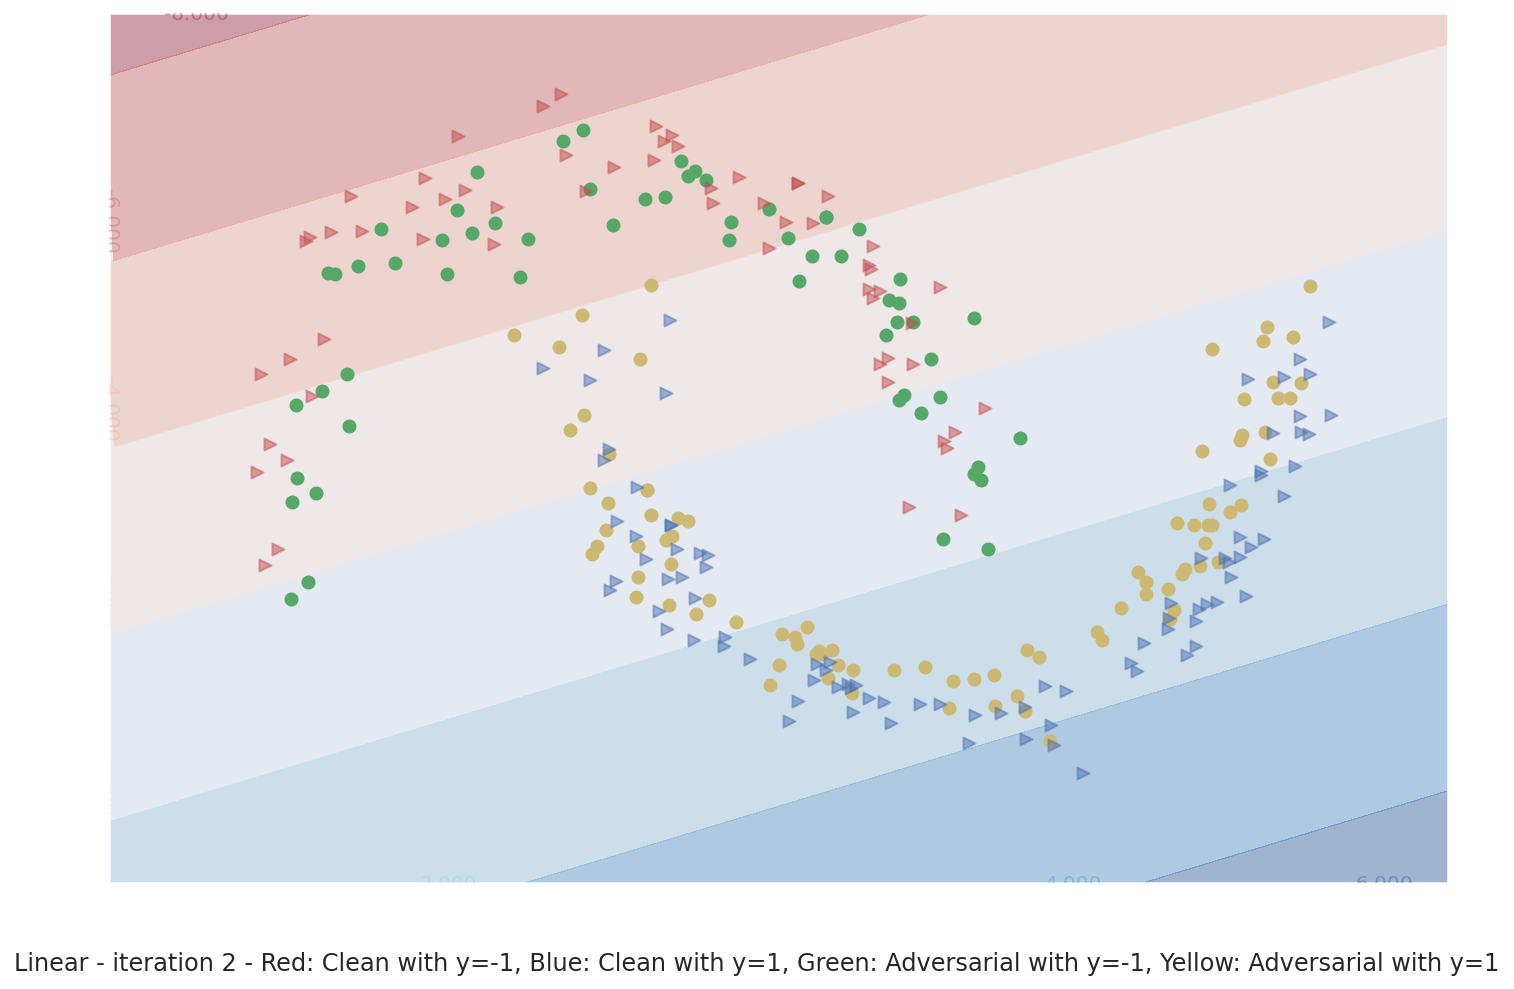

in plot_data


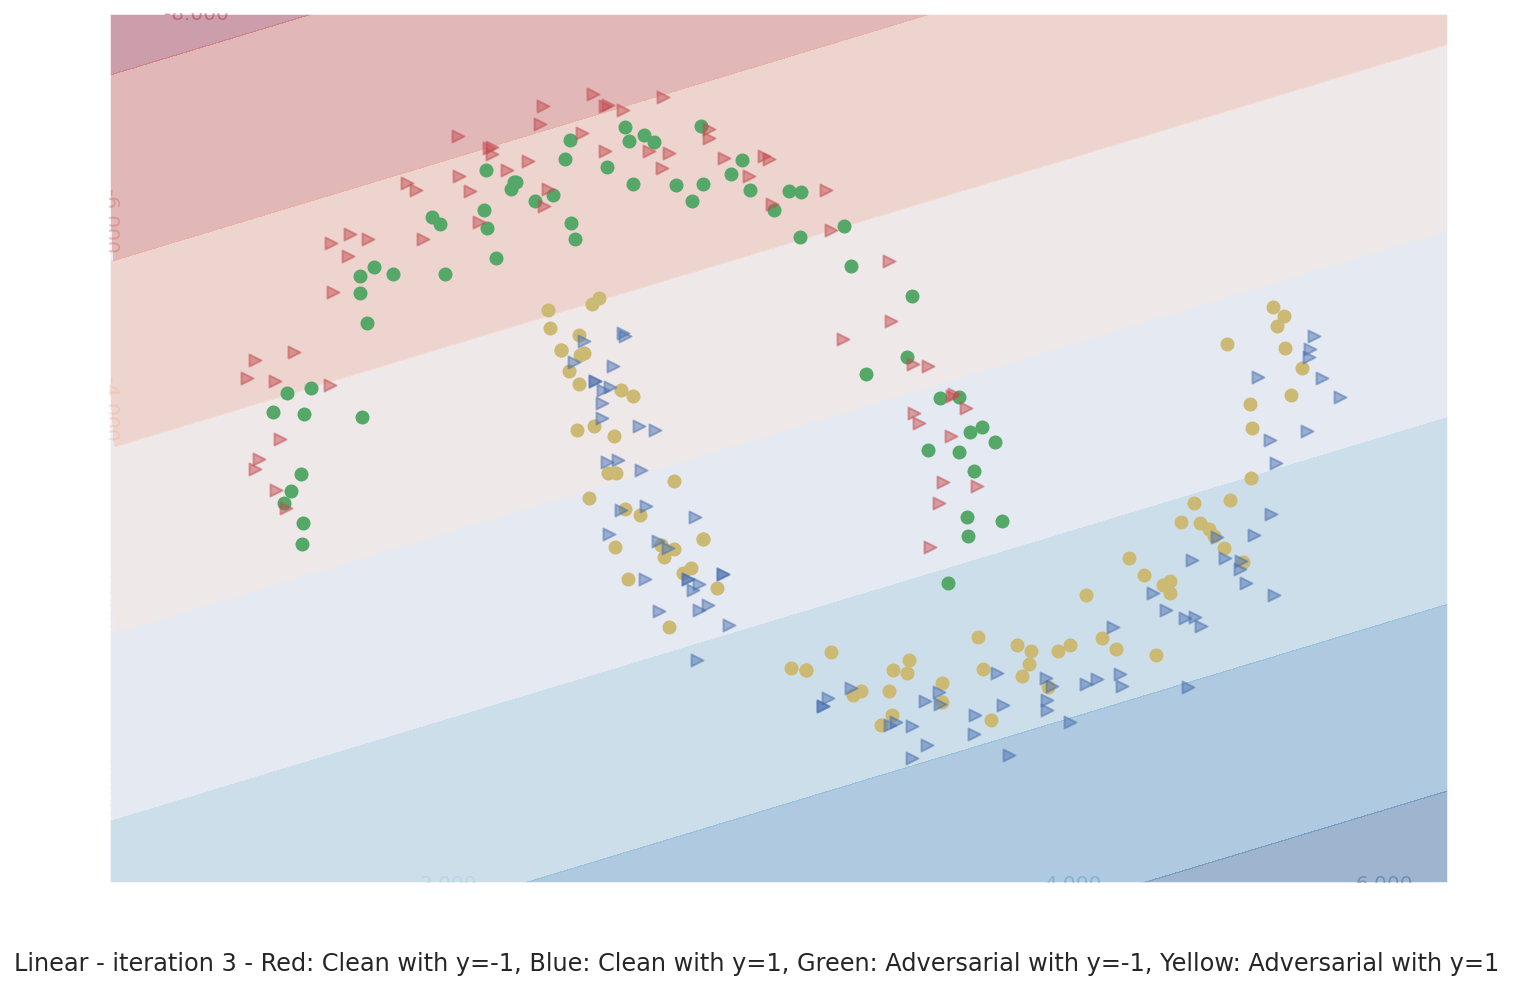

in plot_data


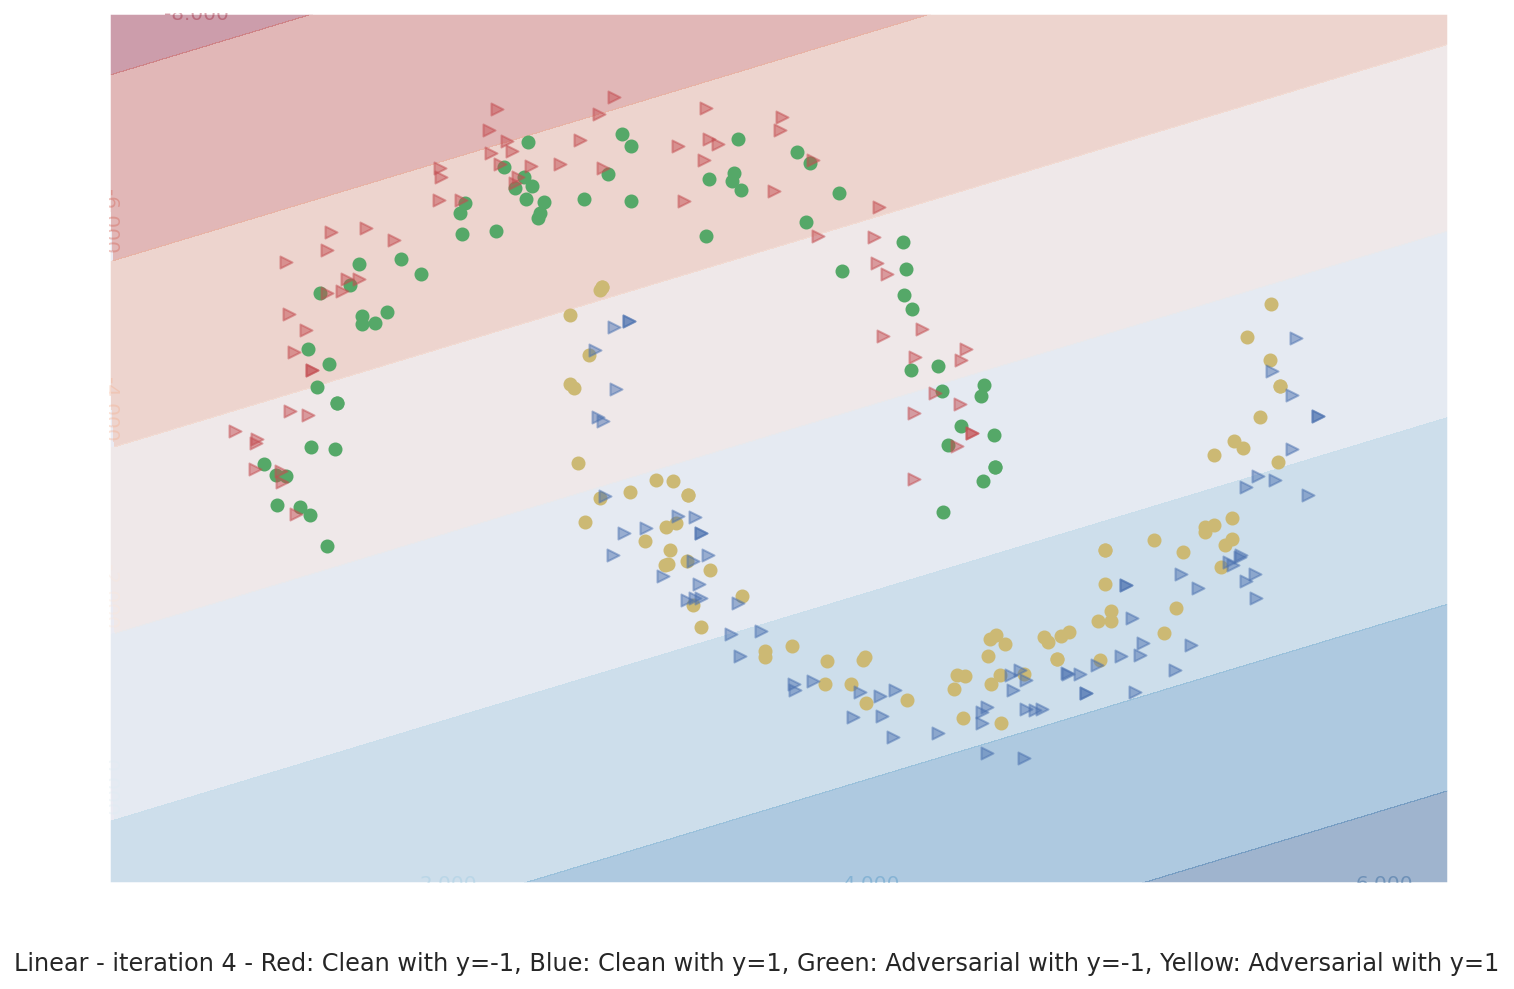

in plot_data


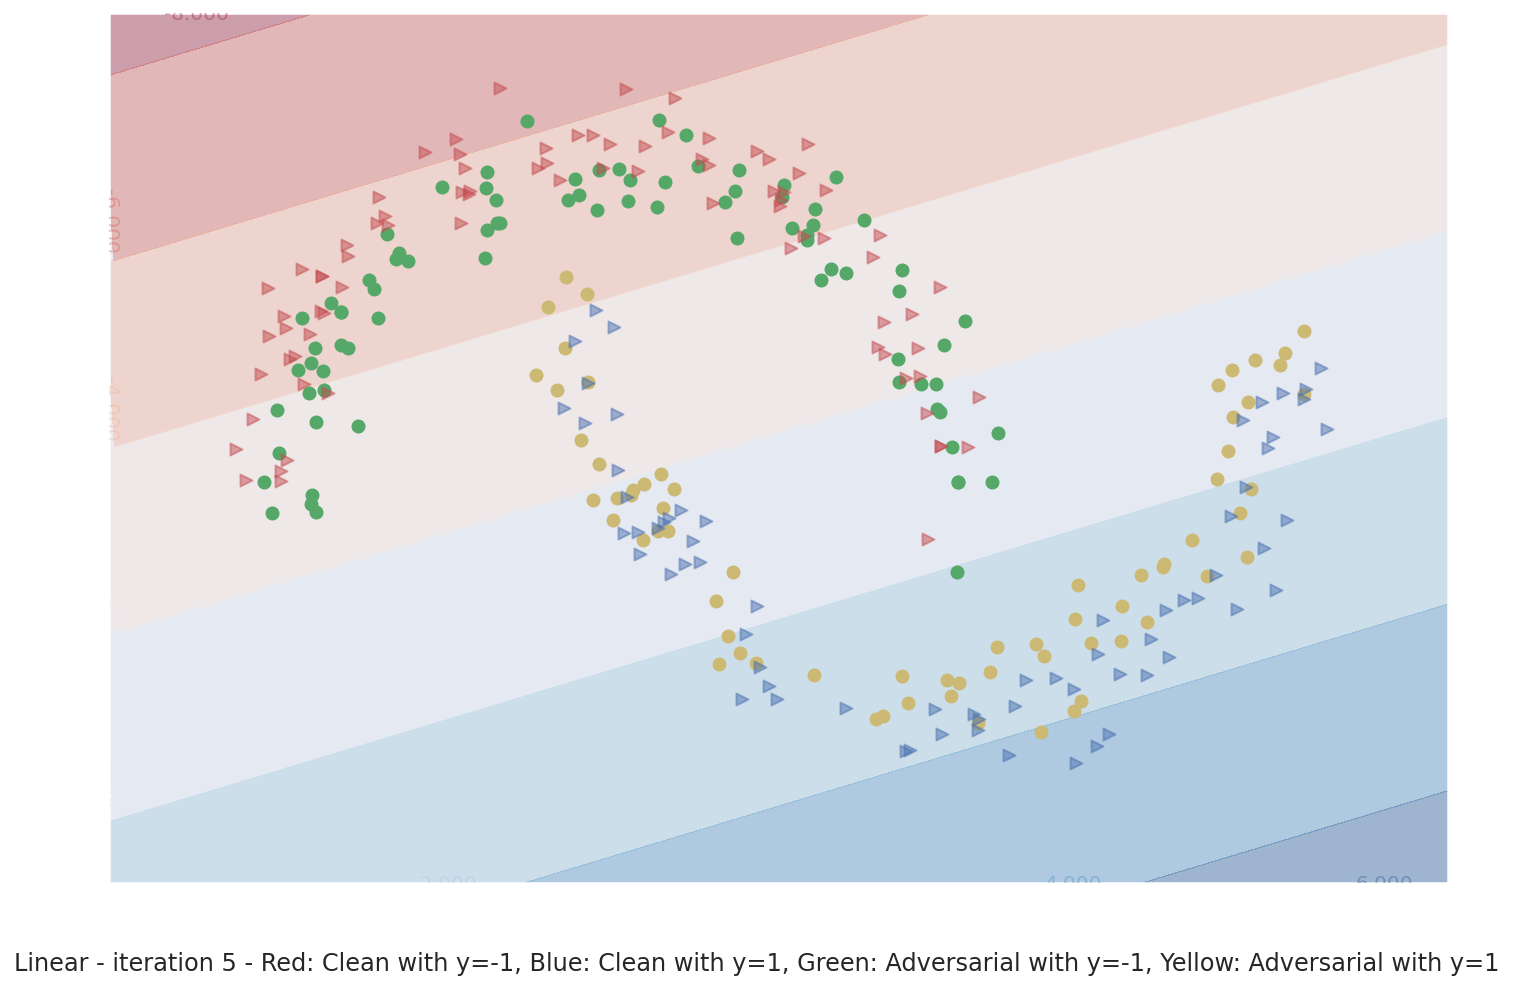

in plot_data_fin


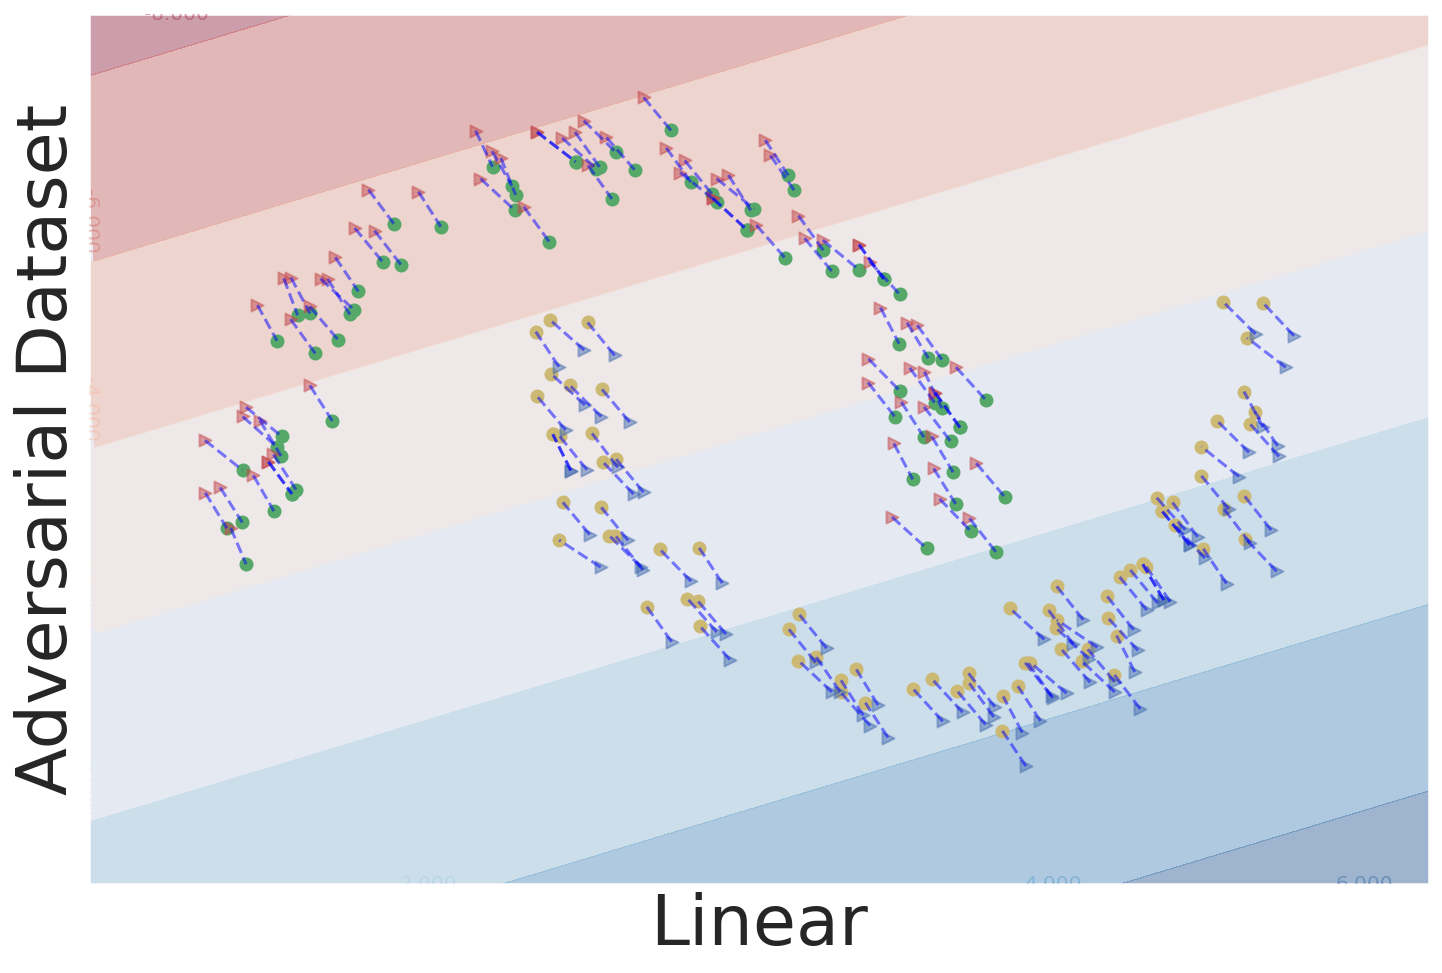

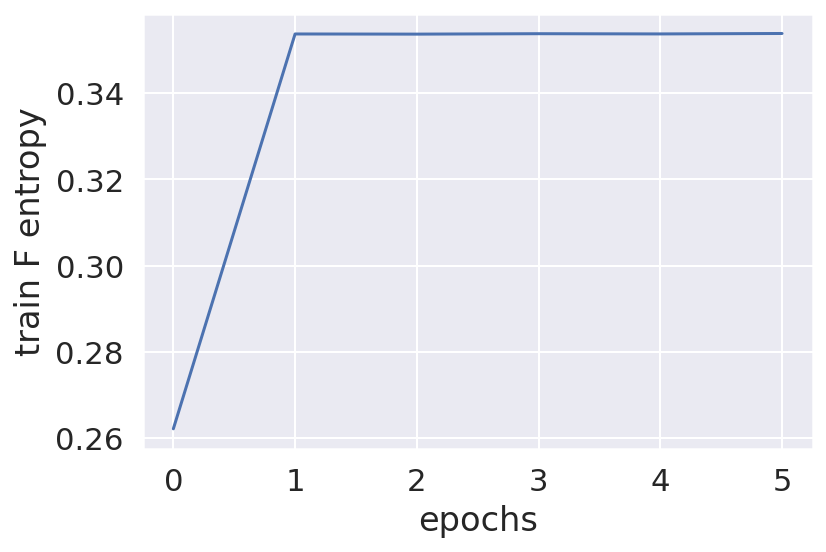

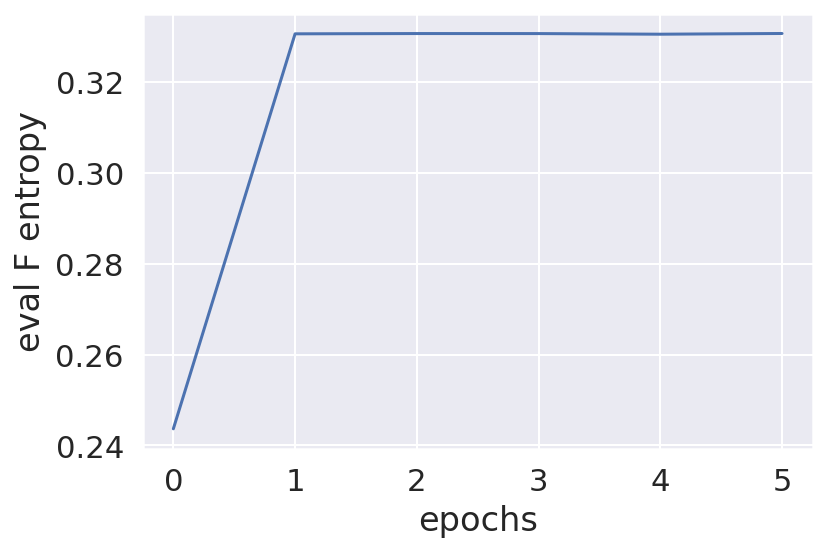

epoch:1000 train_loss:0.19328927993774414
epoch:2000 train_loss:0.16051220893859863
epoch:3000 train_loss:0.13948163390159607
epoch:4000 train_loss:0.12370192259550095
epoch:5000 train_loss:0.11113826185464859
in plot_data


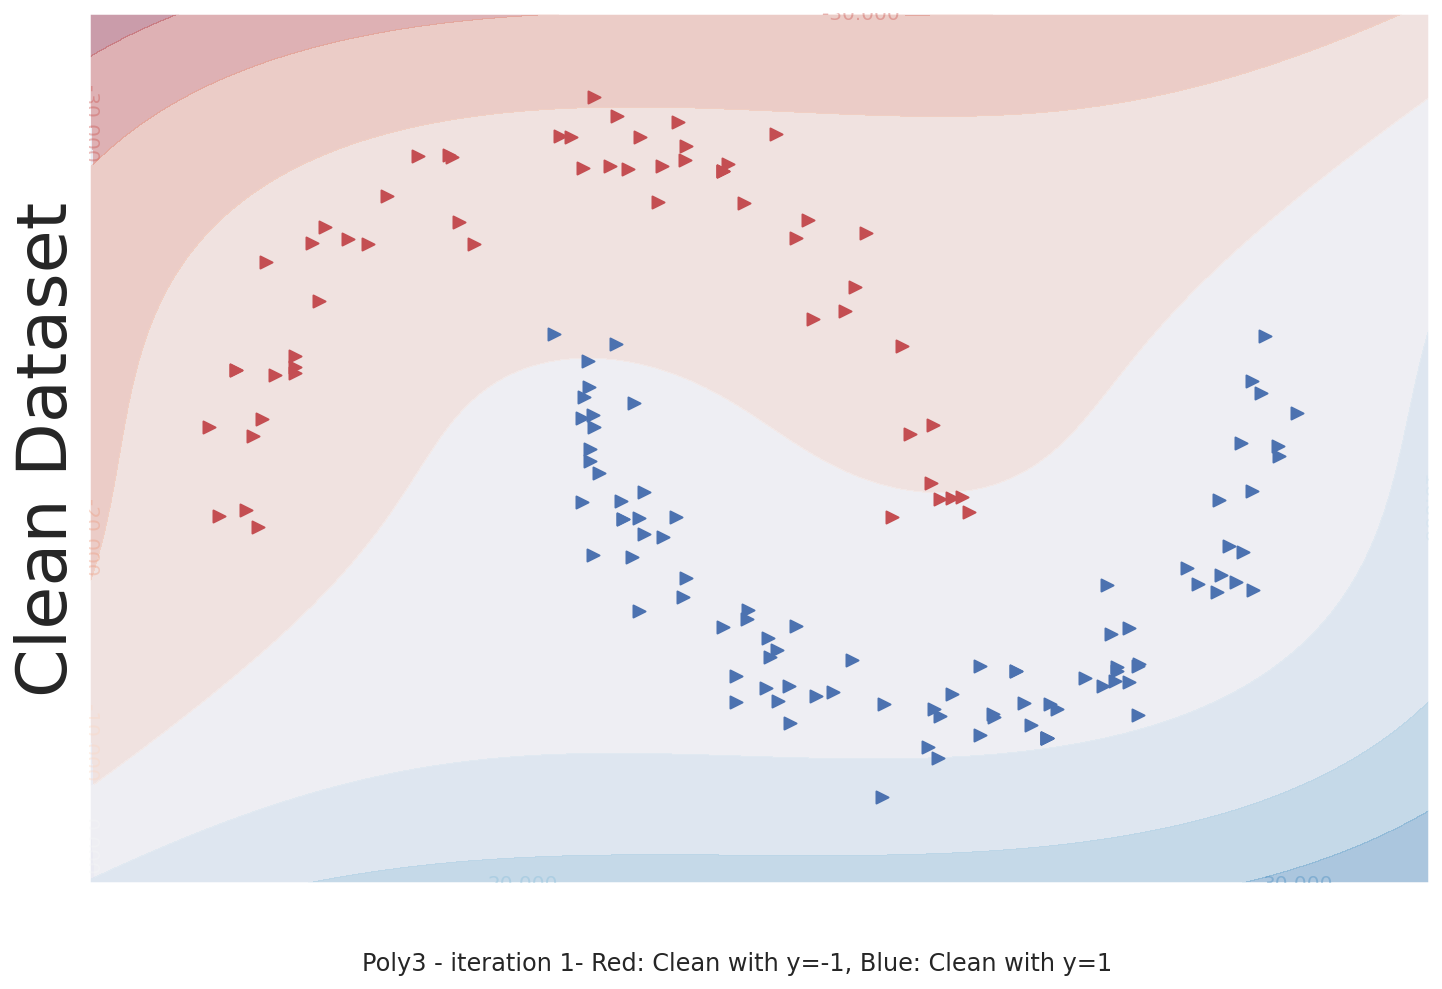

epoch:1000 train_loss:0.15854544937610626
in plot_data


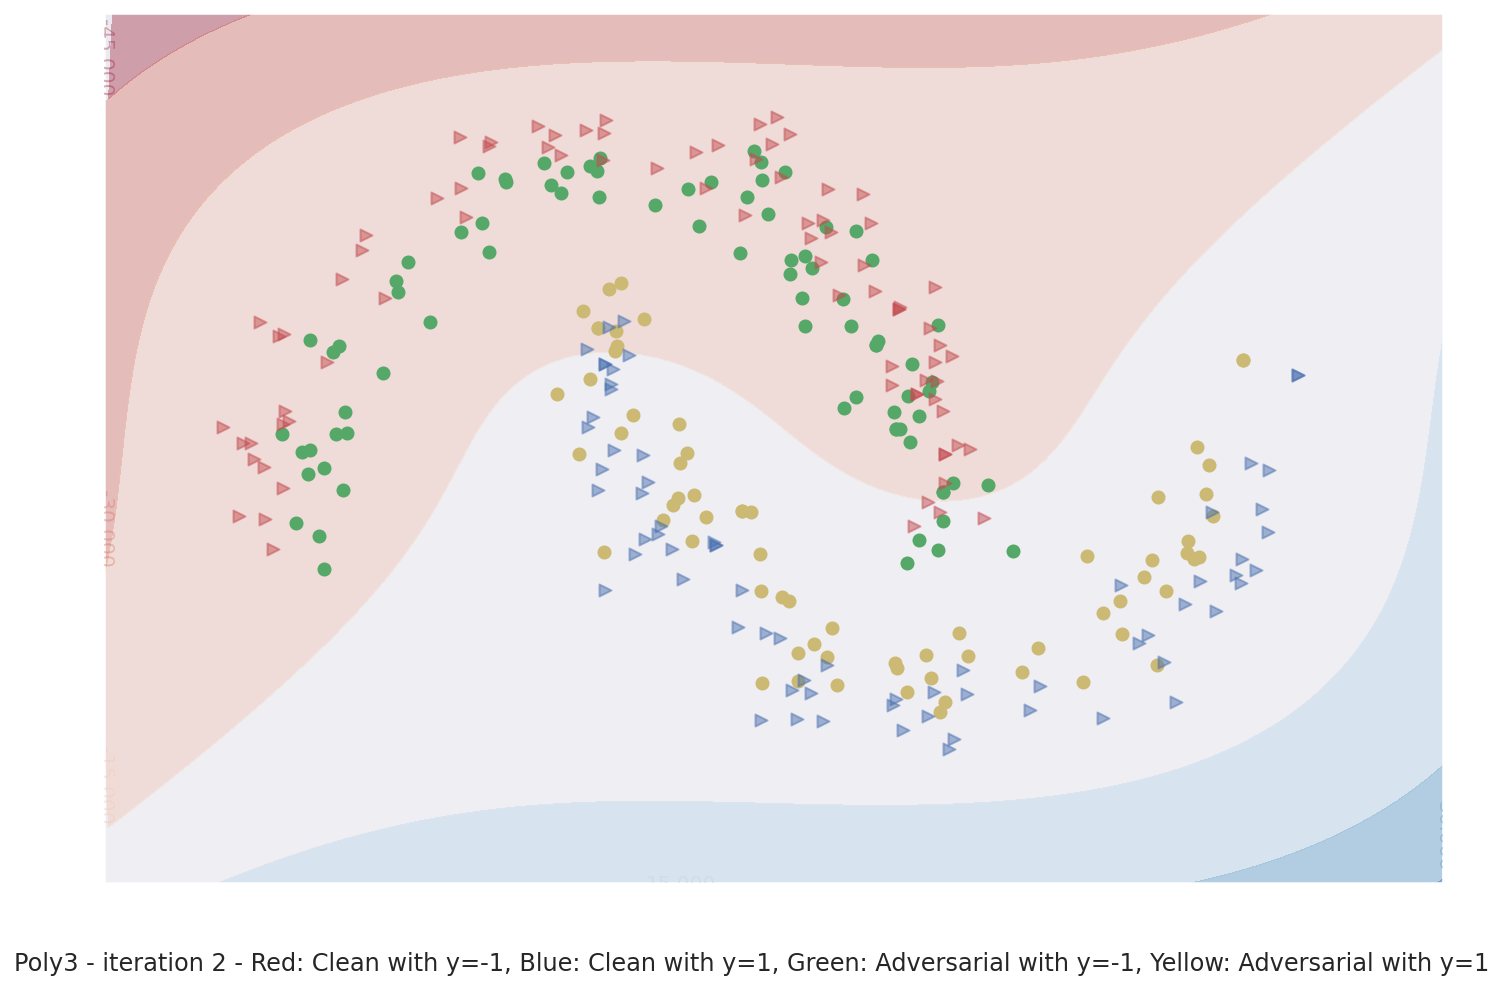

in plot_data


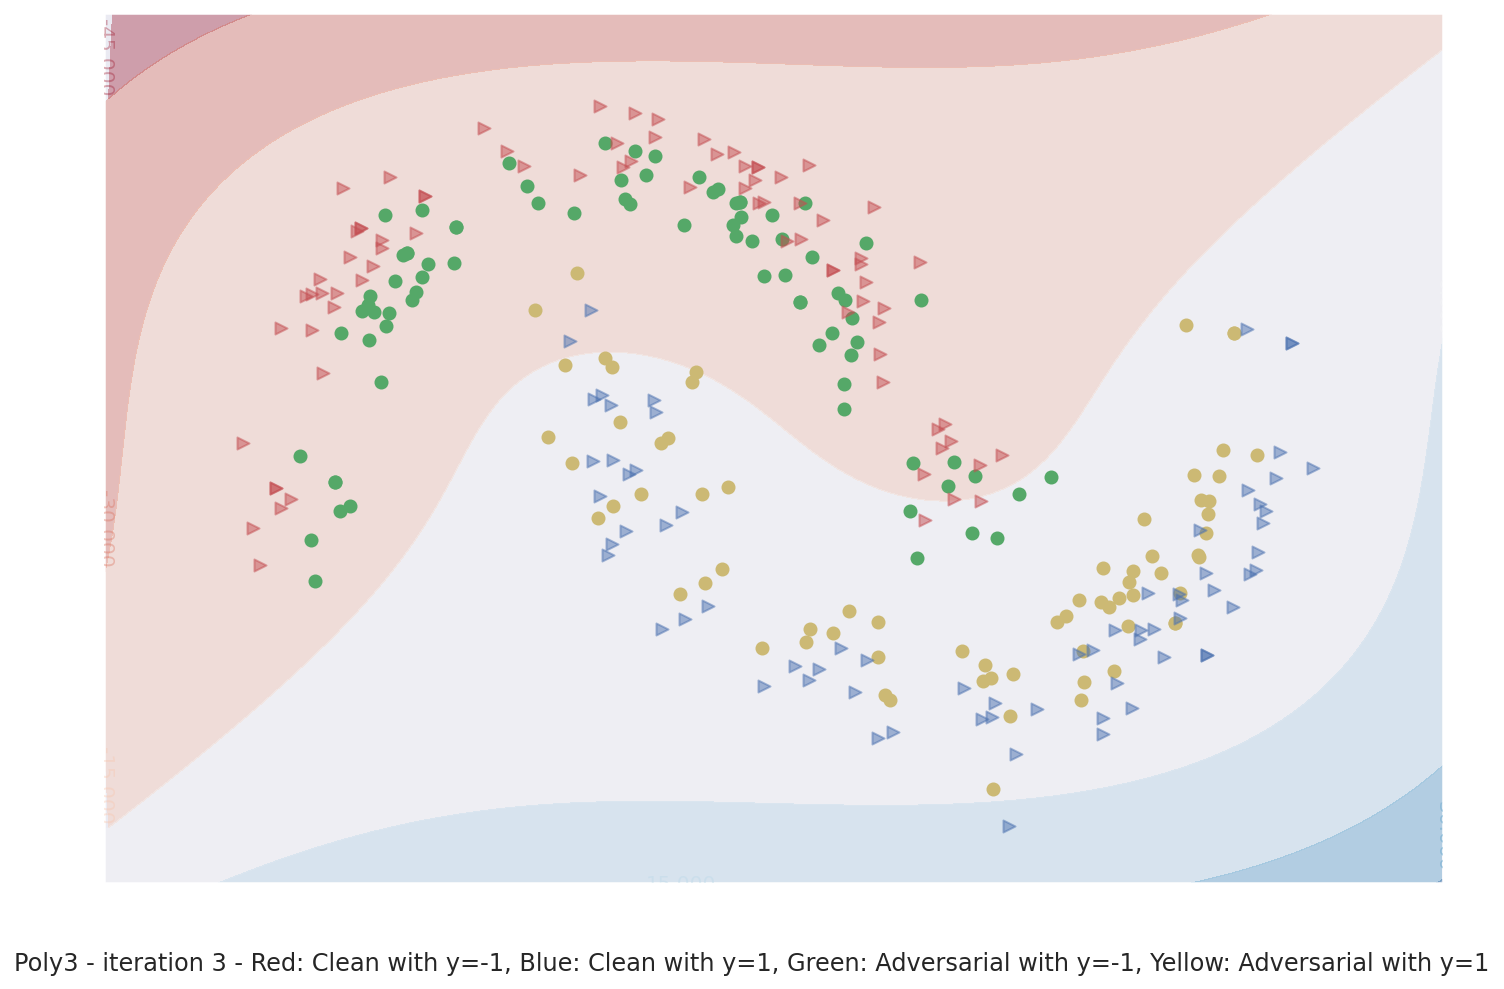

in plot_data


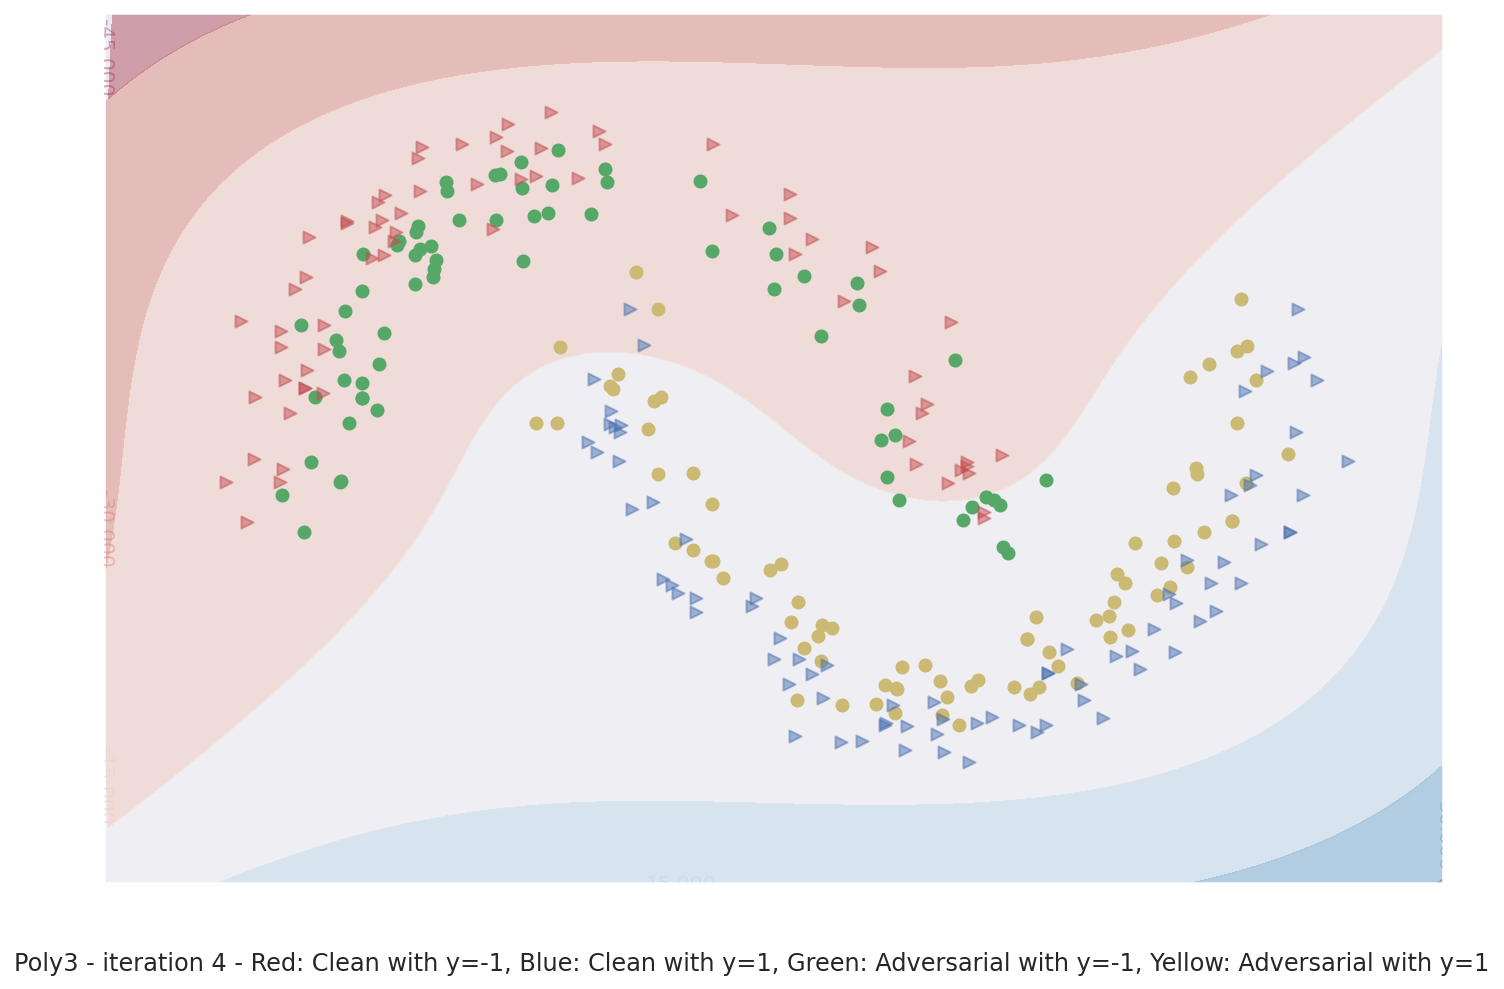

in plot_data


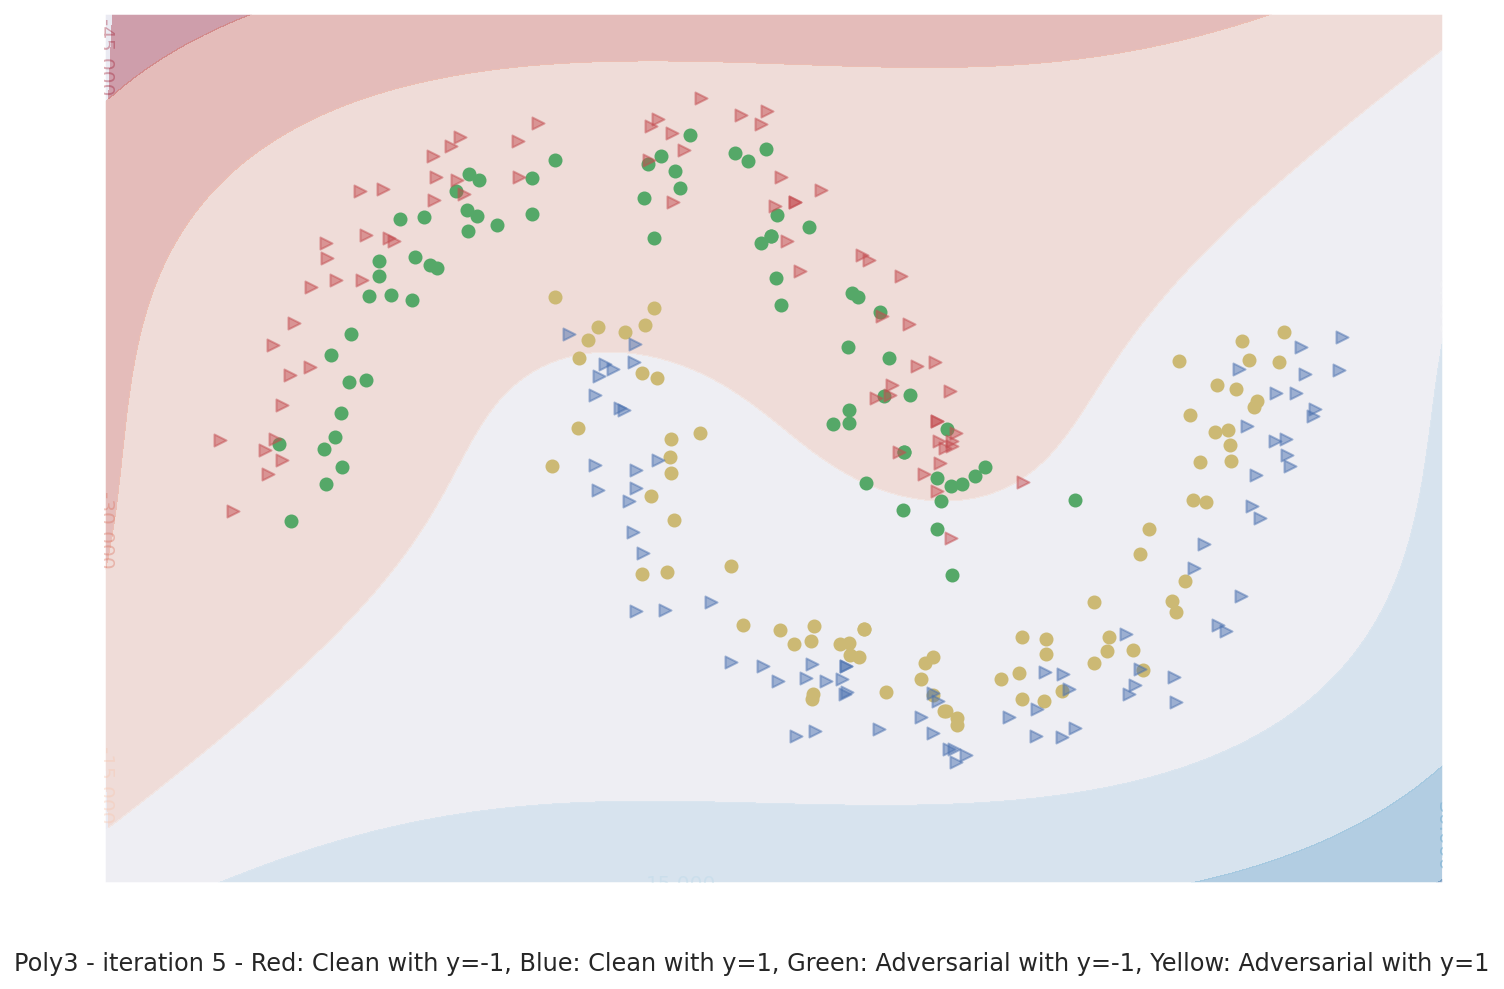

in plot_data_fin


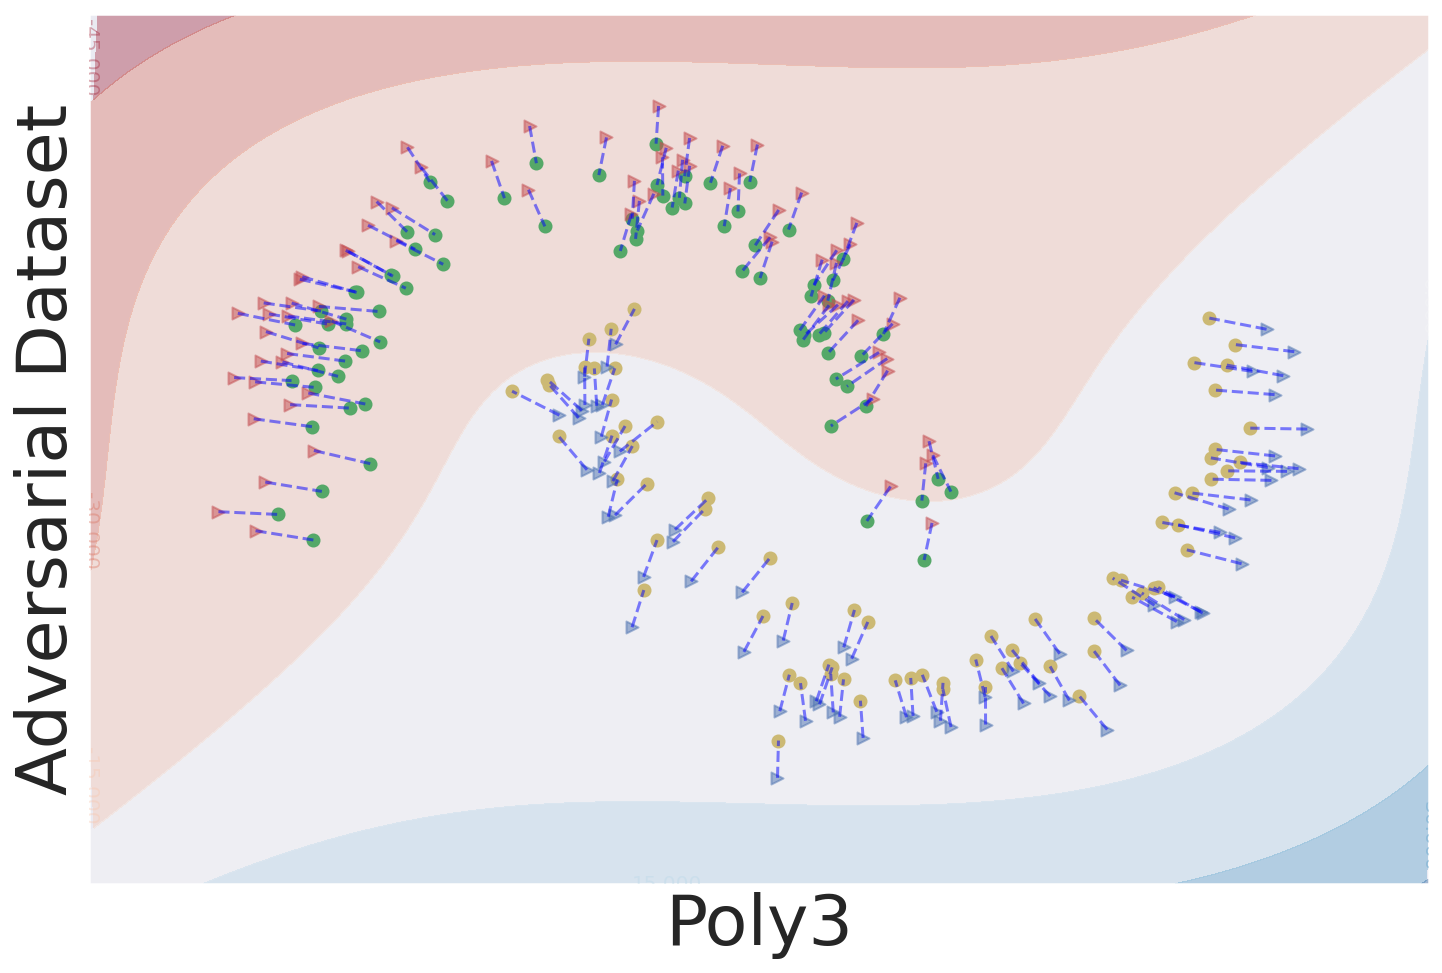

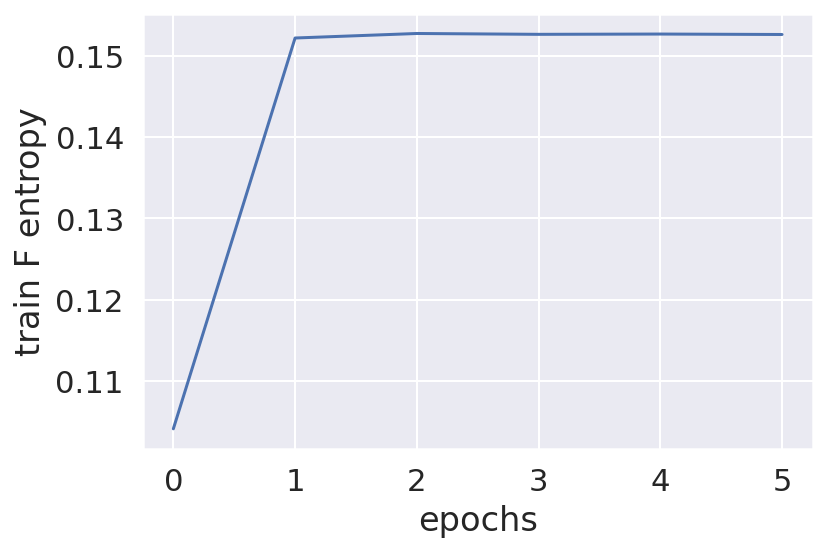

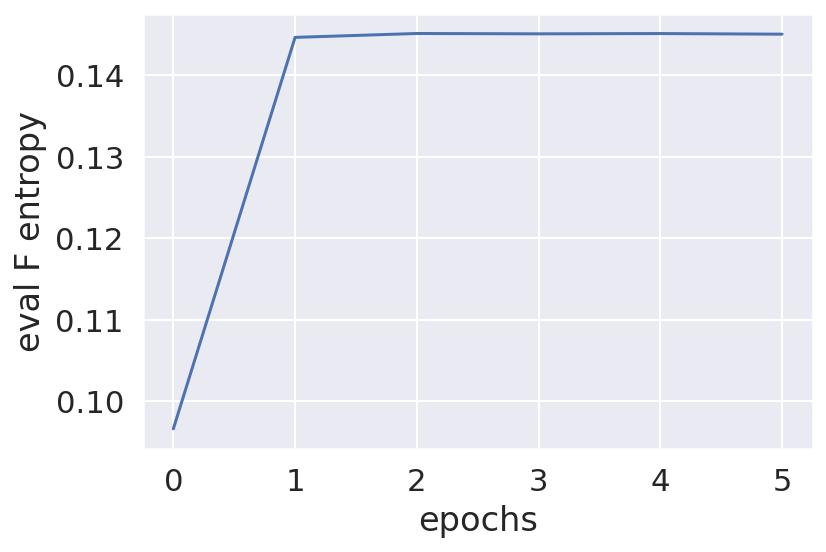

epoch:1000 train_loss:0.1531481295824051
epoch:2000 train_loss:0.12231593579053879
epoch:3000 train_loss:0.10264352709054947
epoch:4000 train_loss:0.08850418031215668
in plot_data


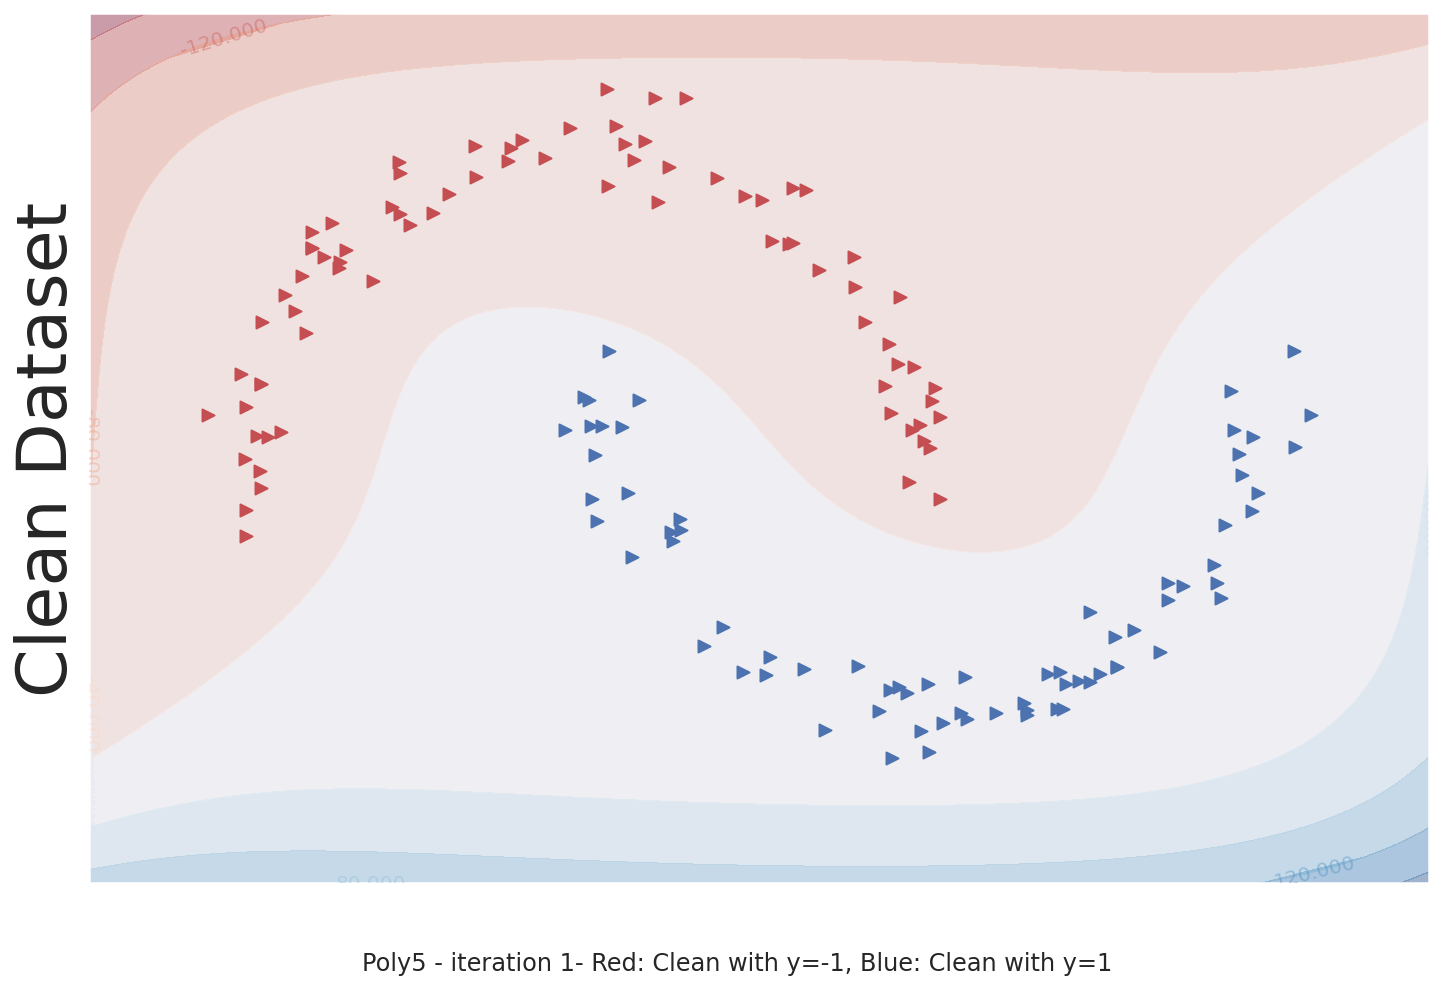

epoch:1000 train_loss:0.12723706662654877
in plot_data


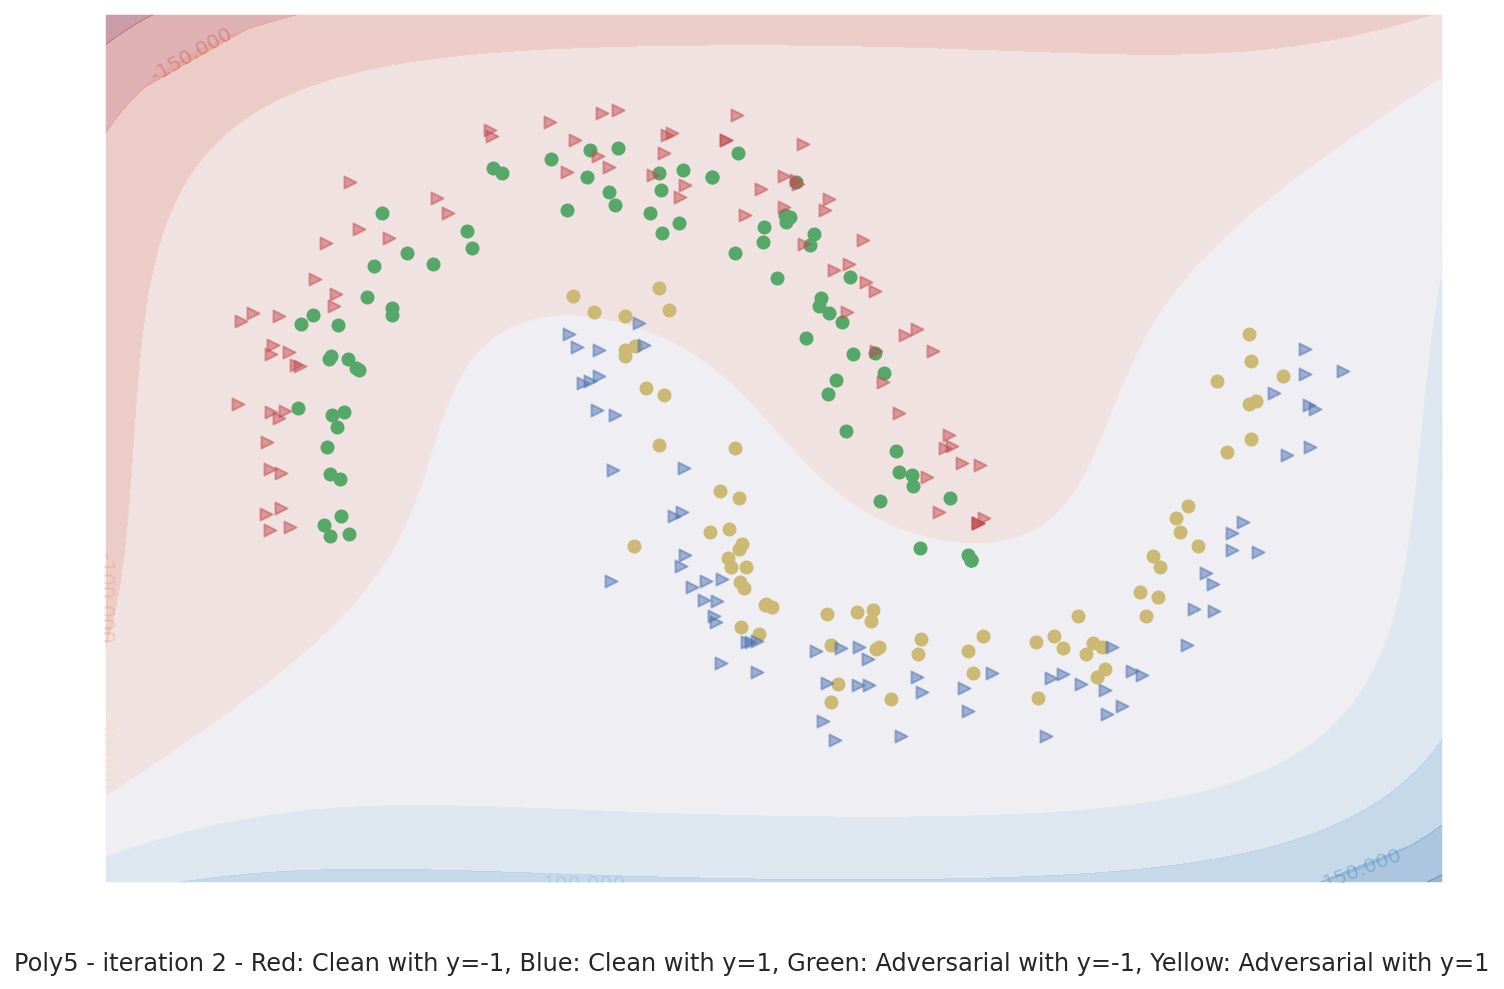

in plot_data


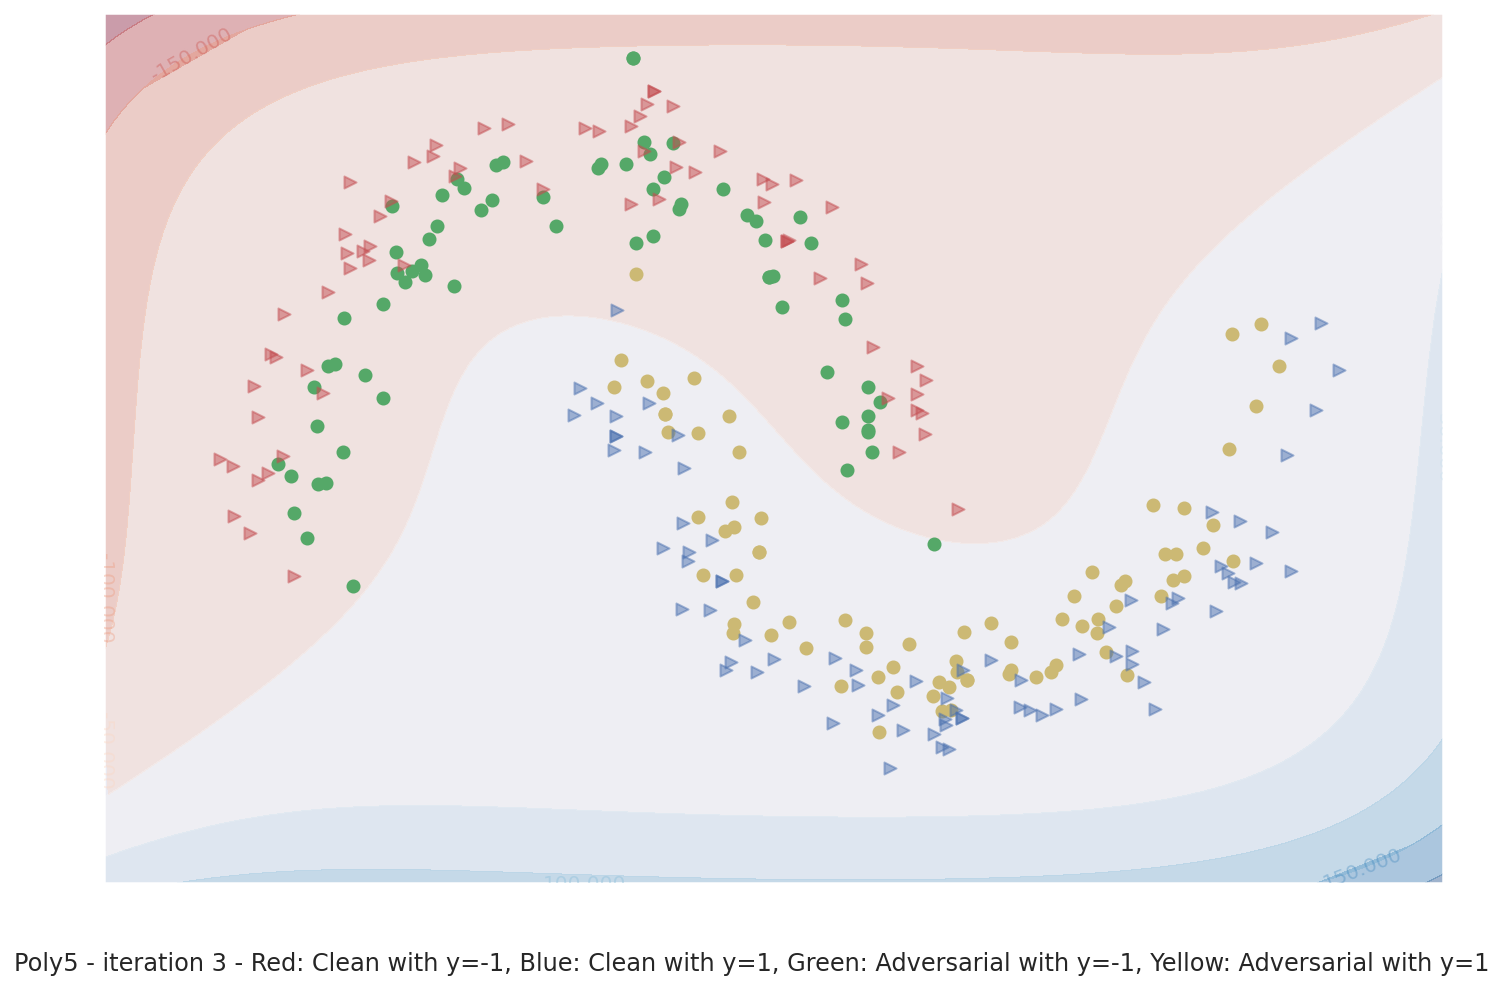

in plot_data


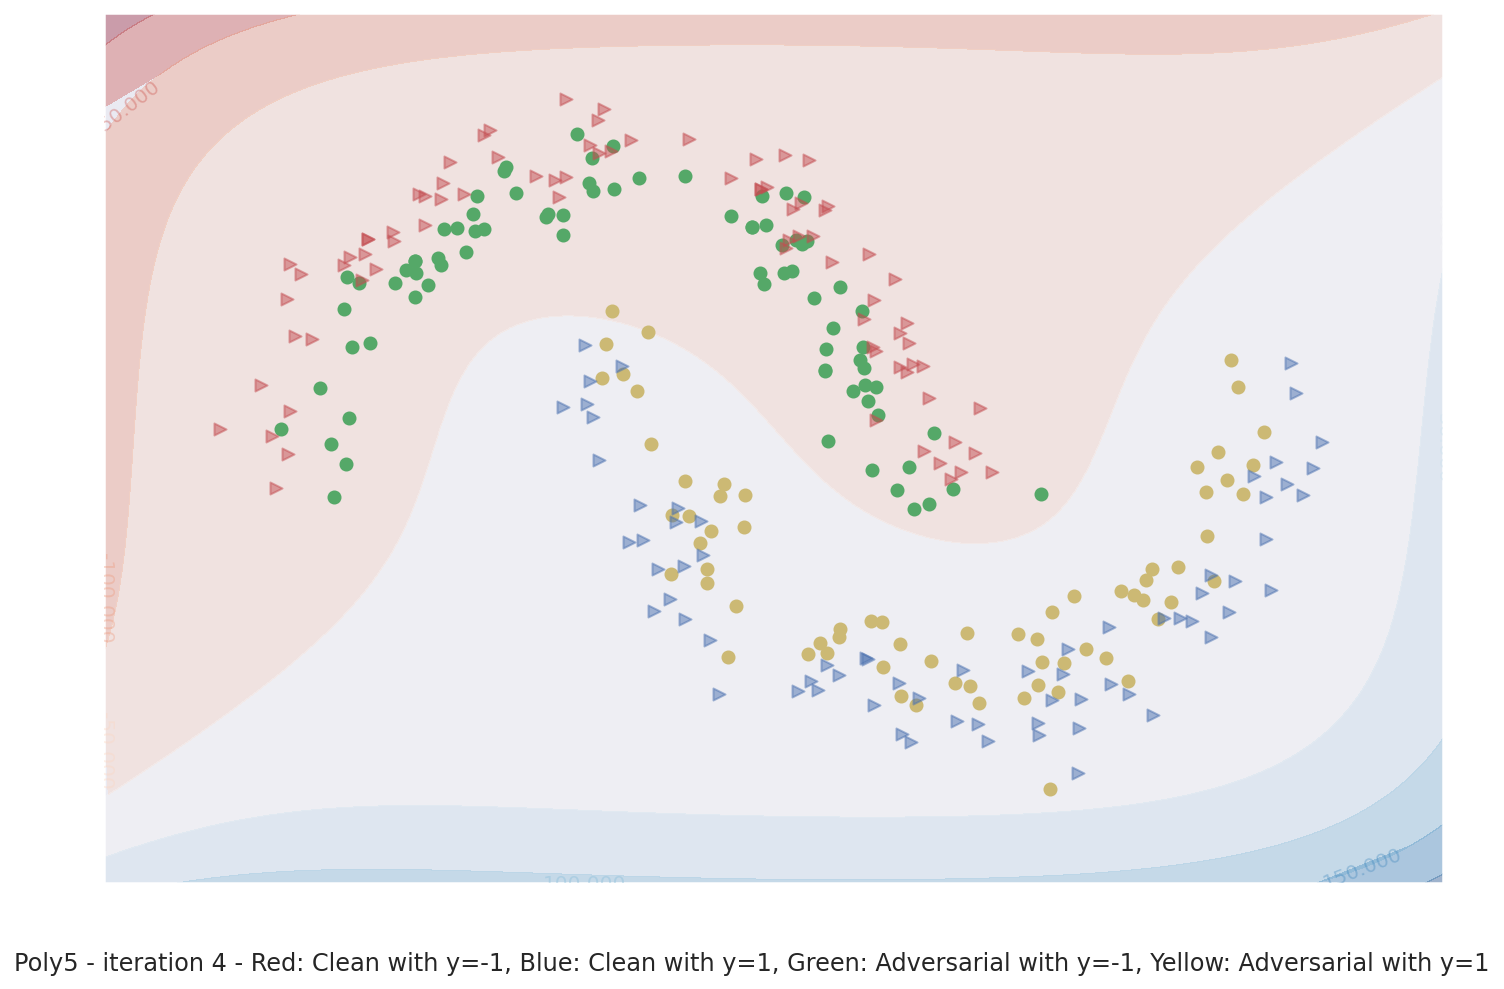

in plot_data


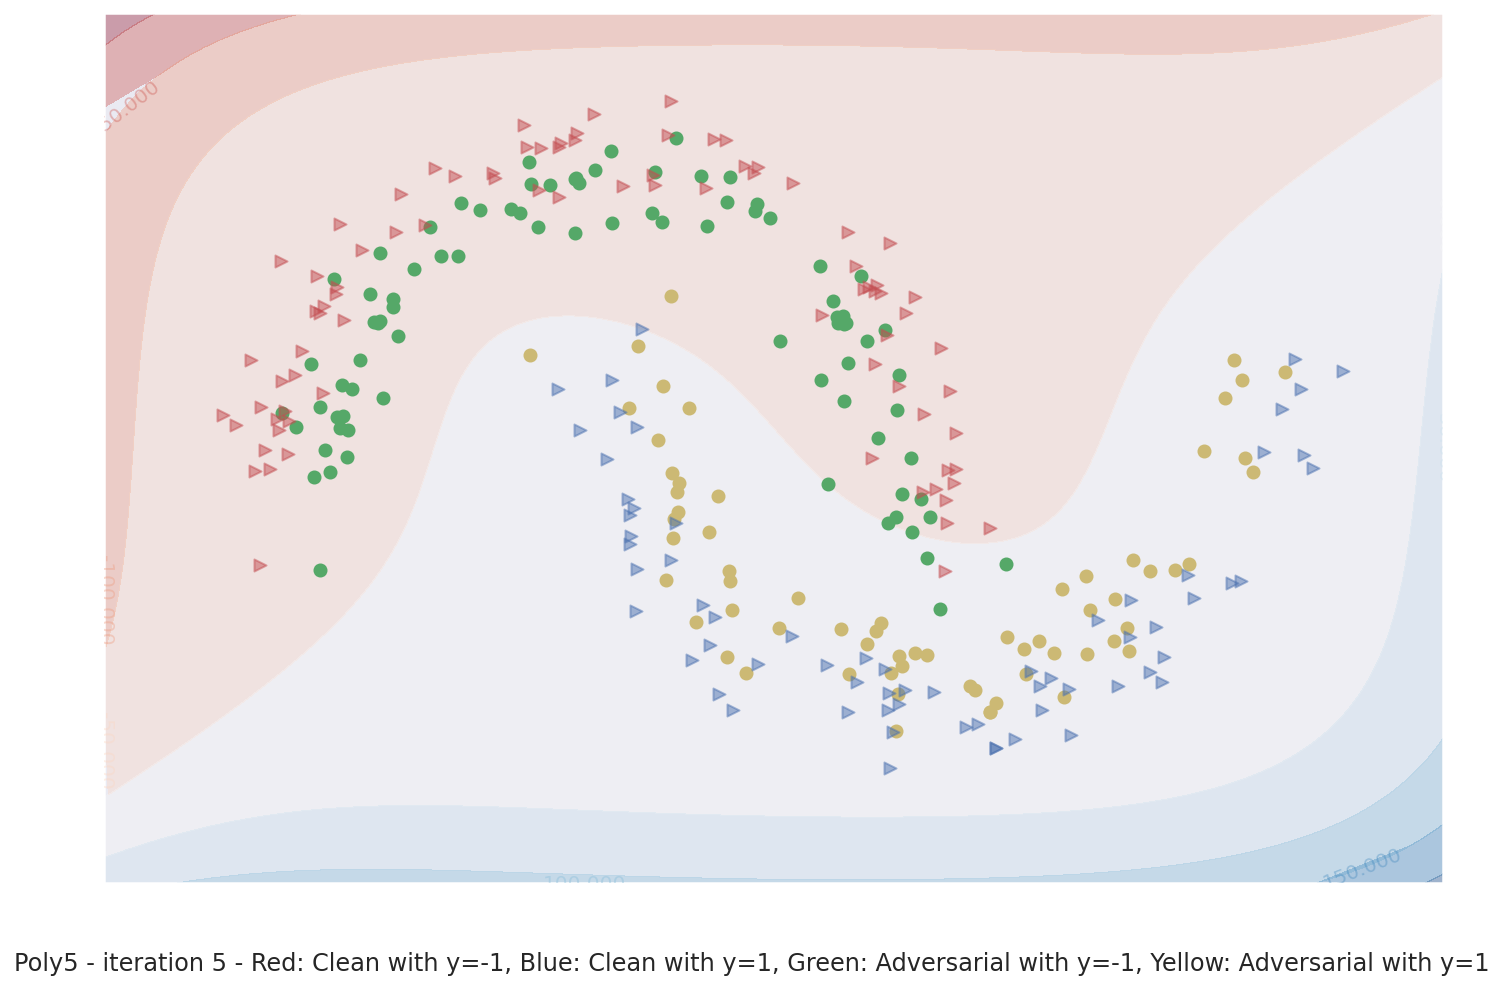

in plot_data_fin


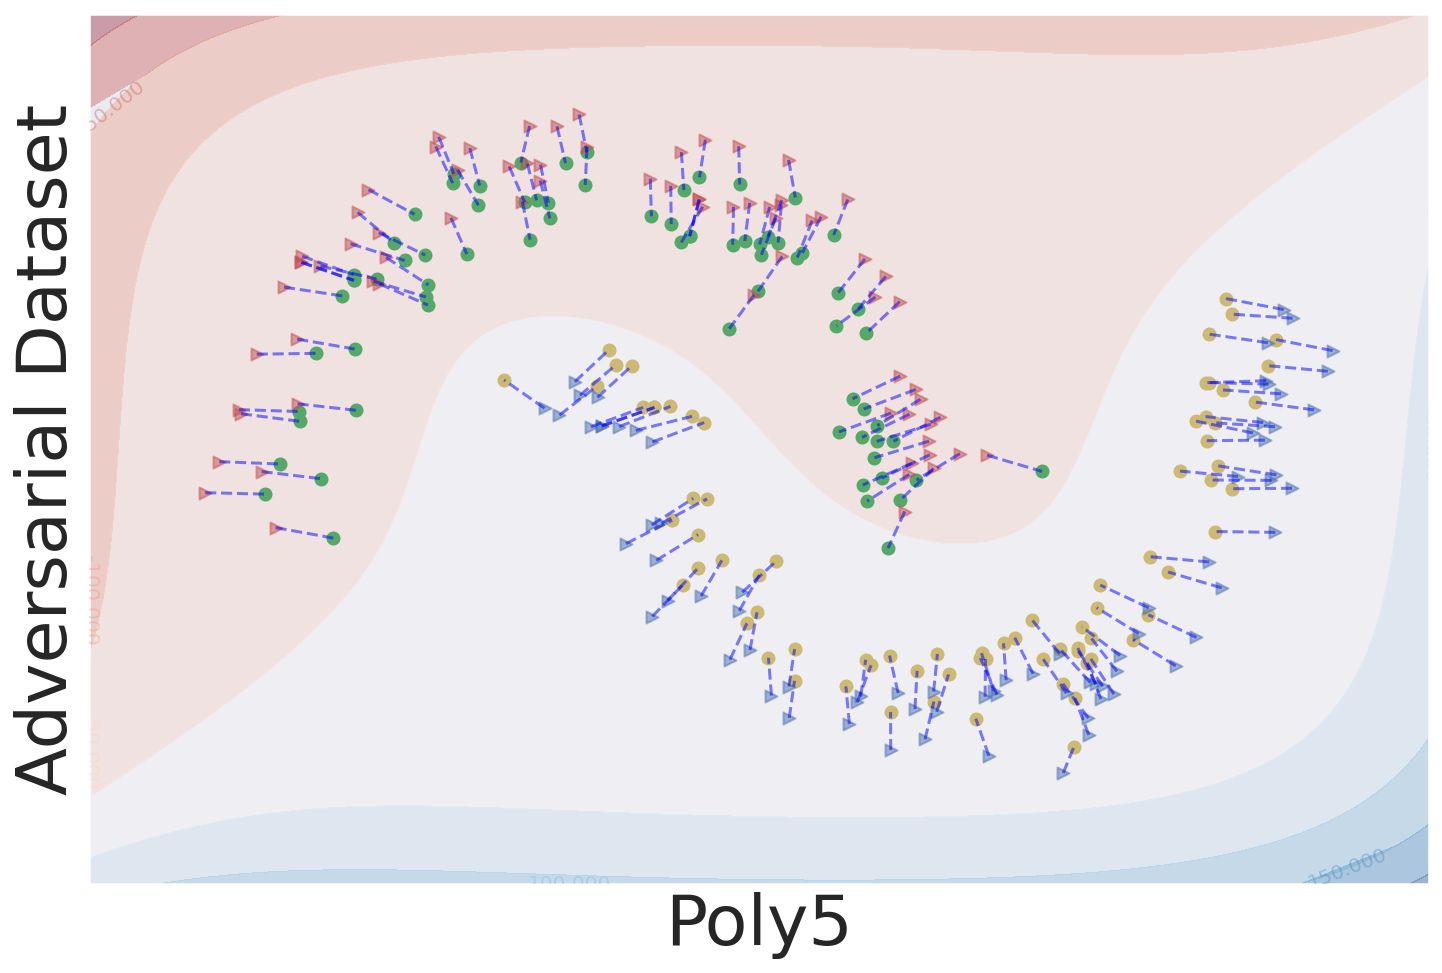

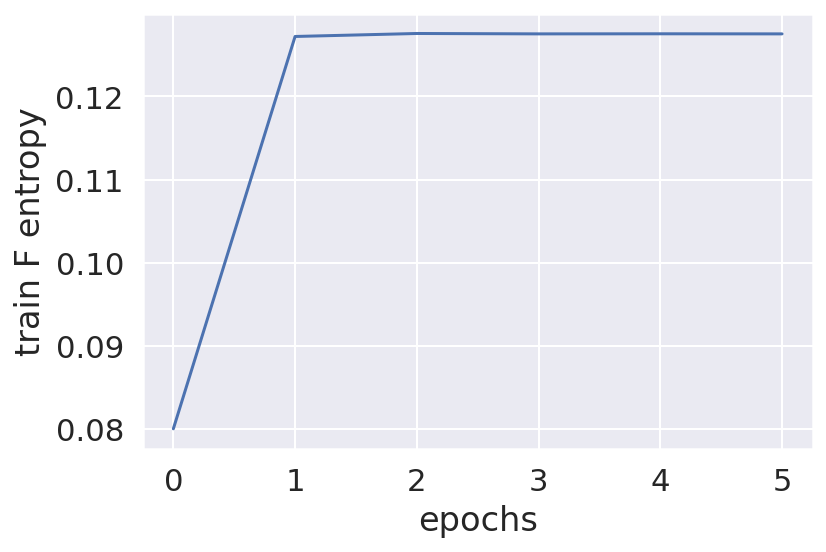

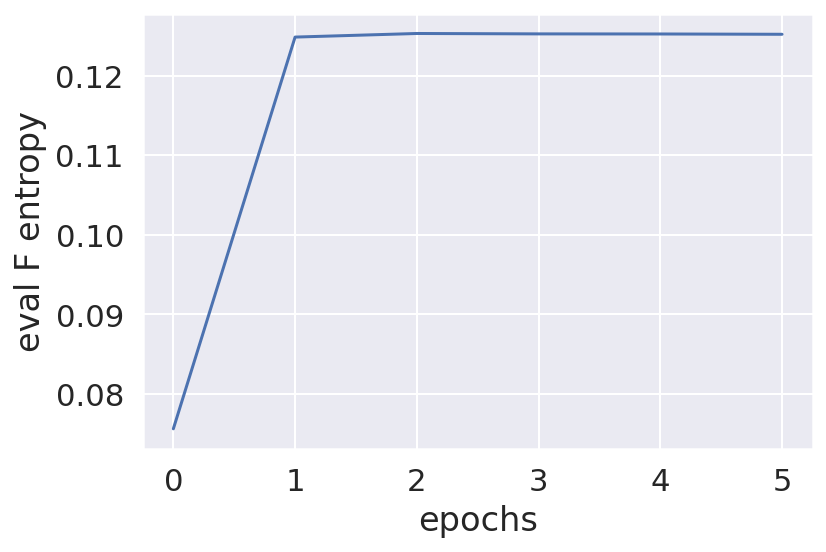

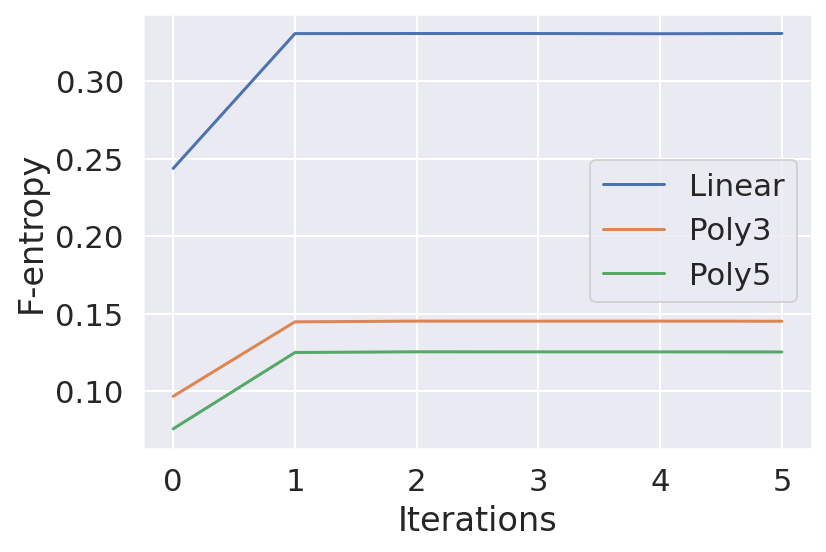

In [13]:
def main():

  torch.manual_seed(0)

  ### -------- LINEAR --------------- ###
  args={}
  args['outer_epochs'] = 6
  args['eps'] = 0.2
  args['lr'] = 1e-2
  args['n_samples'] = 500
  args['stop_treshold'] = 1e-5
  args['norm'] = 'L2'
  args['name'] = 'Linear'


  X_train, y_train, X_eval, y_eval = create_dataloaders(4000)
  critic = Critic_Linear(2)
  train_entropies_linear, eval_entropies_linear = train(critic, X_train, y_train, X_eval, y_eval, args, 'prop3')

  ### -------- POLY3 --------------- ###
  args={}
  args['outer_epochs'] = 6
  args['eps'] = 0.2
  args['lr'] = 1e-2
  args['n_samples'] = 500
  args['stop_treshold'] = 1e-5
  args['degree'] = 3
  args['norm'] = 'L2'
  args['name'] = 'Poly3'
  
  X_train, y_train, X_eval, y_eval = create_dataloaders(4000)
  critic = Critic_Poly(2, args['degree'])
  train_entropies_poly3, eval_entropies_poly3 = train(critic, X_train, y_train, X_eval, y_eval, args, 'prop3')


  ### -------- POLY5 --------------- ###
  args={}
  args['outer_epochs'] = 6
  args['eps'] = 0.2
  args['lr'] = 1e-2
  args['n_samples'] = 500
  args['stop_treshold'] = 1e-5
  args['degree'] = 5
  args['norm'] = 'L2'
  args['name'] = 'Poly5'
  
  X_train, y_train, X_eval, y_eval = create_dataloaders(4000)
  critic = Critic_Poly(2, args['degree'])
  train_entropies_poly5, eval_entropies_poly5 = train(critic, X_train, y_train, X_eval, y_eval, args, 'prop3')
  
  plot_entropies(eval_entropies_linear, eval_entropies_poly3, eval_entropies_poly5, args['norm'])
if __name__ == '__main__':
  main()


# Test Proposition 2

In [24]:
def train_reg(critic, X_train, y_train , args):
  opt = optim.SGD(critic.parameters(), lr=args['lr'])

  losses = []
  train_entropies = []
  eval_entropies = []
  epoch=0
  prev_loss = -100
  while(True):
    epoch+=1
    opt.zero_grad()
    pred = critic(X_train)
    loss = loss_fn_reg(pred, y_train, args['eps'], critic)
    loss.backward()
    losses.append(loss.item())
    opt.step()
    if np.abs(loss.item() - prev_loss)<args['stop_treshold'] : 
      break
    prev_loss = loss.item()

  l = []
  for w in critic.parameters():
    l.append(w.clone().detach().data)
  return l

opt_weights calculated
epoch:1000 train_loss:0.2980470657348633
epoch:2000 train_loss:0.26633769273757935
epoch:3000 train_loss:0.2571740746498108
epoch:4000 train_loss:0.2532305419445038
epoch:5000 train_loss:0.2512522041797638
epoch:6000 train_loss:0.250174343585968
epoch:7000 train_loss:0.24955548346042633
epoch:8000 train_loss:0.24918700754642487
epoch:9000 train_loss:0.24896183609962463
epoch:10000 train_loss:0.24882157146930695
epoch:11000 train_loss:0.24873289465904236
in plot_data


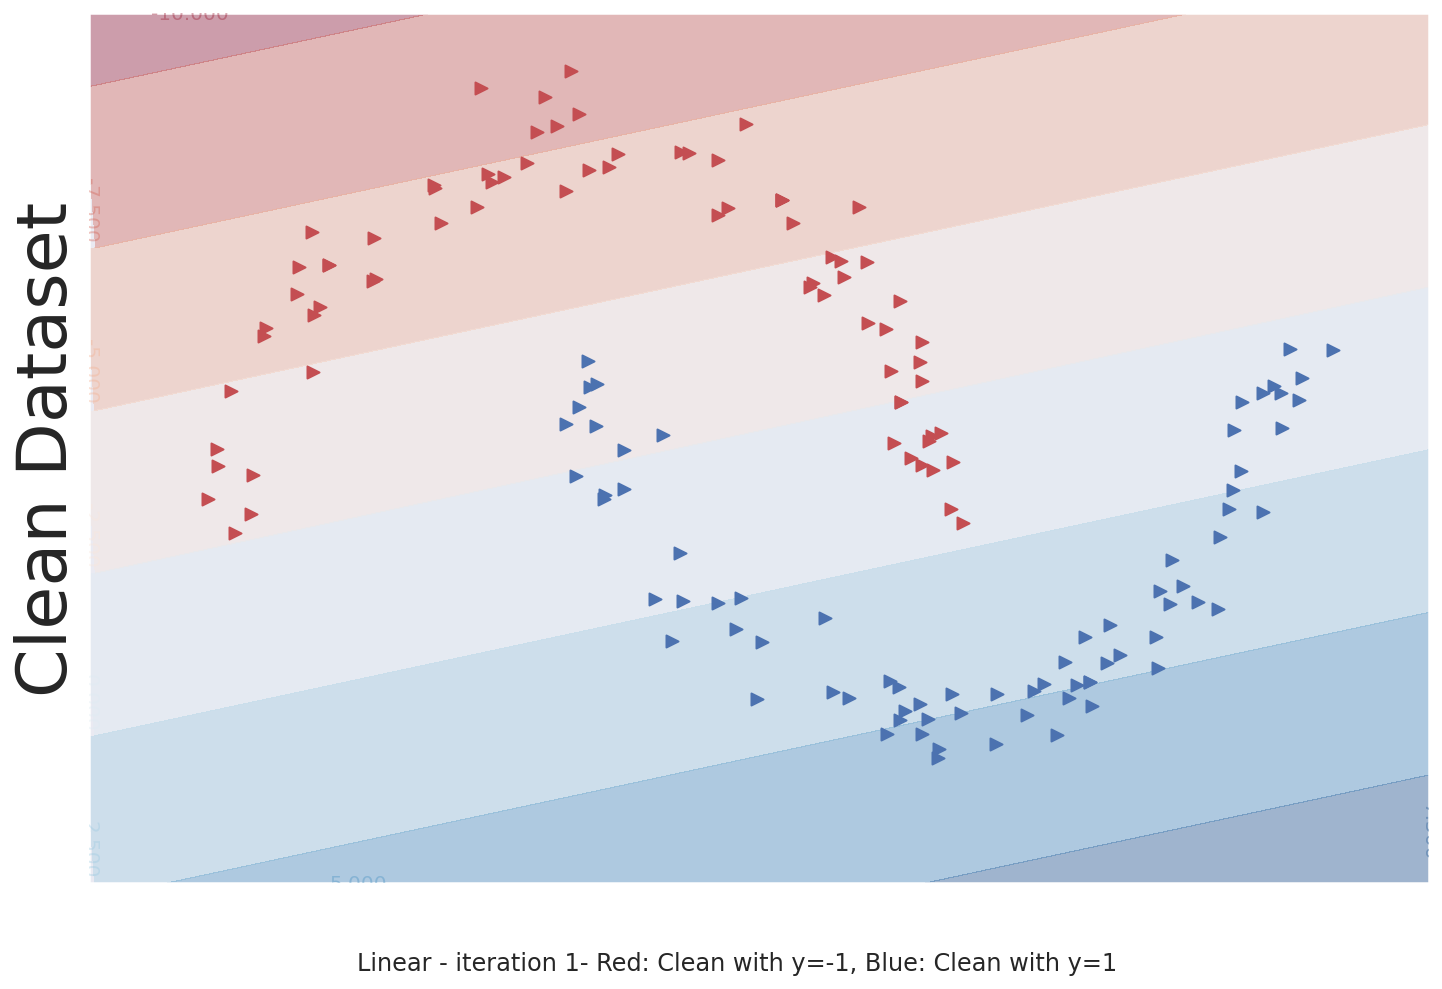

epoch:1000 train_loss:0.39385953545570374
epoch:2000 train_loss:0.3910023272037506
epoch:3000 train_loss:0.38969212770462036
epoch:4000 train_loss:0.38911429047584534
epoch:5000 train_loss:0.3888697028160095
in plot_data


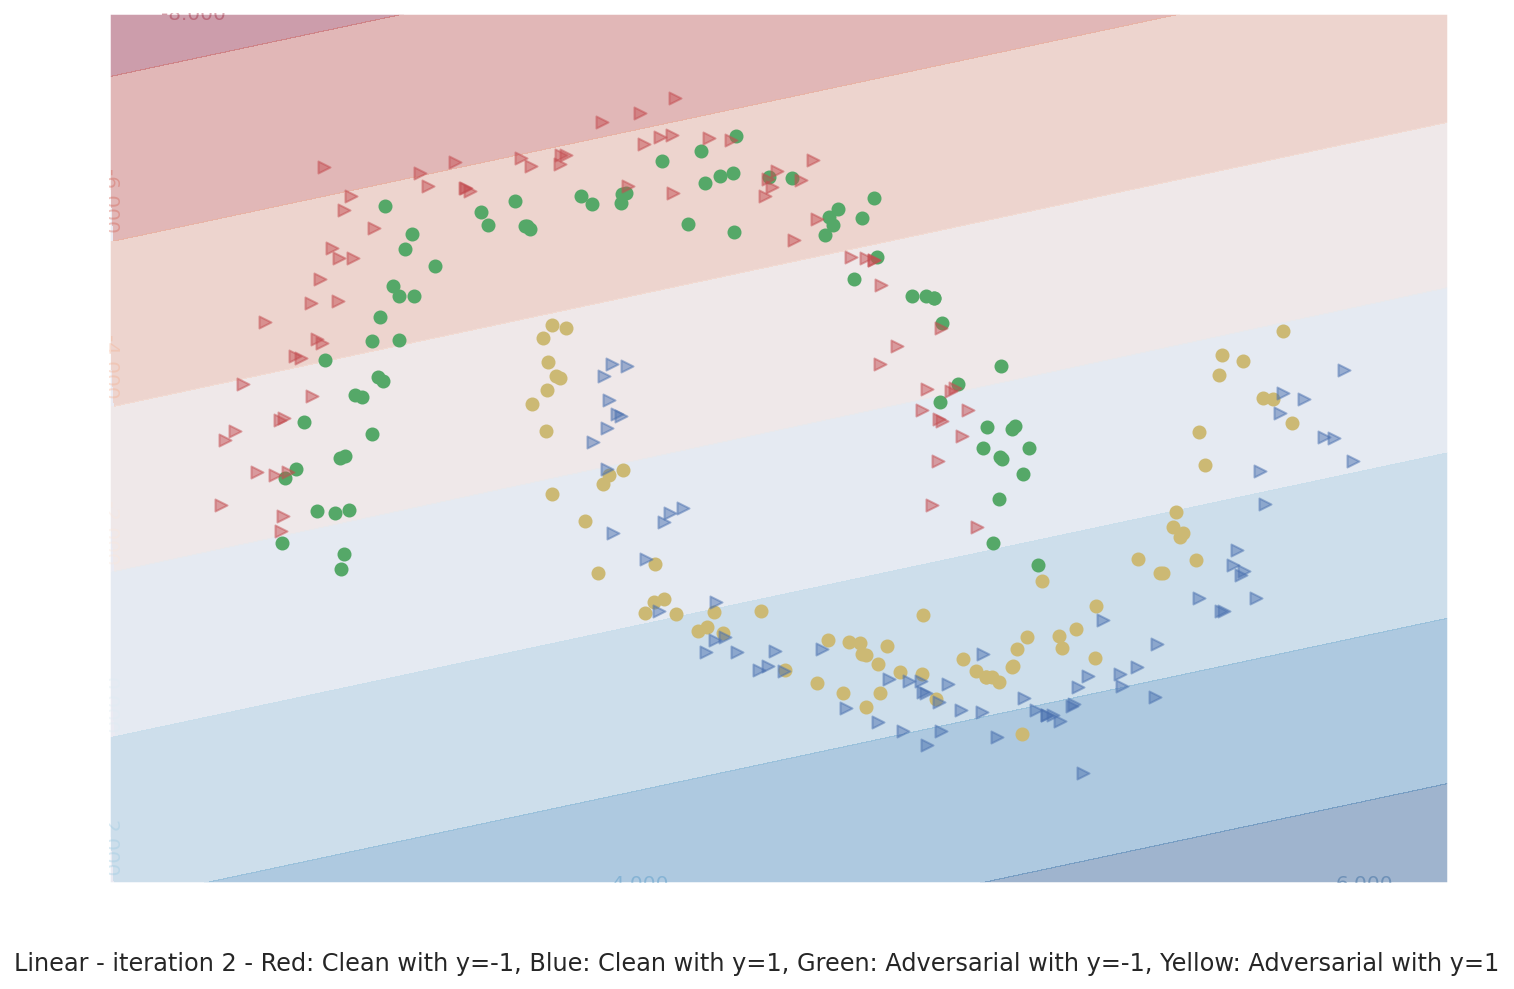

in plot_data


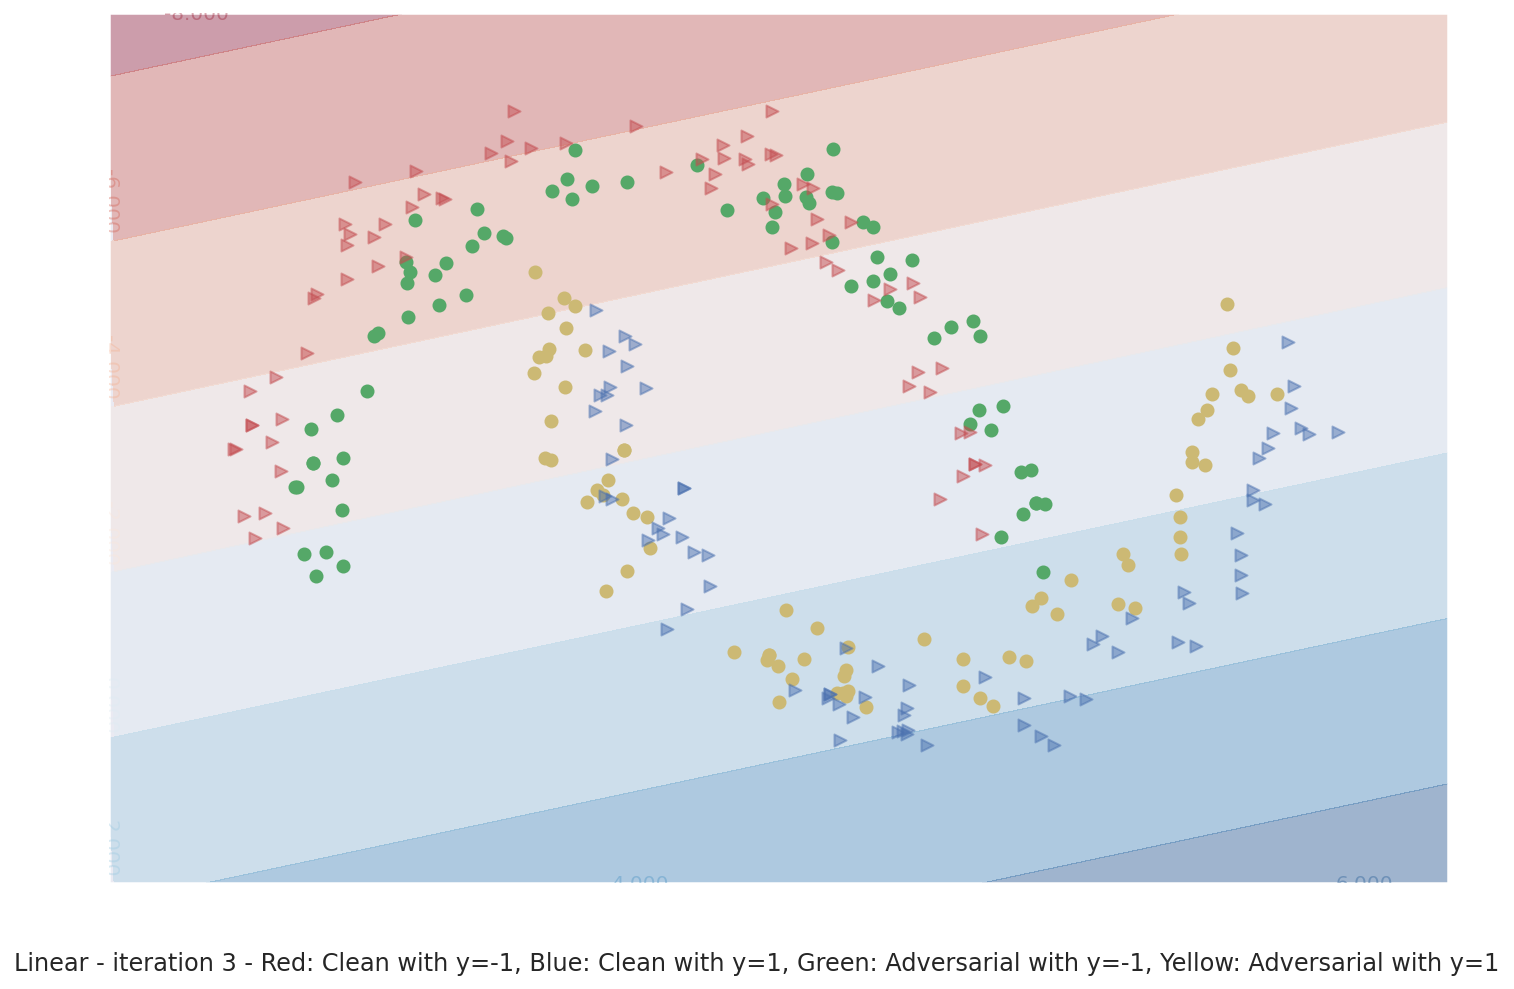

in plot_data


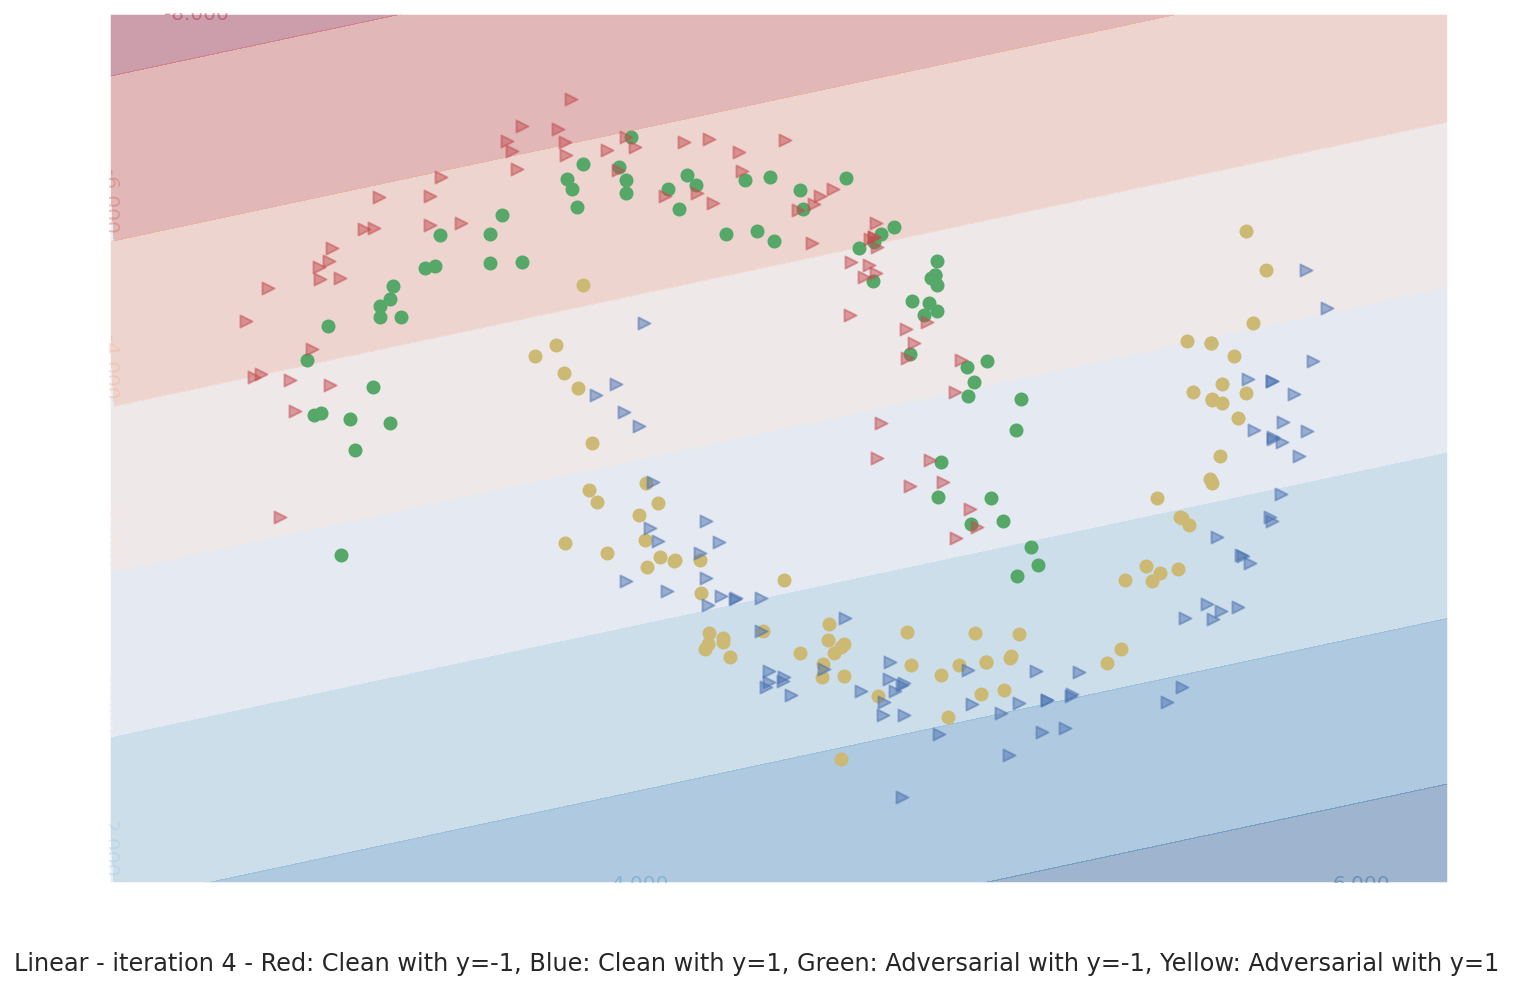

in plot_data


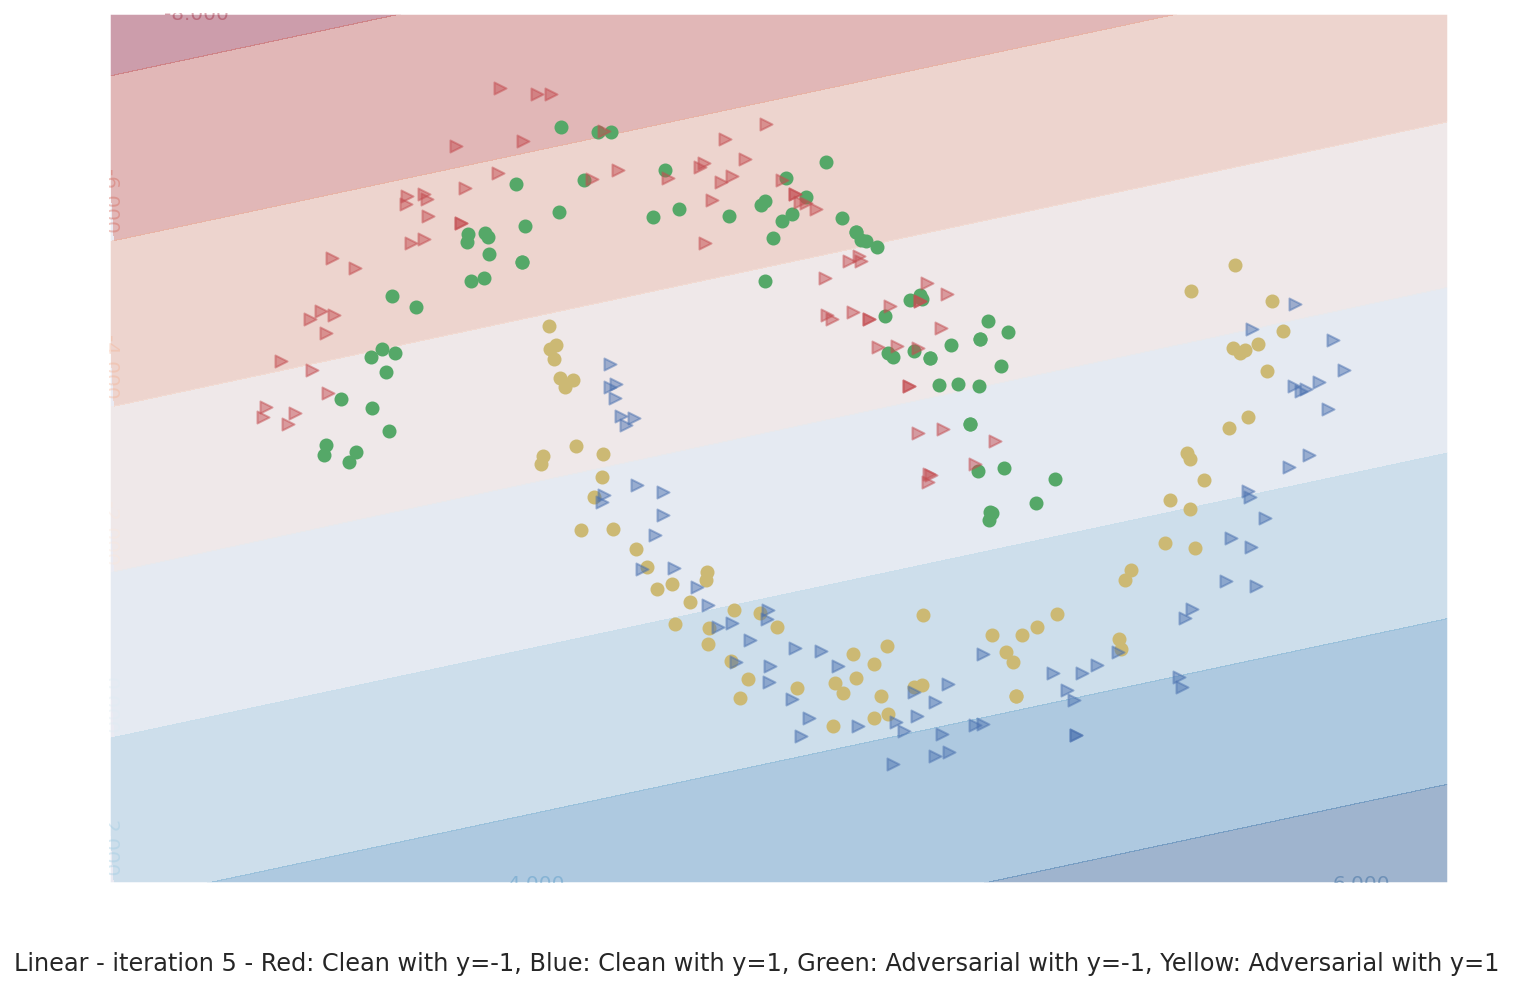

in plot_data


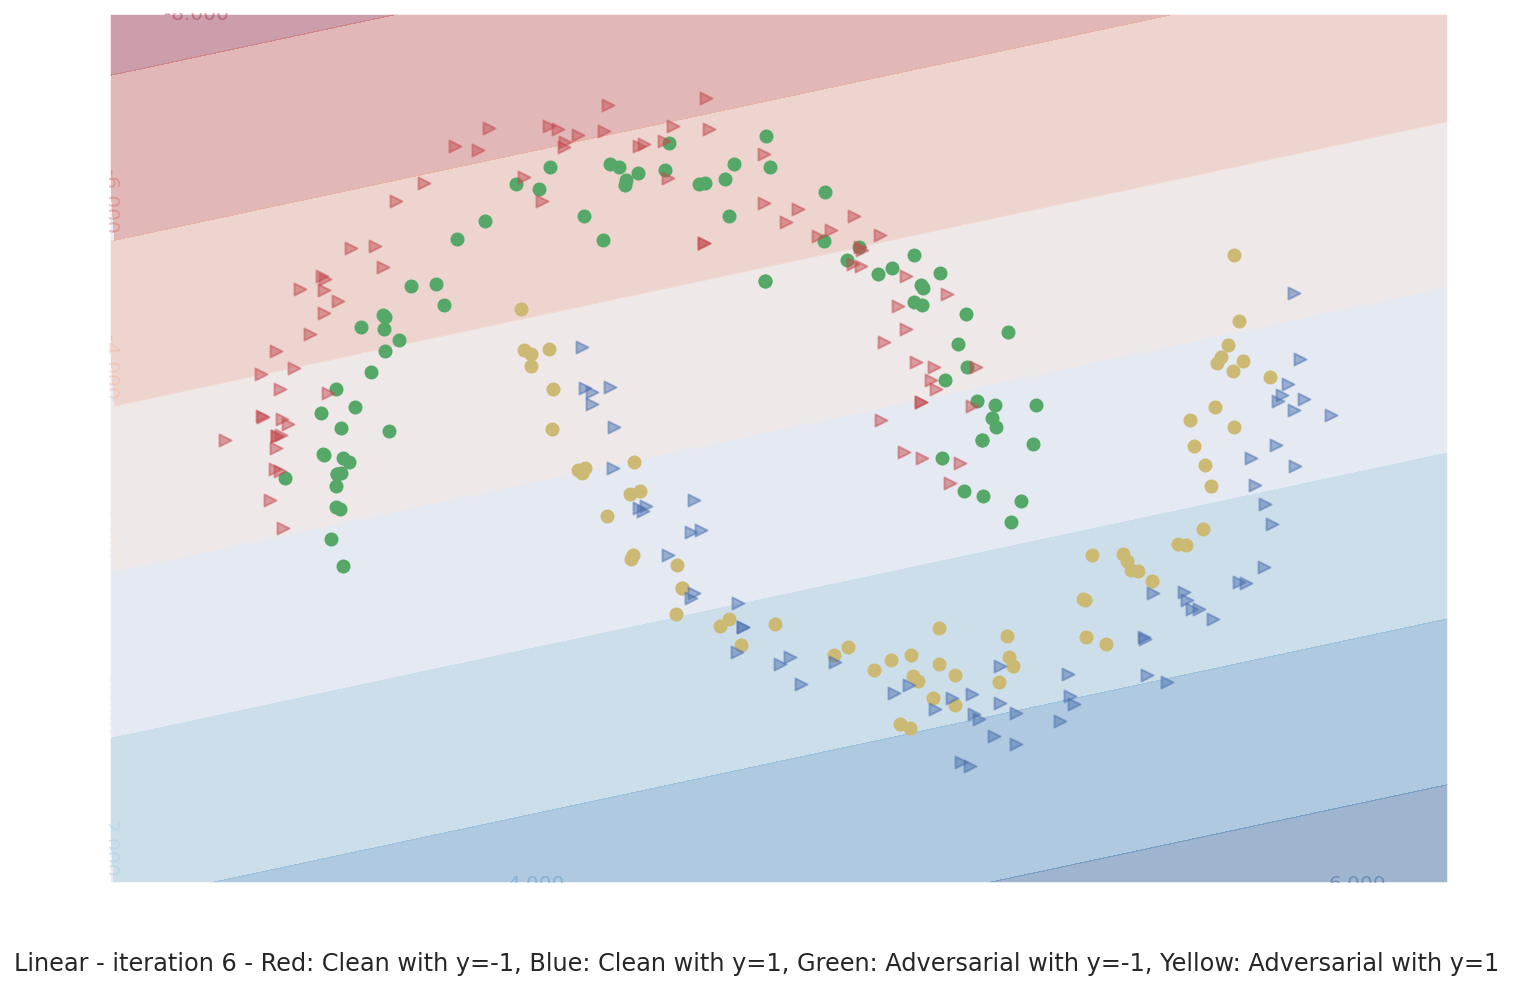

in plot_data


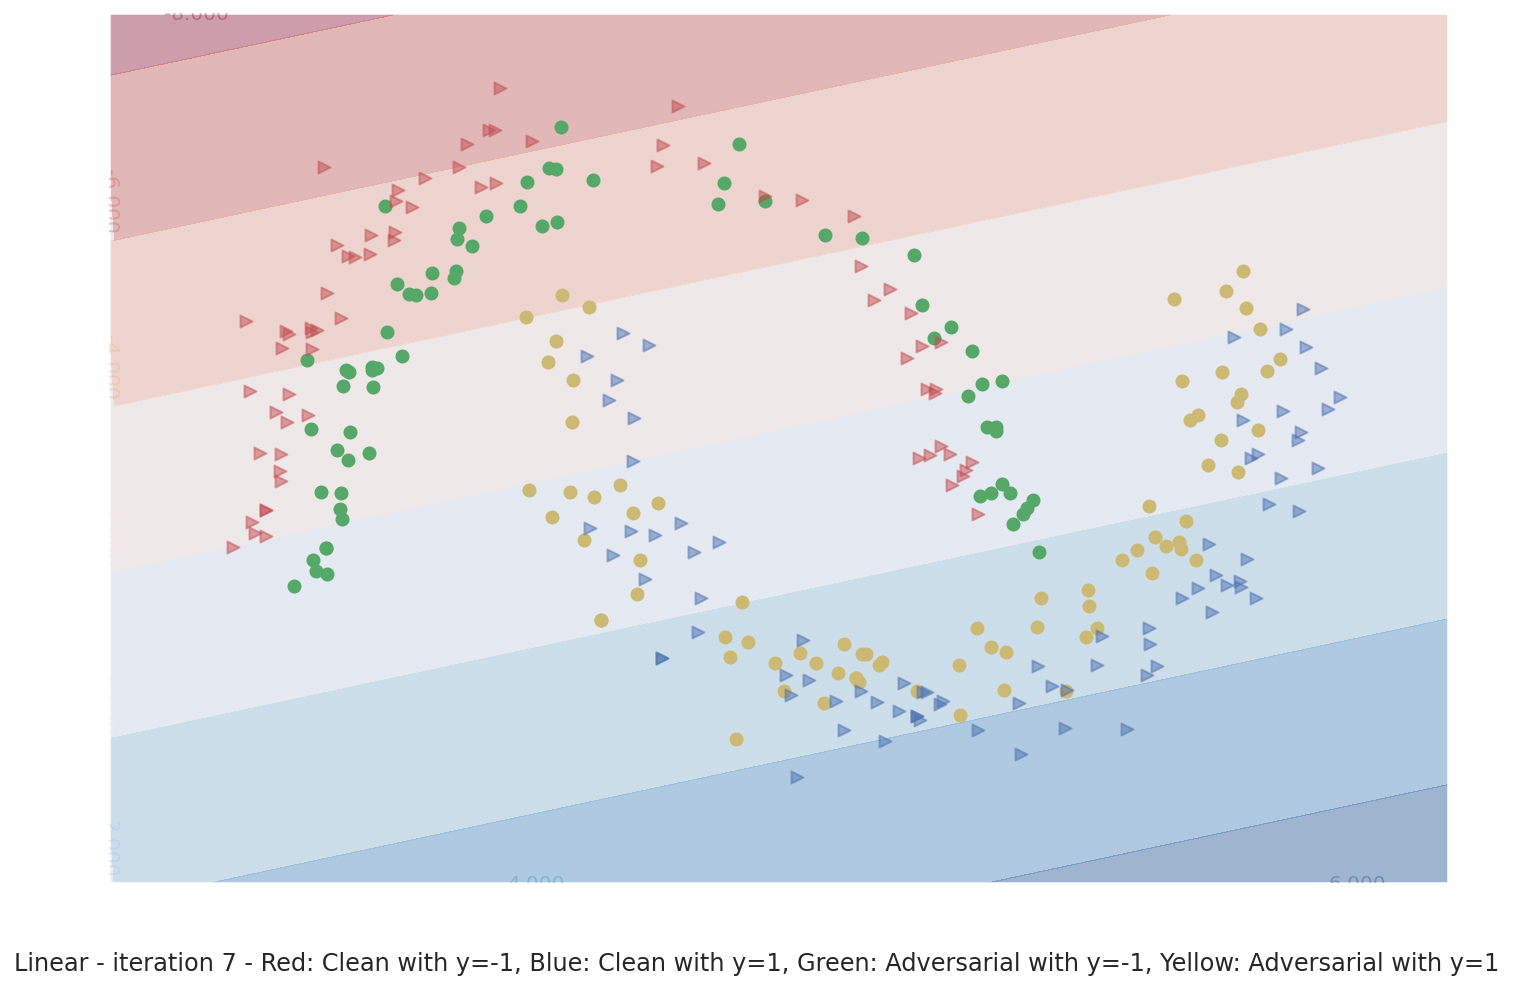

in plot_data


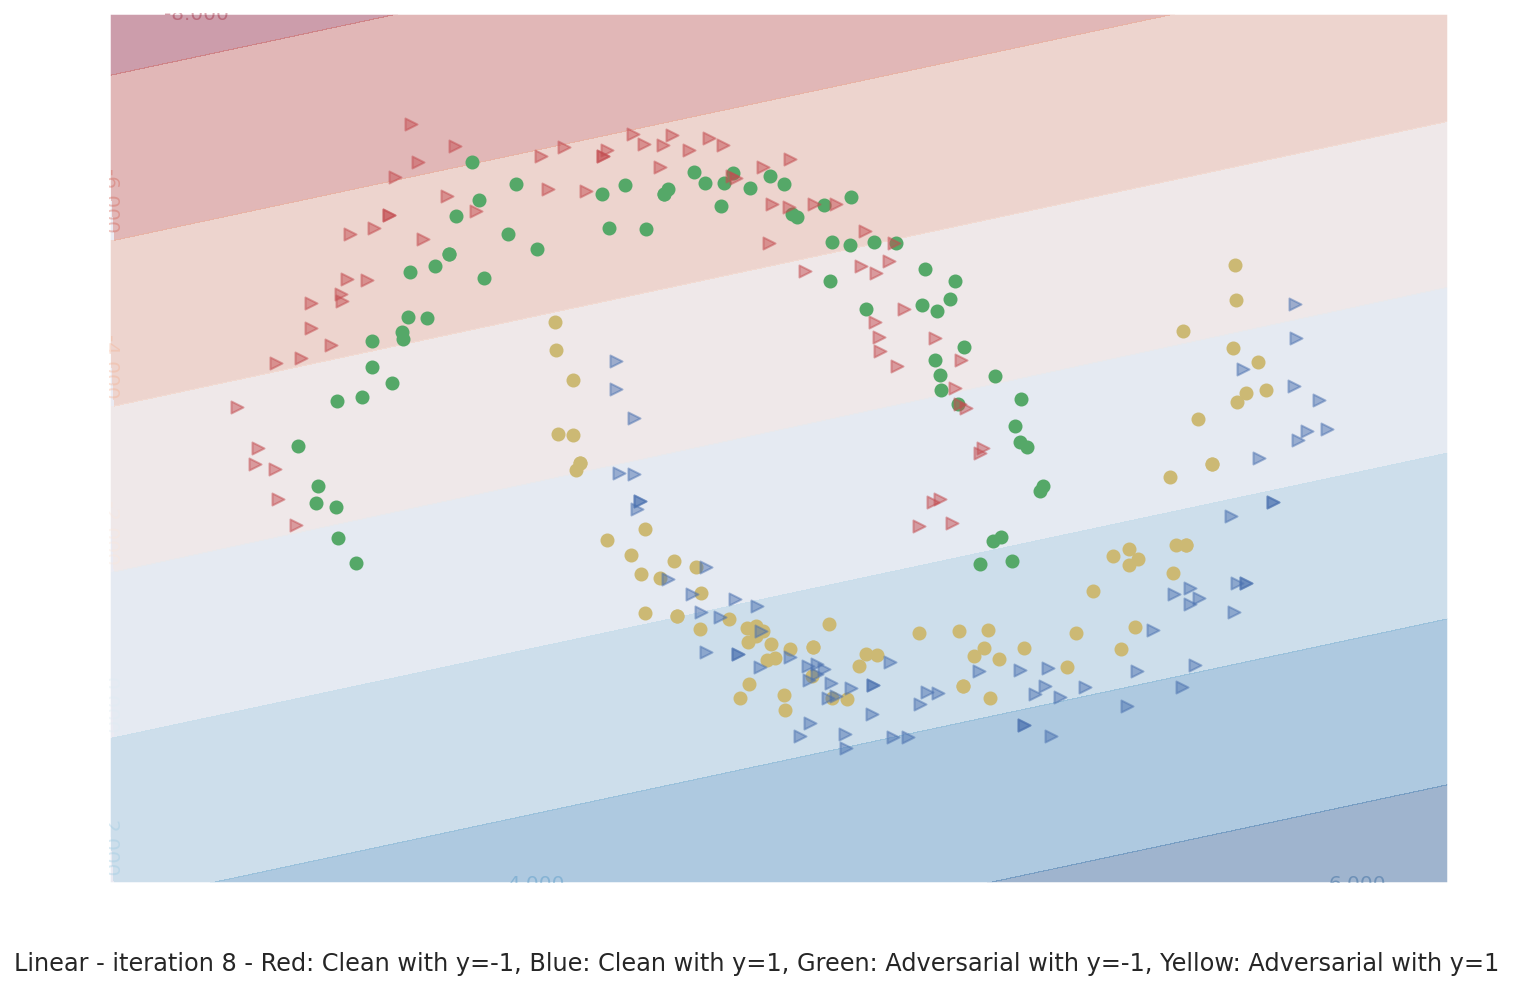

in plot_data


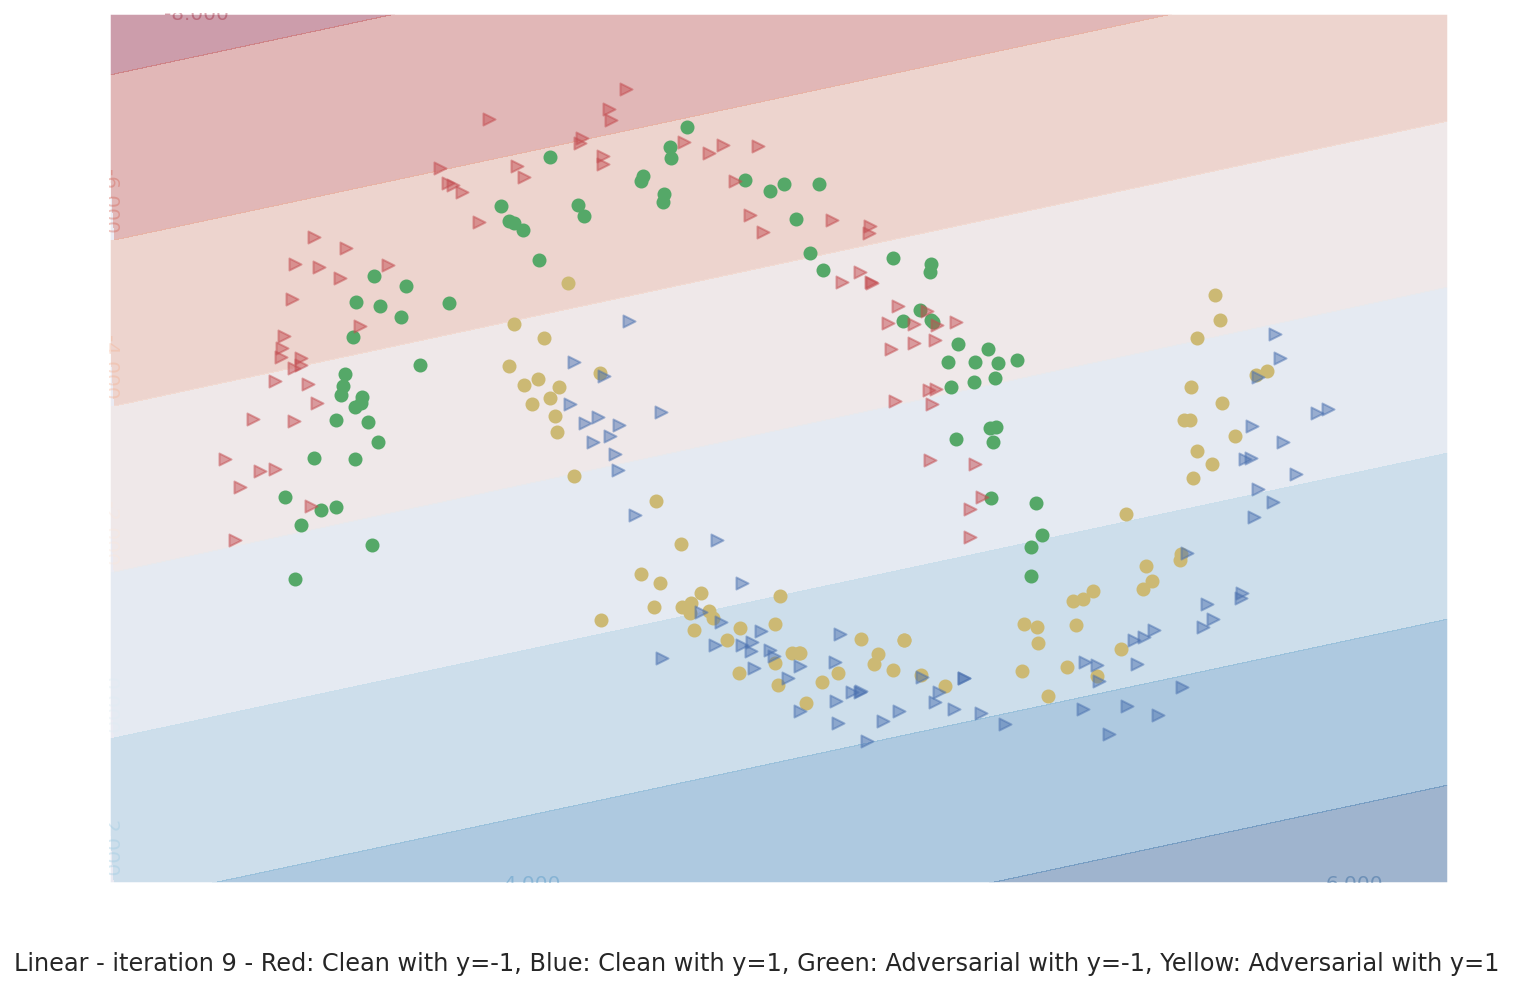

in plot_data


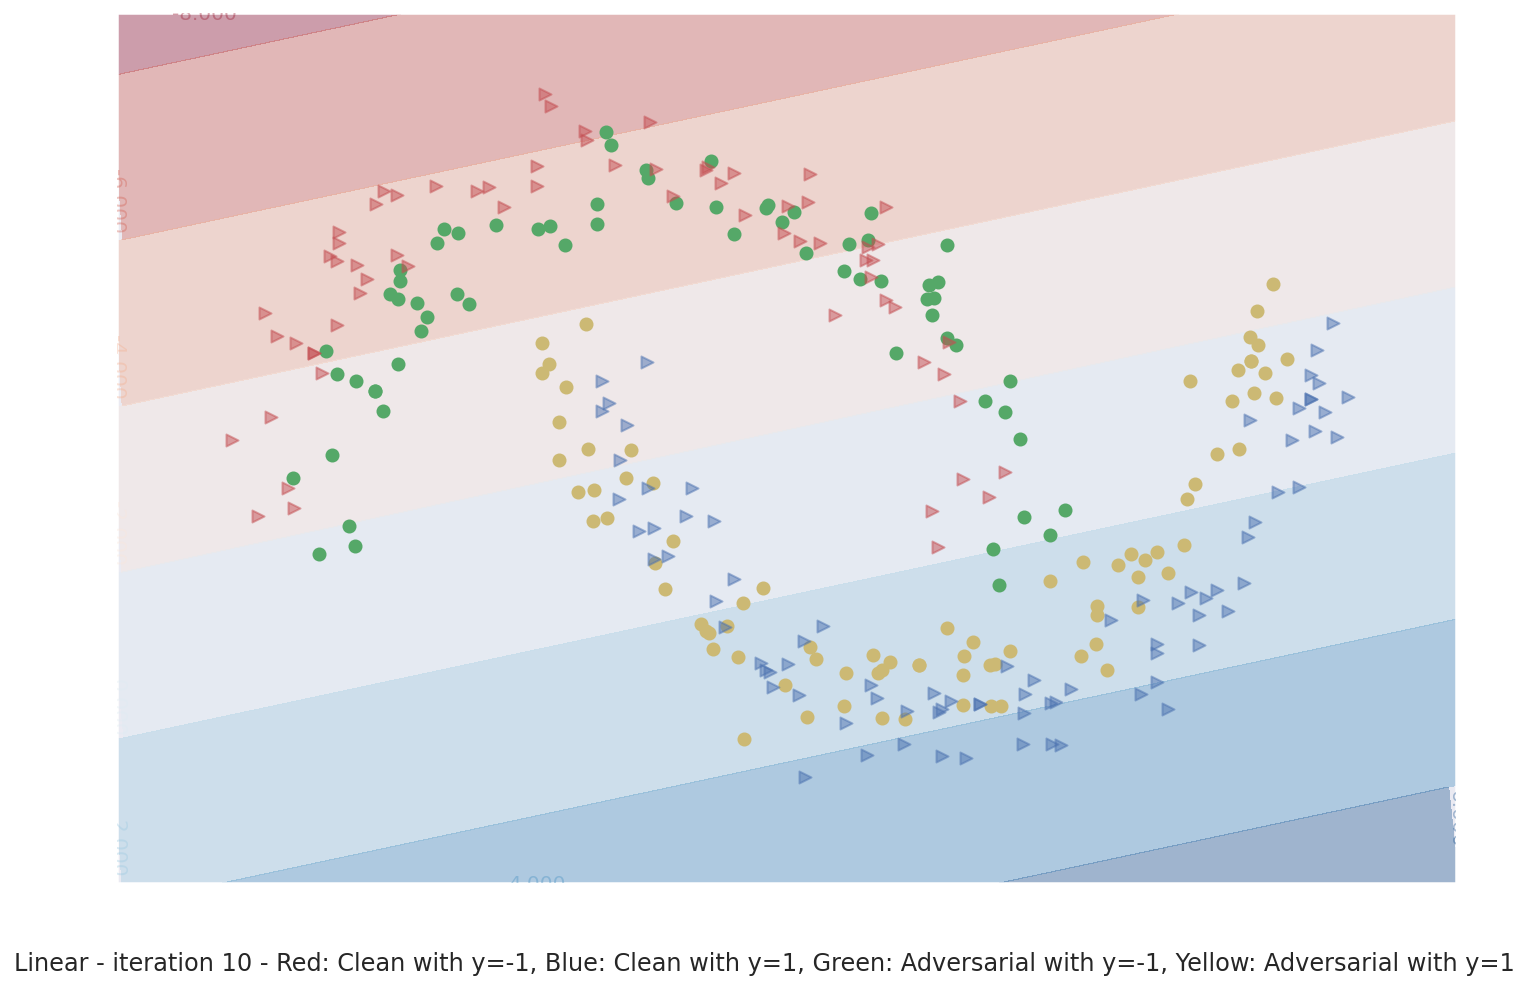

in plot_data


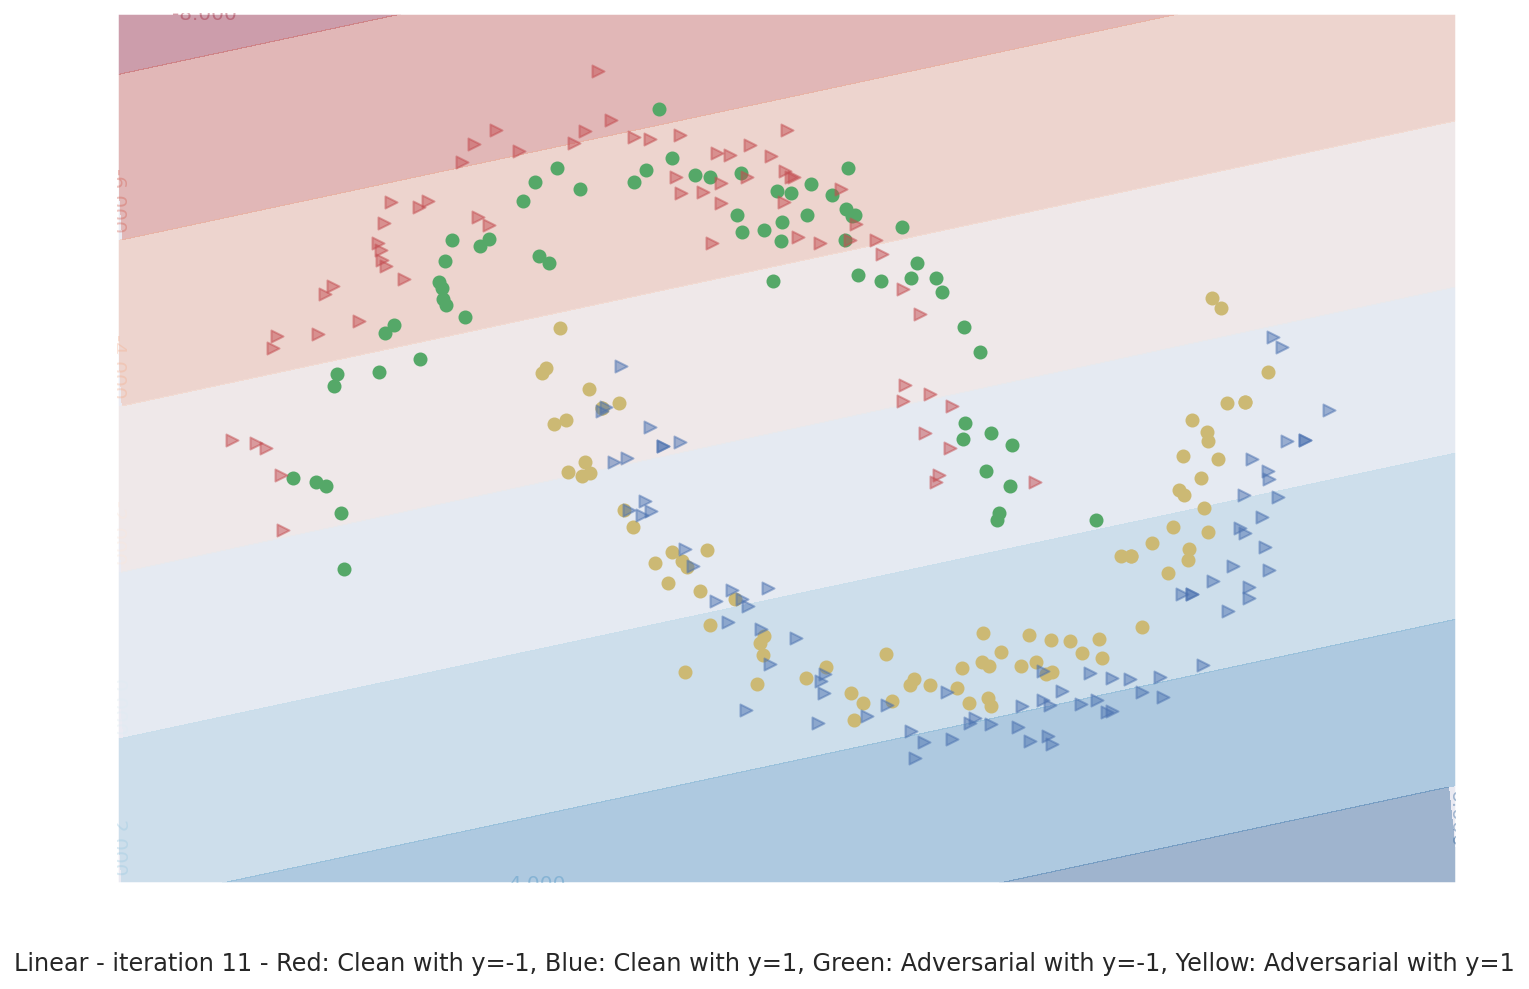

in plot_data


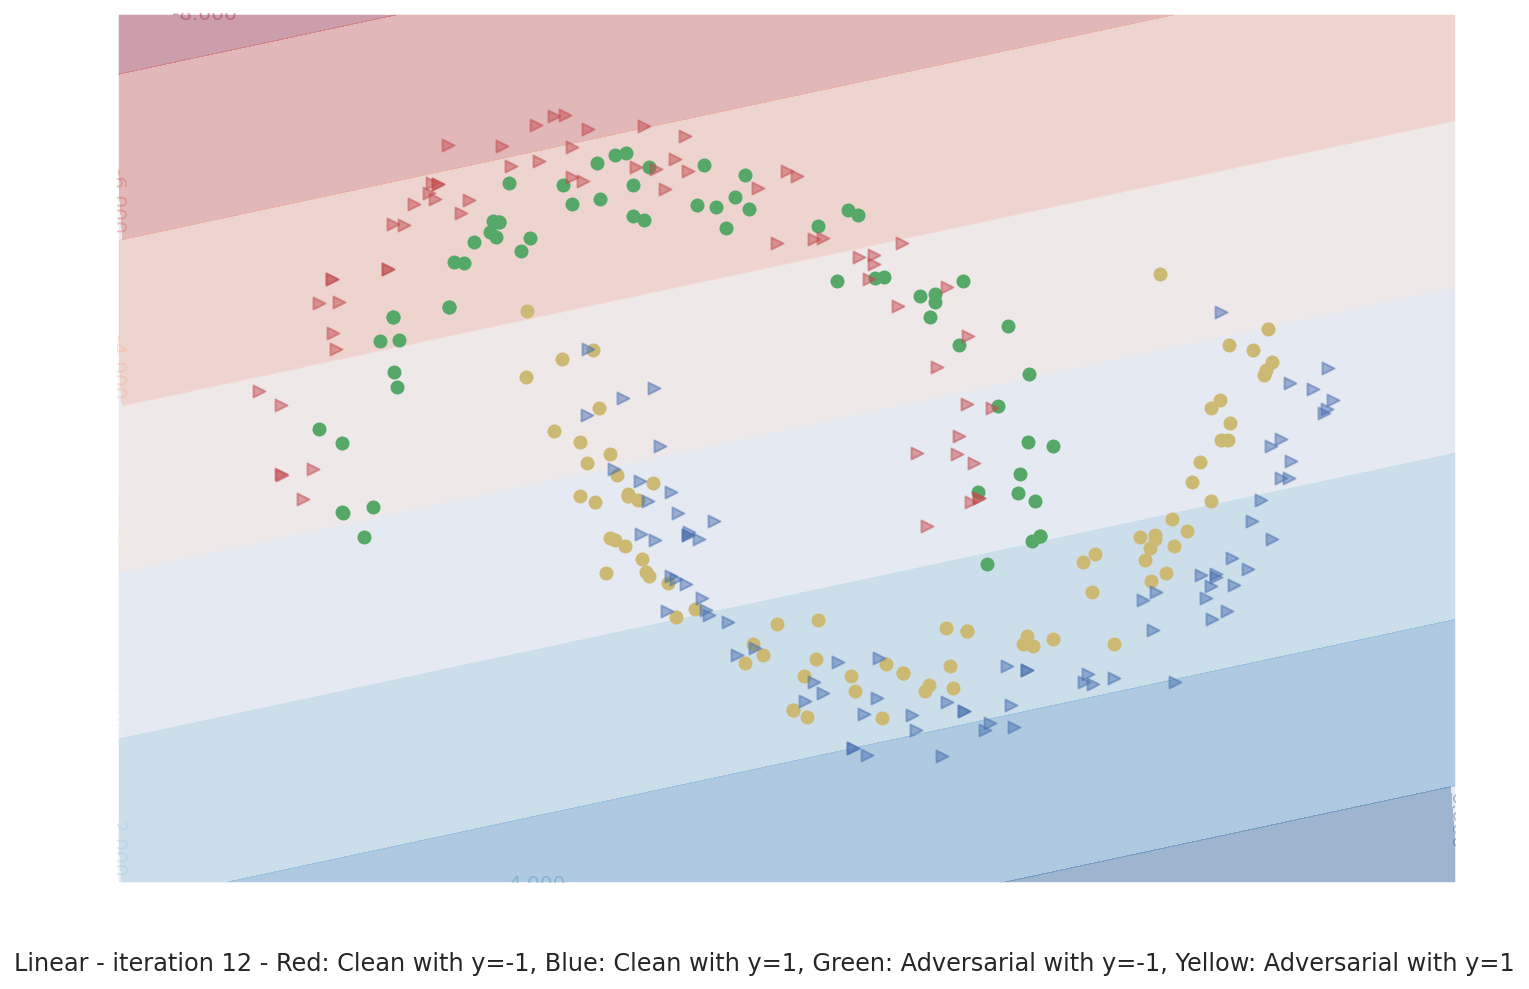

in plot_data


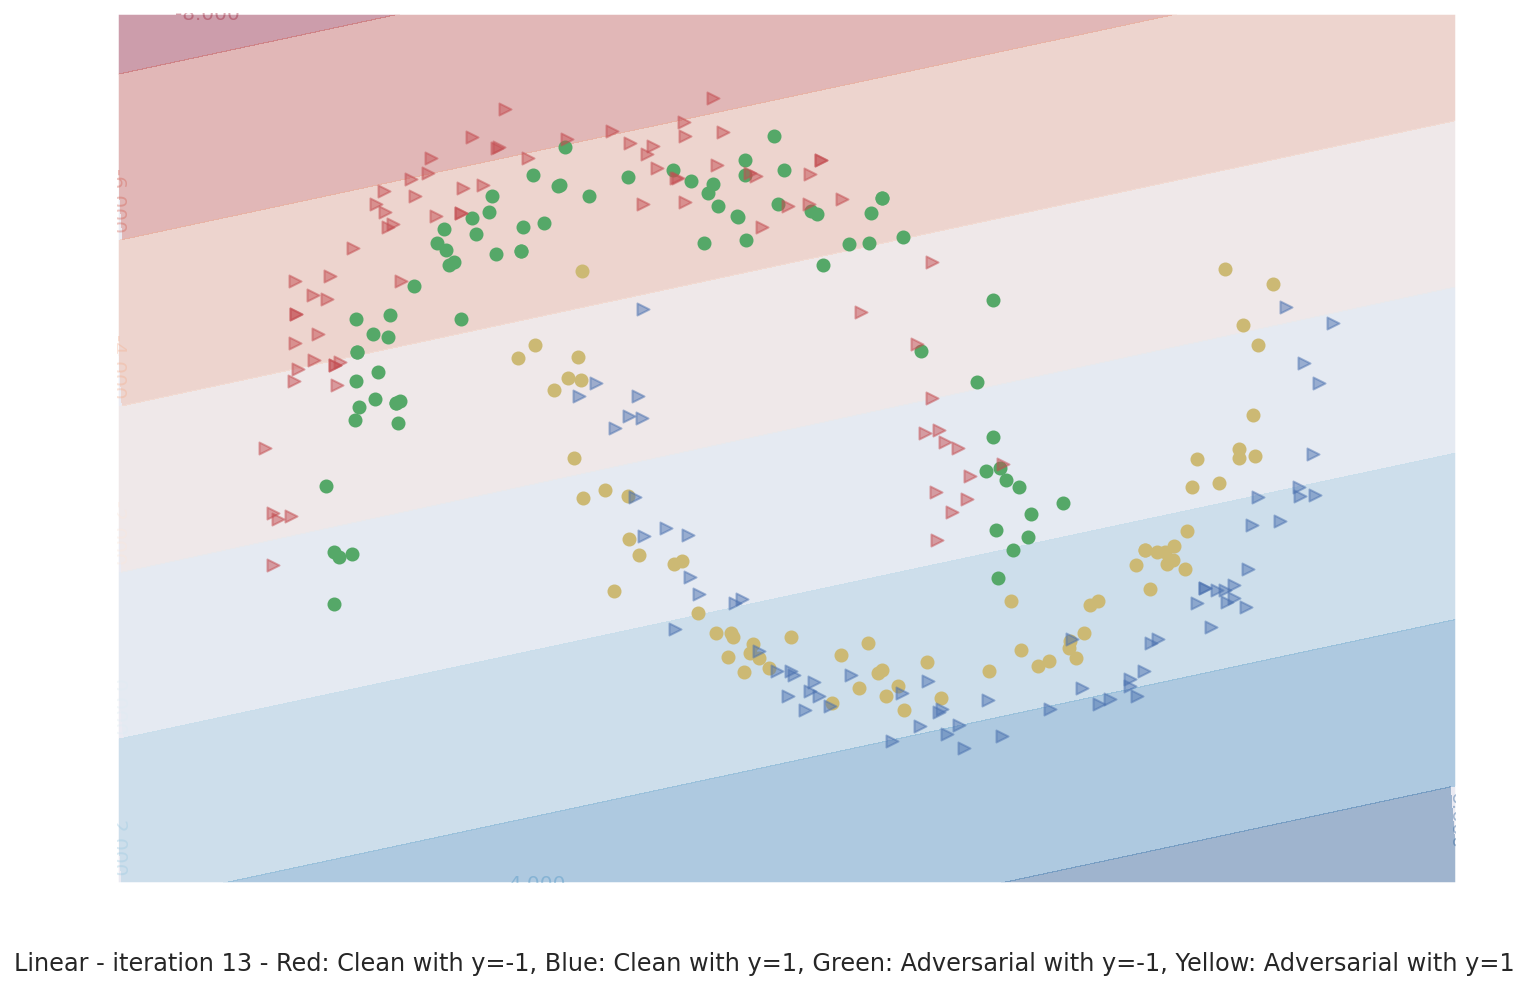

in plot_data


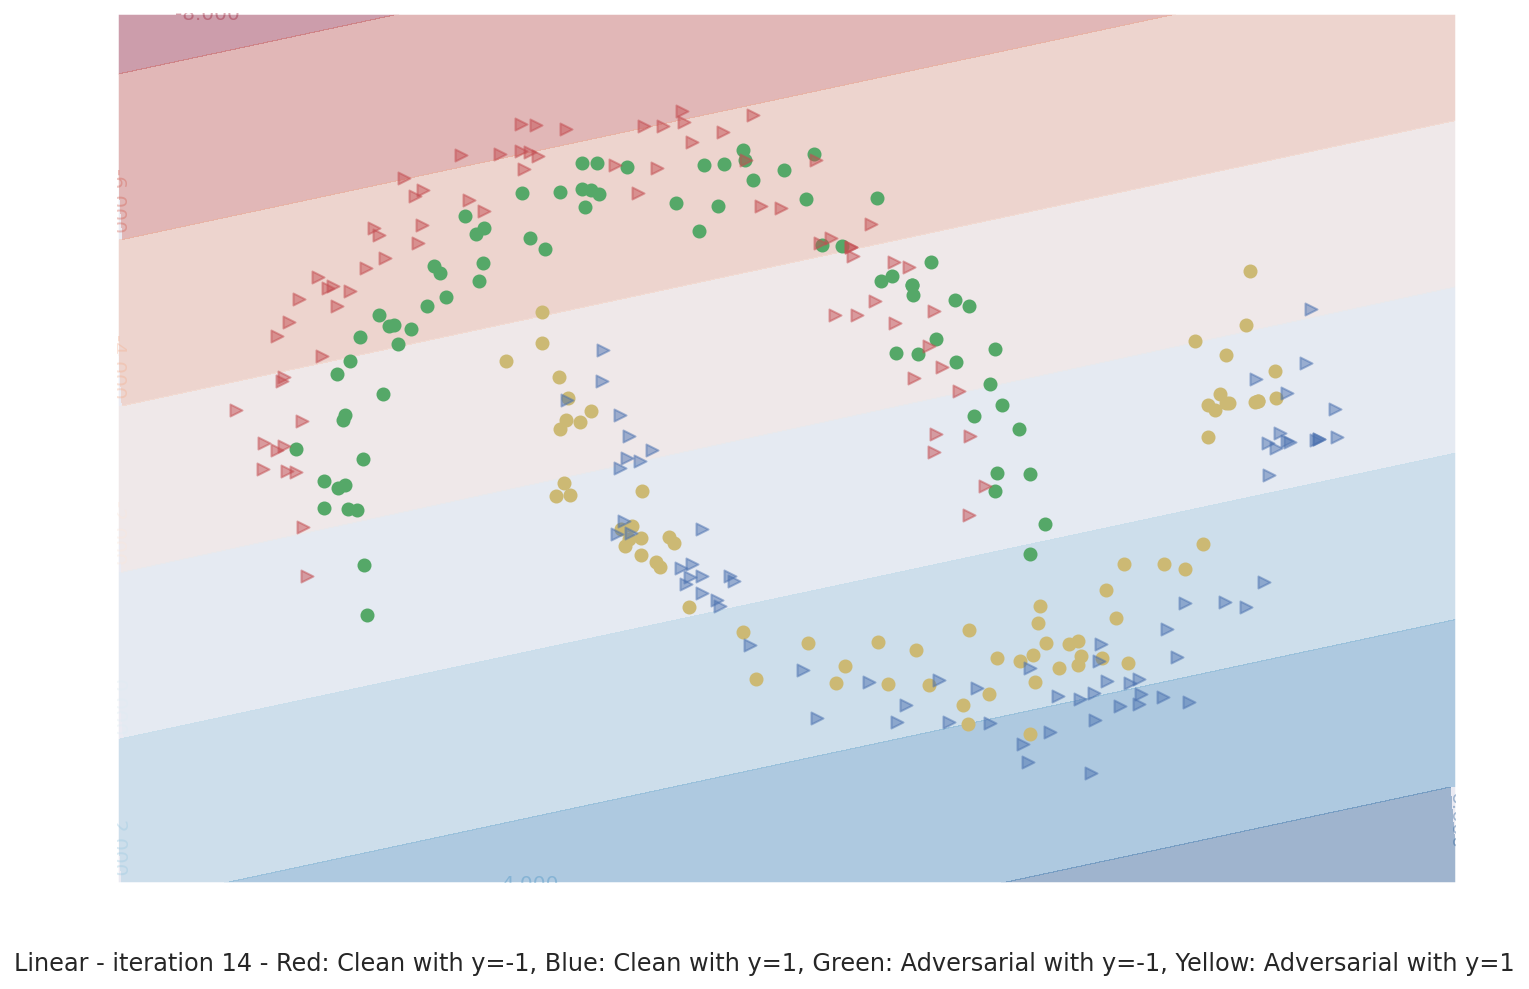

in plot_data


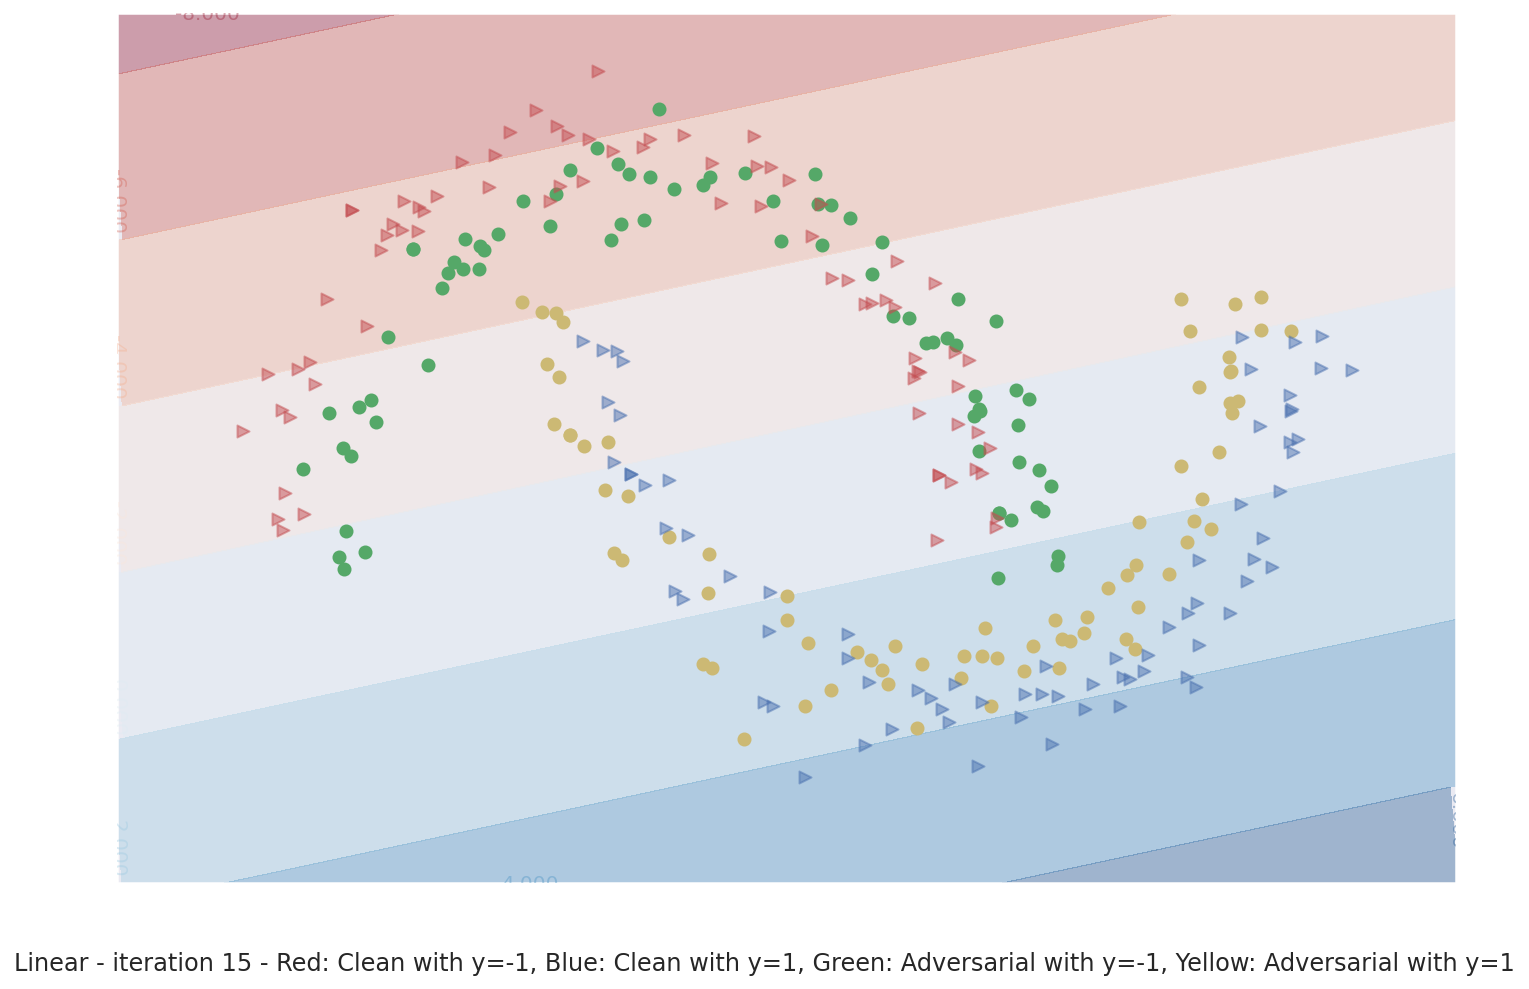

in plot_data


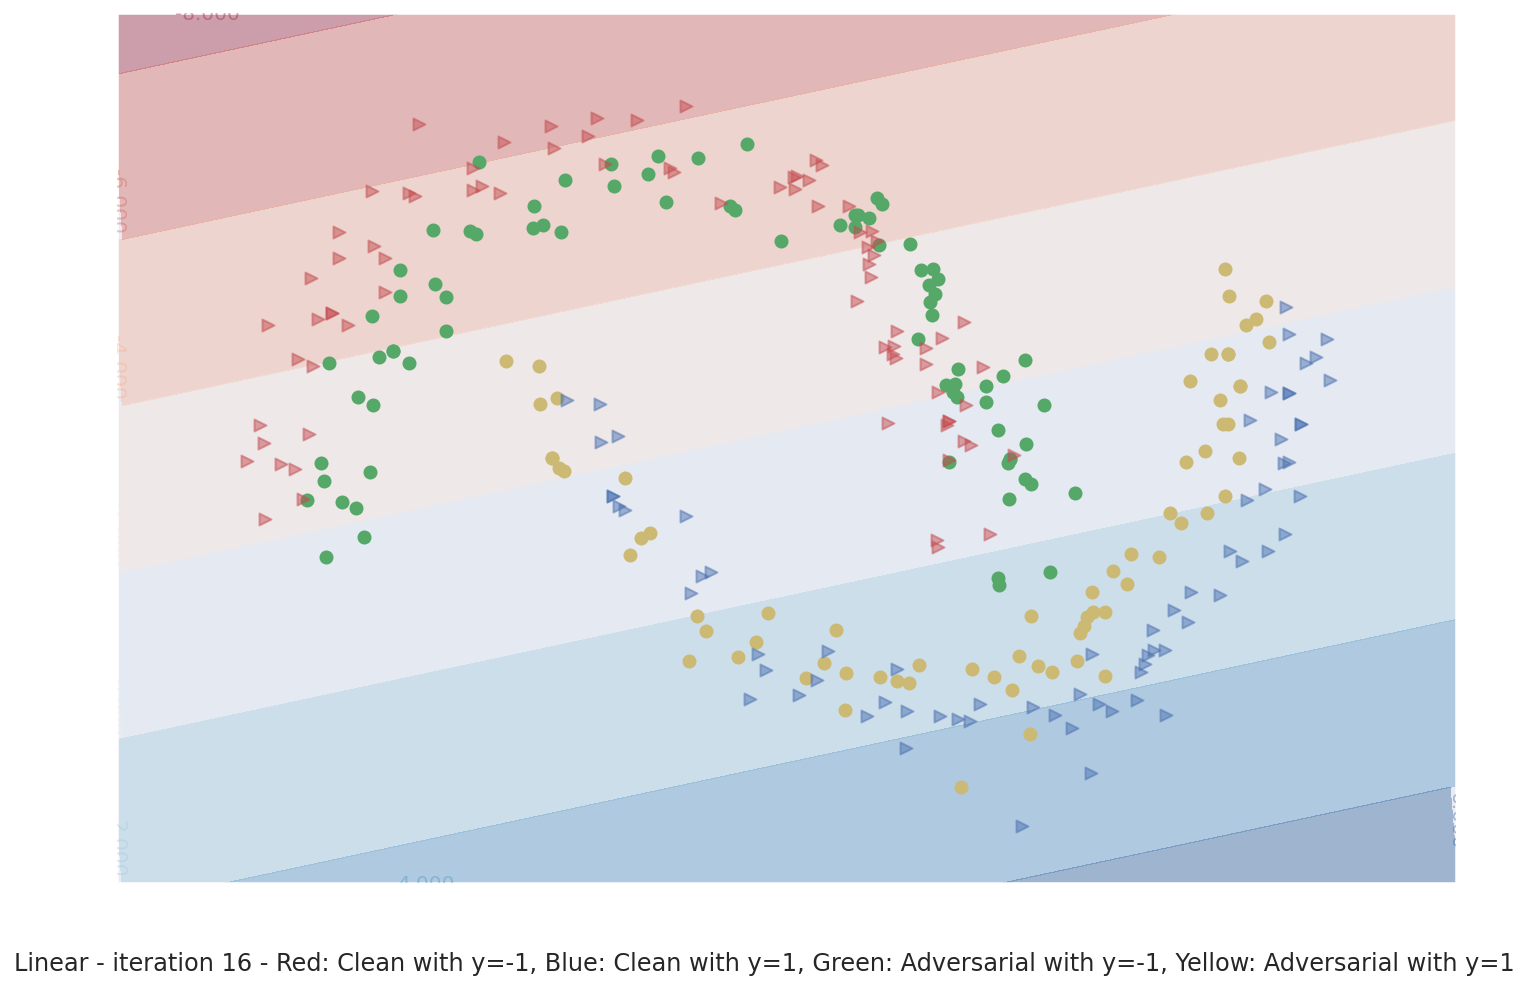

in plot_data


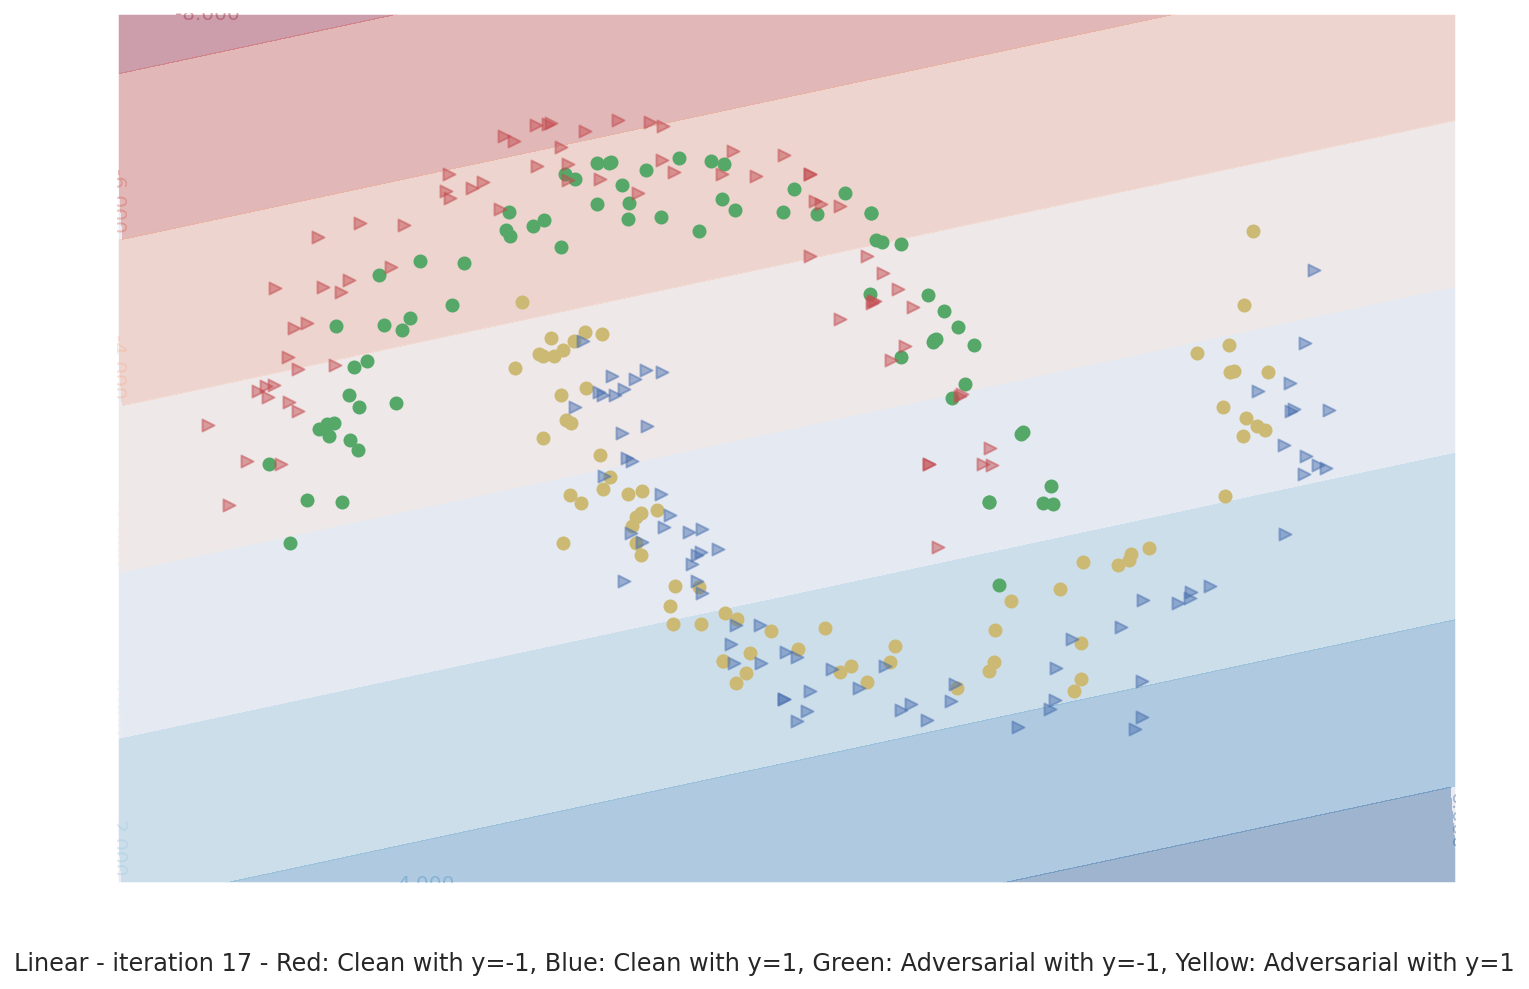

in plot_data


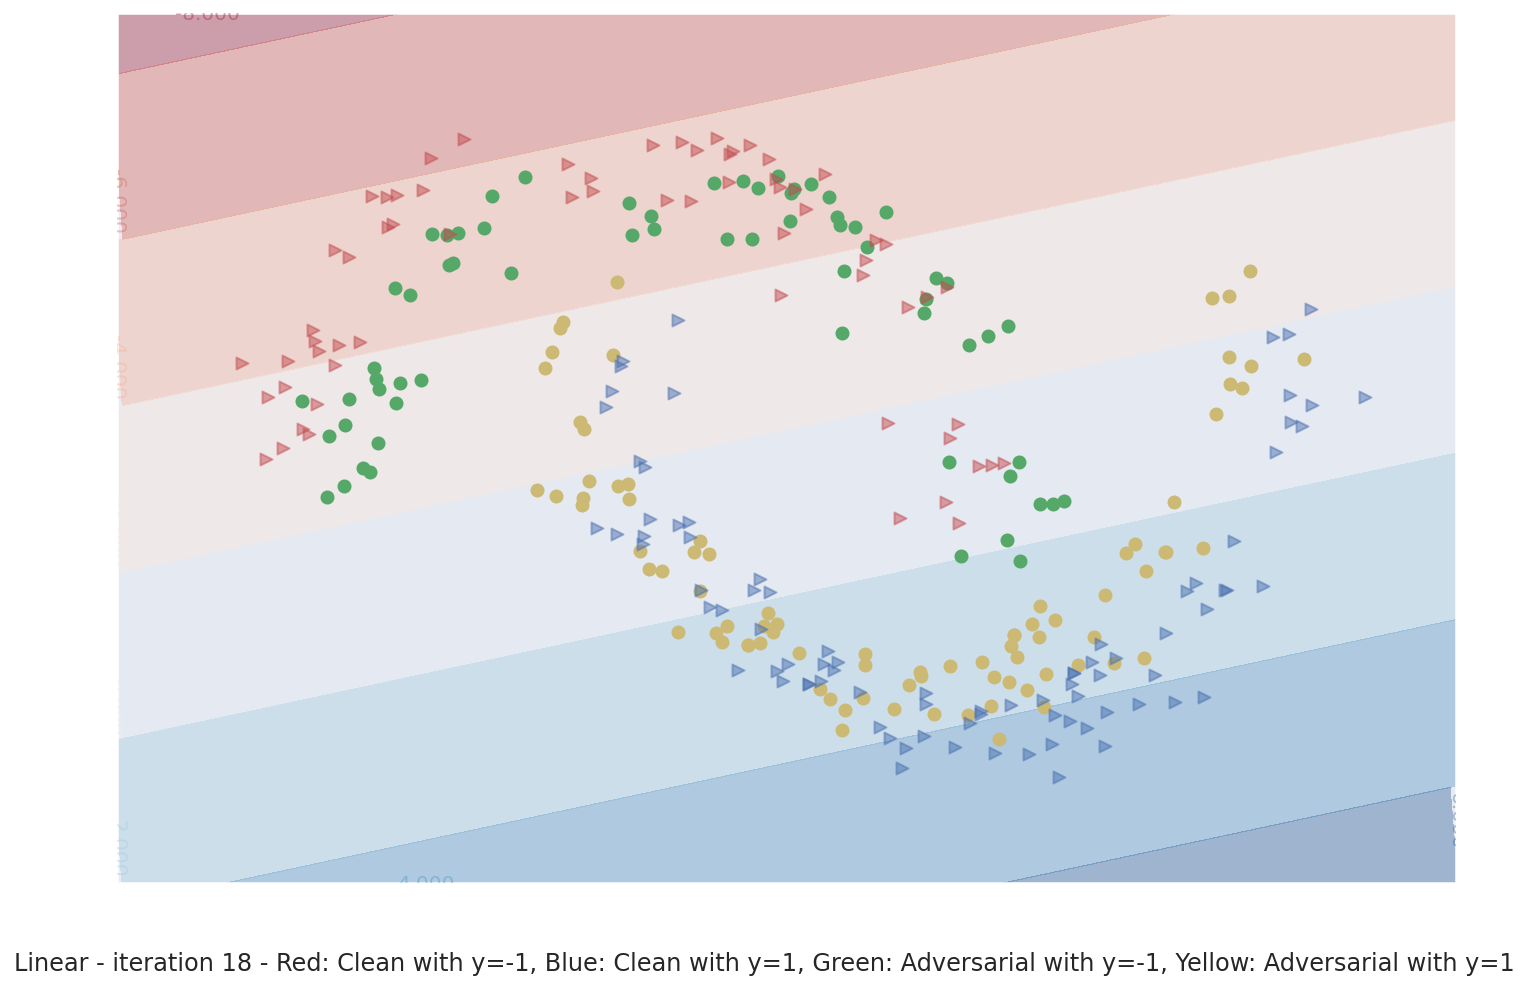

in plot_data


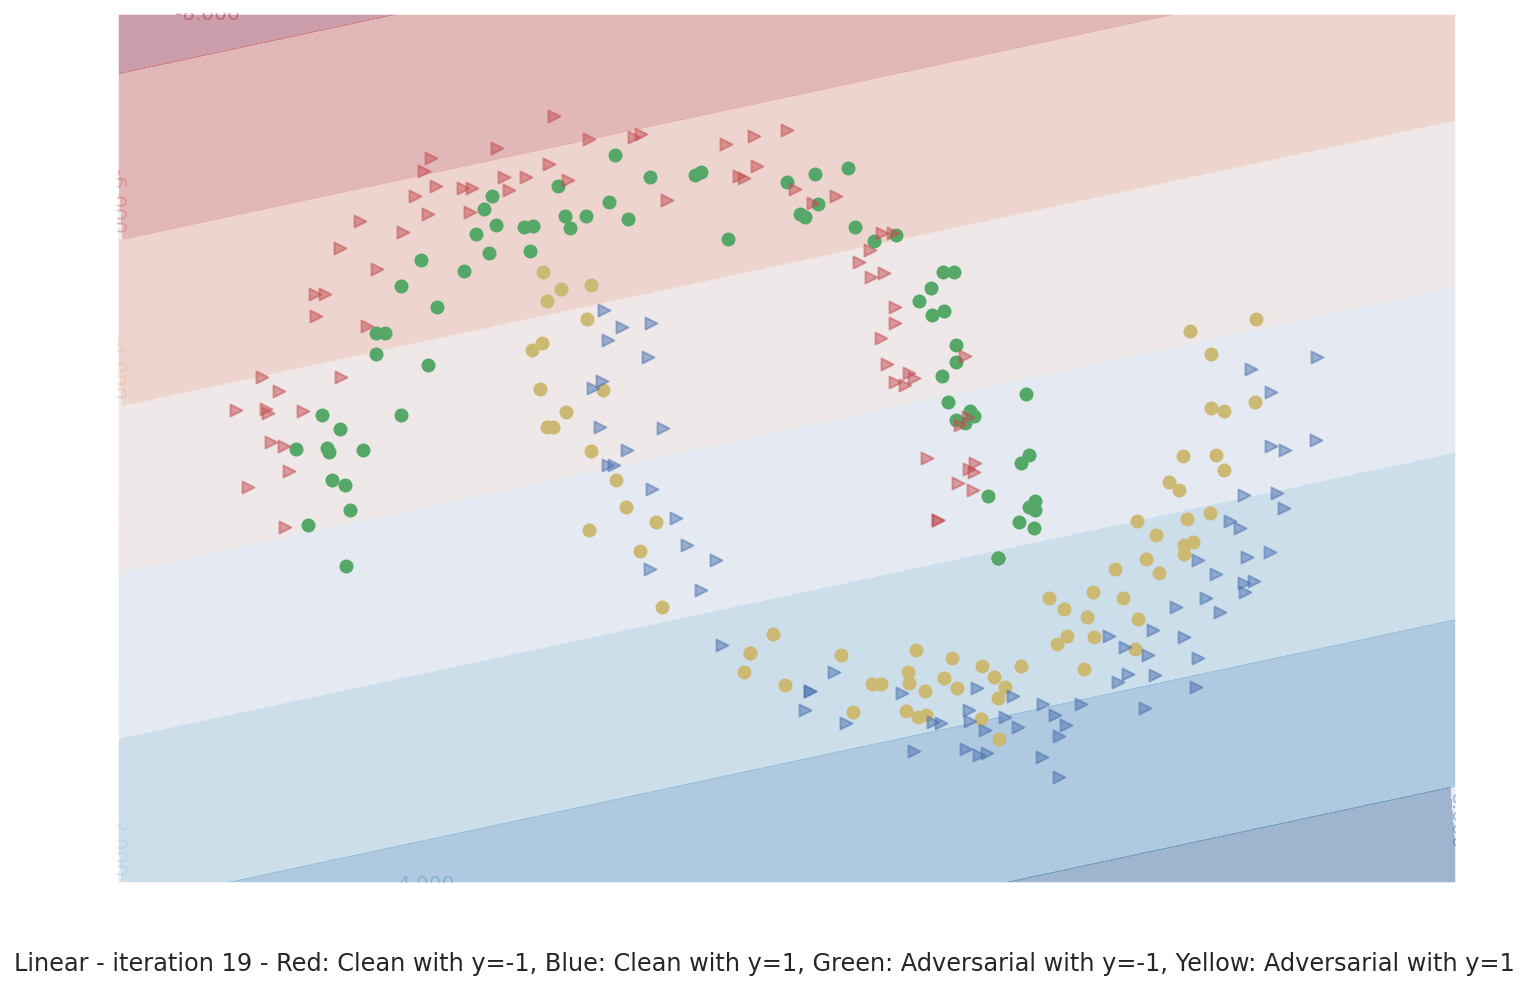

in plot_data_fin


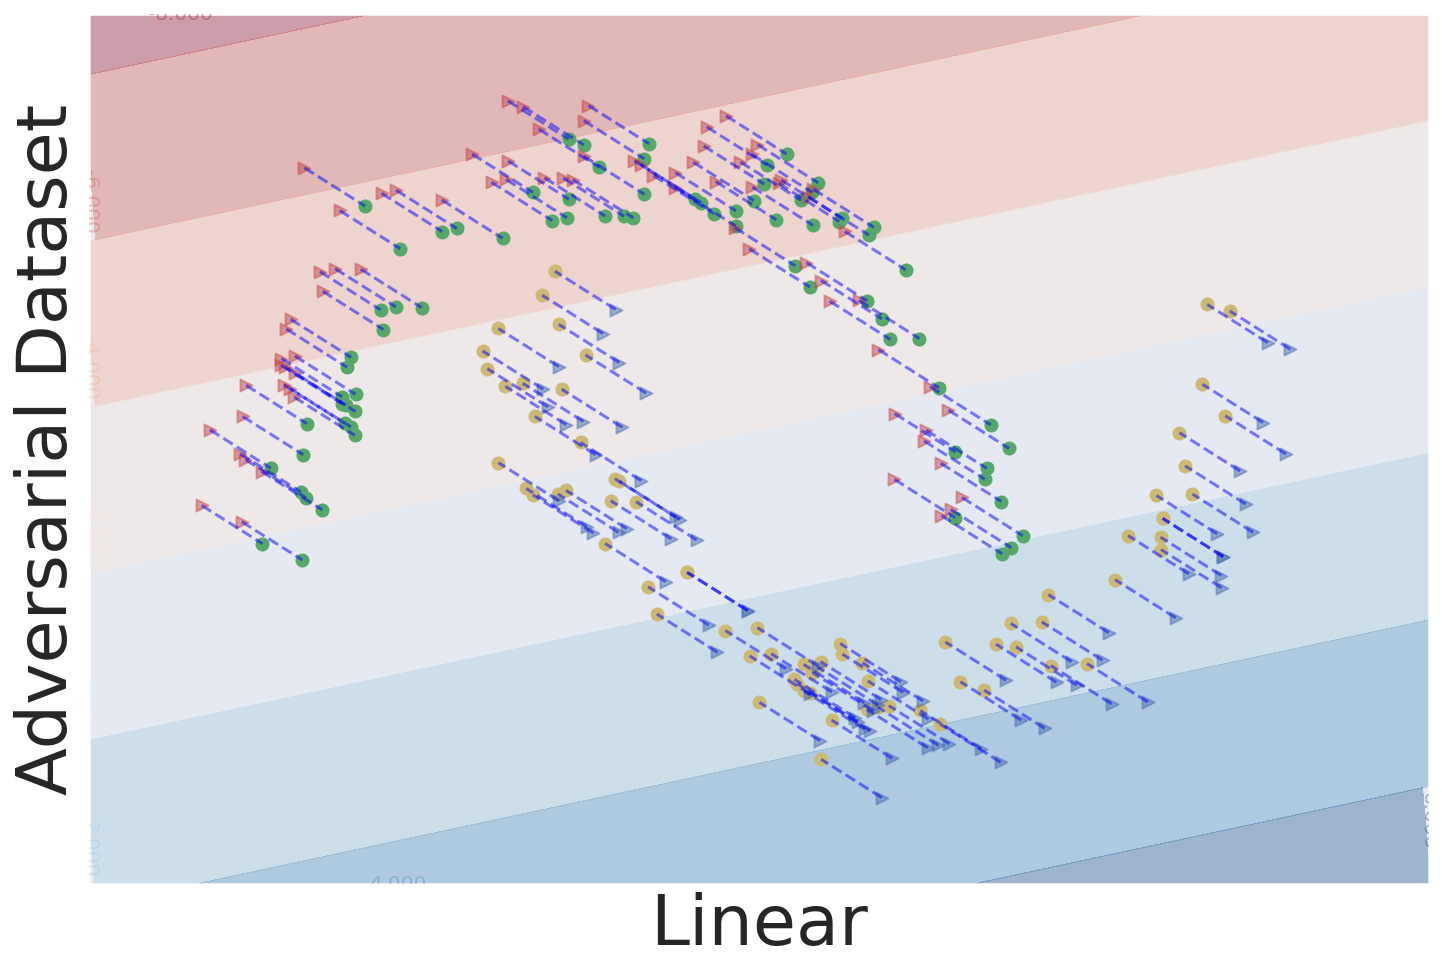

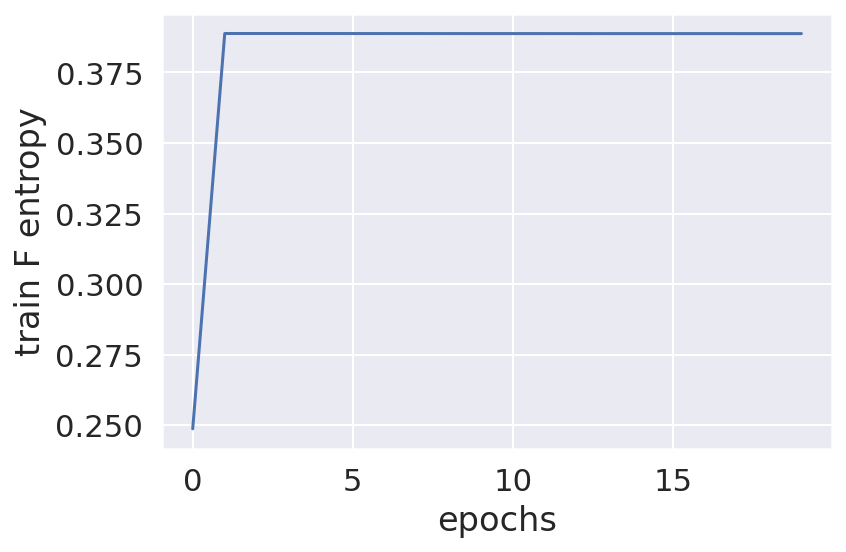

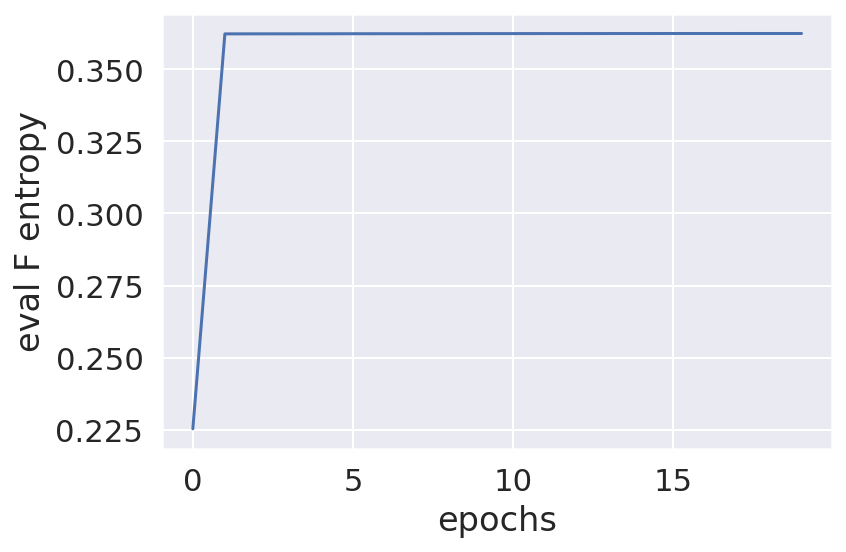

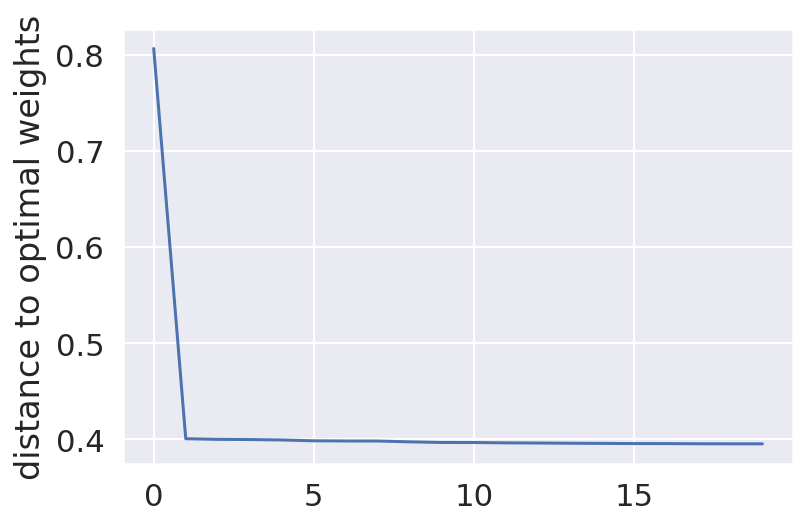

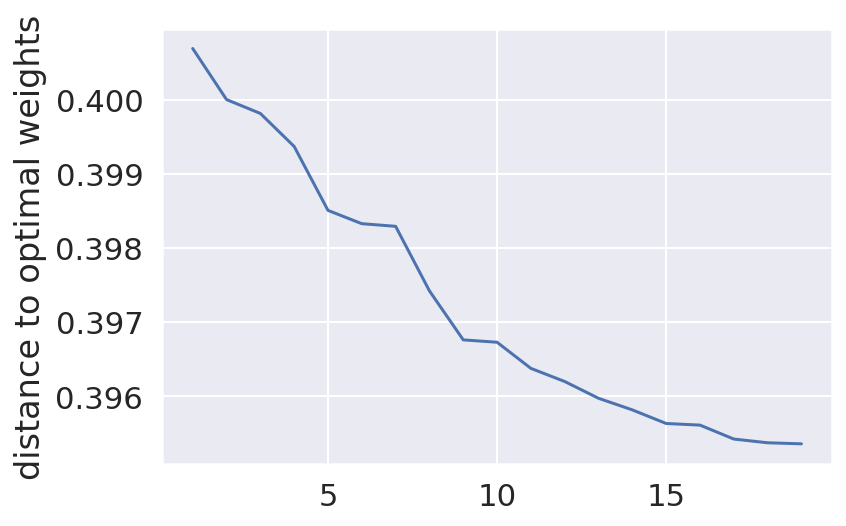

In [27]:
def main():
  args={}
  args['outer_epochs'] = 20
  args['eps'] = 0.2
  args['lr'] = 1e-2
  args['n_samples'] = 500
  args['stop_treshold'] = 1e-10
  args['degree'] = 3
  args['norm'] = 'L_inf'
  args['name'] = 'Linear'
  
  X_train, y_train, X_eval, y_eval = create_dataloaders(4000)
  critic = Critic_Linear(2)
  opt_weights = train_reg(critic, X_train, y_train, args)
  print('opt_weights calculated')
  args['opt_w'] = opt_weights
  critic = Critic_Linear(2)
  train_entropies_poly3, eval_entropies_poly3 = train(critic, X_train, y_train, X_eval, y_eval, args, 'prop2')

if __name__=='__main__':
  main()